# Generación de red neural GRU e hiperparametrización para nasdaq100.csv

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization, Bidirectional, LeakyReLU
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam
import plotly.graph_objects as go
from keras import Input

In [2]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the CSV file
def load_data(file_path):
    df = pd.read_csv(file_path, header=[0,1])
    # Primero quitamos la primera fila
    df = df.iloc[1:].copy()

    # Renombramos la columna de fechas bien
    new_cols = df.columns.tolist()
    new_cols[0] = ('Date', '')  # la primera columna será 'Date'
    df.columns = pd.MultiIndex.from_tuples(new_cols)

    # Ahora movemos 'Date' al índice o dejamos que sea columna:
    df = df.rename(columns={'': 'Date'}, level=0)  # si el nivel 1 tiene '' para Date


    return df

def preprocess_data(df, ticker, train_start='2020-01-01', train_end='2023-12-31',
                            test_start='2024-01-01', test_end='2024-12-31', sequence_length=60):
    # Filtrar datos del ticker
    df_ticker = df[ticker].copy()
    df_ticker['Date'] = df['Date']
    
    # Eliminar zeros antes de log
    price_features = ['Open', 'High', 'Low', 'Close', 'Adj Close']
    df_ticker[price_features] = df_ticker[price_features].replace(0, np.nan)
    
    # Calcular log-returns para precios
    for col in price_features:
        df_ticker[f'{col}_logret'] = np.log(df_ticker[col]).diff()
    
    # Volumen: log-transform (no return)
    df_ticker['Volume_log'] = np.log(df_ticker['Volume'] + 1)
    
    # Features finales
    features = [f'{col}_logret' for col in price_features] + ['Volume_log']
    
    # Crear target (si predices returns)
    df_ticker['Return_next'] = np.log(df_ticker['Close'].shift(-1) / df_ticker['Close'])
    # O para dirección (tu implementación actual está bien)
    df_ticker['Direction_next'] = (df_ticker['Close'].shift(-1) > df_ticker['Close']).astype(int)
    
    # Eliminar NaN
    df_ticker = df_ticker.dropna().reset_index(drop=True)
    
    # NO usar StandardScaler - los log-returns ya están en escala apropiada
    data_processed = df_ticker[features].values
    
    # Separar train/test
    train_mask = (df_ticker['Date'] >= train_start) & (df_ticker['Date'] <= train_end)
    test_mask = (df_ticker['Date'] >= test_start) & (df_ticker['Date'] <= test_end)
    
    train_data = data_processed[train_mask]
    test_data = data_processed[test_mask]
    
    # Usar Return_next si predices returns, Direction_next si predices dirección
    target_col = 'Return_next'  # o 'Return_next'
    train_labels = df_ticker.loc[train_mask, target_col].values
    test_labels = df_ticker.loc[test_mask, target_col].values
    
    # Crear secuencias
    X_train, y_train = create_sequences(train_data, train_labels, sequence_length)
    X_test, y_test = create_sequences(test_data, test_labels, sequence_length)
    
    return X_train, y_train, X_test, y_test, None  # No scaler needed       

def create_sequences(data, labels, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(labels[i])
    return np.array(X), np.array(y)


# ================= GPU + Strategy + Mixed Precision (optional) =================
import os, tensorflow as tf
from tensorflow.keras import mixed_precision

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Use both GPUs
strategy = tf.distribute.MirroredStrategy()
print("Replicas:", strategy.num_replicas_in_sync)

# (Optional) Mixed precision on T4s -> speed & memory wins
USE_MIXED = True
if USE_MIXED:
    mixed_precision.set_global_policy("mixed_float16")

# ==================== Your model function (unchanged) ====================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.regularizers import l2

def build_gru_model(sequence_length, n_features):
    model = Sequential([
        Input(shape=(sequence_length, n_features)),                 
        GRU(128, return_sequences=True, kernel_regularizer=l2(1e-5)),
        BatchNormalization(),
        GRU(64, return_sequences=True, kernel_regularizer=l2(1e-5)),
        BatchNormalization(),
        GRU(64, return_sequences=True, kernel_regularizer=l2(1e-5)),
        BatchNormalization(),
        GRU(64, kernel_regularizer=l2(1e-5)),
        BatchNormalization(),
        Dense(64, kernel_regularizer=l2(1e-5)), LeakyReLU(negative_slope=0.01),
        BatchNormalization(),
        Dense(64, kernel_regularizer=l2(1e-5)), LeakyReLU(negative_slope=0.01),
        BatchNormalization(),
        Dense(64, kernel_regularizer=l2(1e-5)), LeakyReLU(negative_slope=0.01),
        BatchNormalization(),
        Dense(64, kernel_regularizer=l2(1e-5)), LeakyReLU(negative_slope=0.01),
        BatchNormalization(),
        Dropout(0.35),
        # IMPORTANT when using mixed precision: ensure float32 output for losses/metrics
        Dense(1, activation='linear', dtype='float32')
    ])
    return model


# Evaluate model
def evaluate_model(model, X_test, y_test):   
    y_pred = model.predict(X_test)

    y_pred_binary = (pd.Series(y_pred.flatten()).diff() >= 0).astype(int).iloc[1:] # Remove the first element
    y_test_binary = (pd.Series(y_test.flatten()).diff() >= 0).astype(int).iloc[1:]         # Remove the first element

    accuracy = accuracy_score(y_test_binary,y_pred_binary)
    precision = precision_score(y_test_binary, y_pred_binary)
    recall = recall_score(y_test_binary, y_pred_binary)
    f1 = f1_score(y_test_binary, y_pred_binary)
    # Estimate the RMSE
    rmse = np.sqrt(np.mean((y_test.flatten() - y_pred.flatten()) ** 2))
    

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"RMSE: {rmse:.6f}")

    # Plot confusion matrix
    cm = confusion_matrix(y_test_binary, y_pred_binary)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return accuracy, precision, recall, f1, rmse

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Replicas: 1


In [12]:
def execute_training_tickers(ticker,sequence_length):
    print("/--------------------------------------------------------------------/")
    print(ticker)
    print("/--------------------------------------------------------------------/")
    df = load_data(file_path)
    X_train, y_train, X_test, y_test, scaler = preprocess_data(
        df, ticker,
        train_start='2020-01-01', train_end='2023-12-31',
        test_start='2024-01-01', test_end='2024-12-31',
        sequence_length=sequence_length
    )

    # Build and train model
    model = build_gru_model(sequence_length, X_train.shape[2])

    # Callbacks for early stopping and learning rate reduction
    early_stopping = EarlyStopping(
        monitor='val_mae',  # Switch to val_loss for smoother monitoring
        patience=25,         # Increase patience to allow recovery
        restore_best_weights=True,
        verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=25,          # Reduce patience to trigger sooner
        min_lr=1e-6,
        verbose=1
    )

    optimizer = Adam(learning_rate=0.001) # You can tune the learning rate
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # Train
    history = model.fit(
        X_train, y_train,
        epochs=200,          # Increase epochs
        batch_size=16,       # Increase batch size
        validation_split=0.2,  # Increase validation split
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Evaluate model
    accuracy, precision, recall, f1, rmse = evaluate_model(model, X_test, y_test)

    # Predict and calculate residuals
    y_pred = model.predict(X_test).flatten()
    residuals = y_test - y_pred
    return accuracy, precision, recall, f1, rmse

    # Create the figure
    fig = go.Figure()

    # Add Actual values
    fig.add_trace(go.Scatter(
        y=y_test,
        mode='lines',
        name='Actual',
        line=dict(color='blue', width=2),
        opacity=0.6
    ))

    # Add Predicted values
    fig.add_trace(go.Scatter(
        y=y_pred,
        mode='lines',
        name='Predicted',
        line=dict(color='green', width=2),
        opacity=0.6
    ))

    # Update layout
    fig.update_layout(
        title='Comparison of Actual and Predicted',
        xaxis_title='Sample index',
        yaxis_title='Value',
        template='plotly_white'
    )

    # Show figure
    fig.show()


[1/101] Training FANG ...
/--------------------------------------------------------------------/
FANG
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 1.8511 - mae: 1.0661 - val_loss: 0.0207 - val_mae: 0.1195 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2170 - mae: 0.8487 - val_loss: 0.0266 - val_mae: 0.1419 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8714 - mae: 0.7320 - val_loss: 0.0071 - val_mae: 0.0257 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7171 - mae: 0.6619 - val_loss: 0.0075 - val_mae: 0.0307 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6132 - mae: 0.6164 - val_loss: 0.1040 - val_mae: 0.3069 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4169 - mae: 0.5014 - val_loss: 0.0224 - val_mae: 0.1081

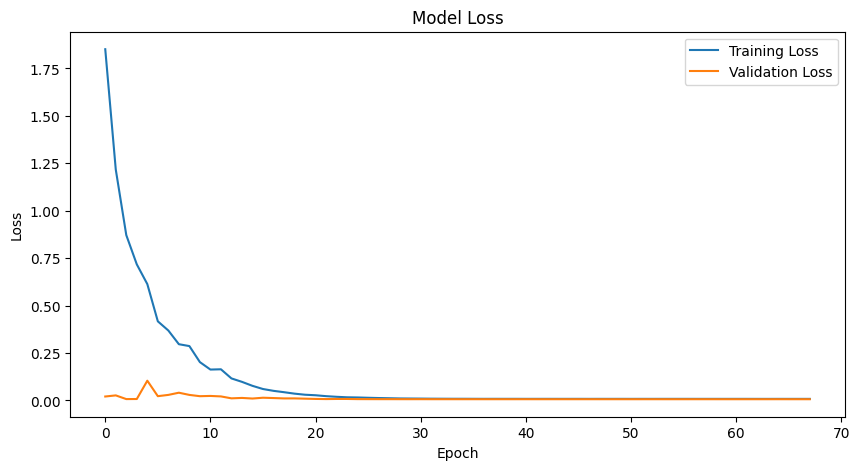

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Accuracy: 0.4221
Precision: 0.4264
Recall: 0.4508
F1-Score: 0.4382
RMSE: 0.018188


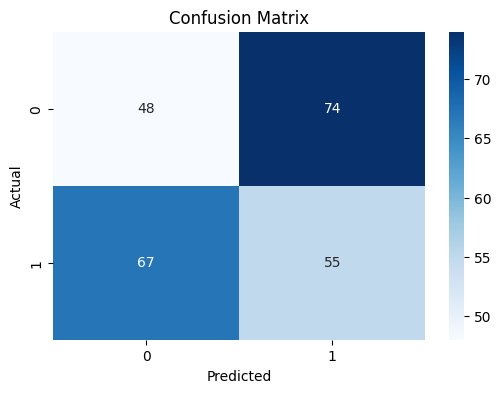

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[2/101] Training BKR ...
/--------------------------------------------------------------------/
BKR
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 2.2475 - mae: 1.1728 - val_loss: 0.0261 - val_mae: 0.1401 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1508 - mae: 0.8367 - val_loss: 0.2344 - val_mae: 0.4774 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9069 - mae: 0.7472 - val_loss: 0.0269 - val_mae: 0.1420 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7587 - mae: 0.6814 - val_loss: 0.1309 - val_mae: 0.3513 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5955 - mae: 0.5895 - val_loss: 0.0608 - val_mae: 0.2282 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4054 - mae: 0.4921 - 

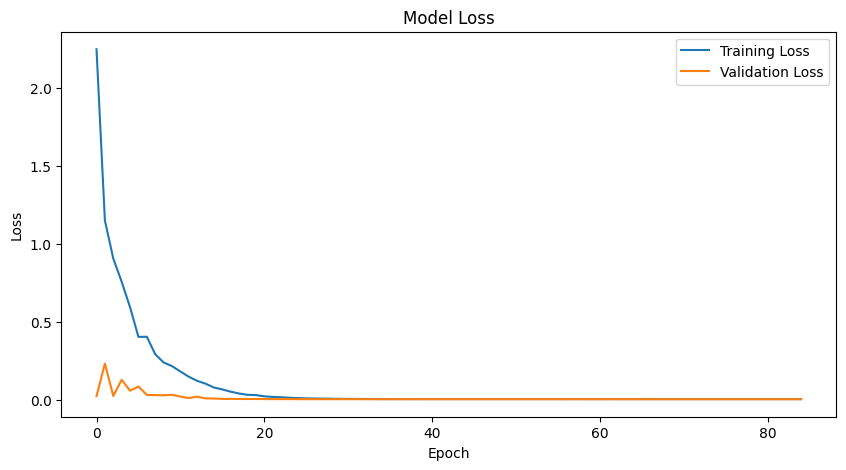

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Accuracy: 0.4467
Precision: 0.4298
Recall: 0.4407
F1-Score: 0.4351
RMSE: 0.018060


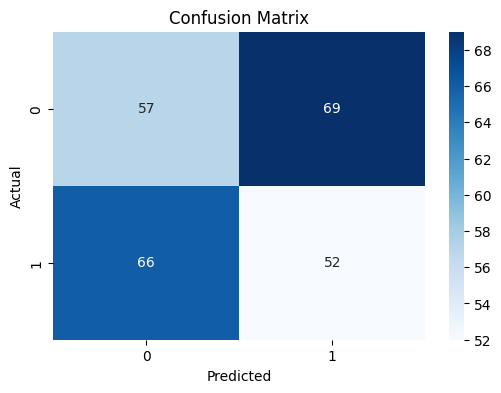

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[3/101] Training CDNS ...
/--------------------------------------------------------------------/
CDNS
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 2.1534 - mae: 1.1388 - val_loss: 0.0233 - val_mae: 0.1300 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1689 - mae: 0.8446 - val_loss: 0.0114 - val_mae: 0.0700 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8126 - mae: 0.7062 - val_loss: 0.0217 - val_mae: 0.1218 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7339 - mae: 0.6549 - val_loss: 0.0266 - val_mae: 0.1383 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5481 - mae: 0.5808 - val_loss: 0.0113 - val_mae: 0.0629 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4587 - mae: 0.5182

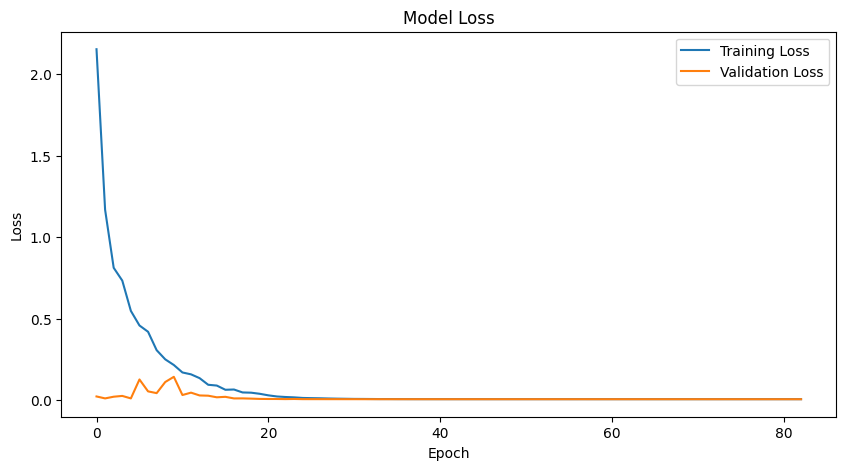

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Accuracy: 0.5410
Precision: 0.5308
Recall: 0.5750
F1-Score: 0.5520
RMSE: 0.022079


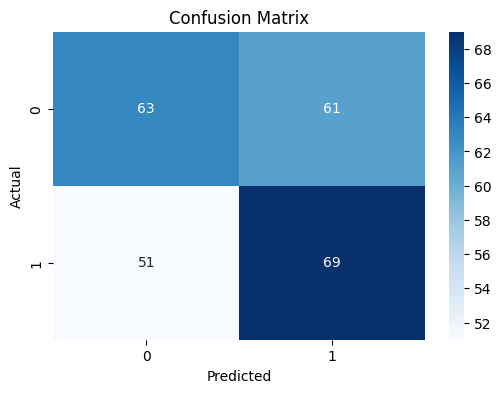

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[4/101] Training CSCO ...
/--------------------------------------------------------------------/
CSCO
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 2.1173 - mae: 1.1315 - val_loss: 0.0083 - val_mae: 0.0452 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0003 - mae: 0.7756 - val_loss: 0.0130 - val_mae: 0.0816 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7338 - mae: 0.6776 - val_loss: 0.0329 - val_mae: 0.1630 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5052 - mae: 0.5525 - val_loss: 0.0118 - val_mae: 0.0713 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4445 - mae: 0.5122 - val_loss: 0.0334 - val_mae: 0.1626 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3575 - mae: 0.4625 

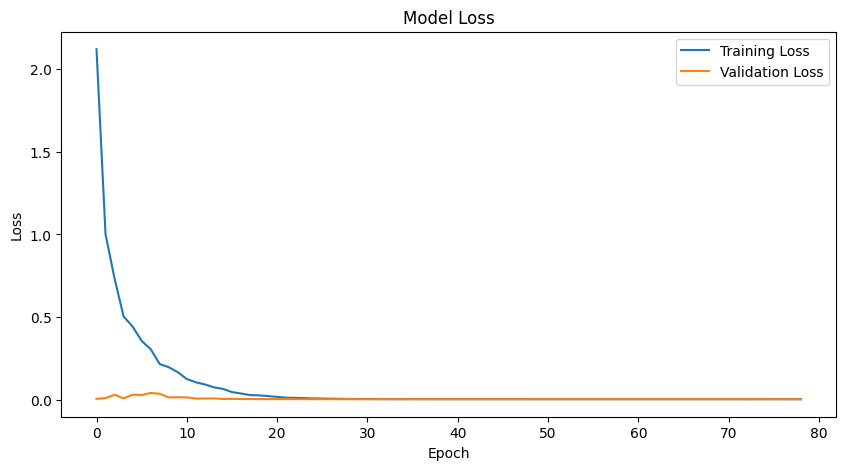

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Accuracy: 0.4918
Precision: 0.4701
Recall: 0.4701
F1-Score: 0.4701
RMSE: 0.011839


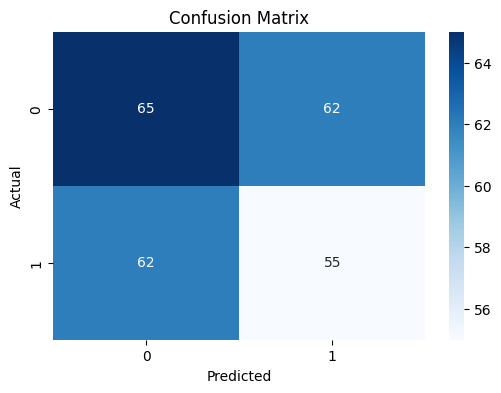

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[5/101] Training MSTR ...
/--------------------------------------------------------------------/
MSTR
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 1.5419 - mae: 0.9609 - val_loss: 0.0638 - val_mae: 0.2364 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0831 - mae: 0.7921 - val_loss: 0.0226 - val_mae: 0.1189 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8858 - mae: 0.7379 - val_loss: 0.1013 - val_mae: 0.3052 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7805 - mae: 0.6734 - val_loss: 0.0722 - val_mae: 0.2529 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5434 - mae: 0.5808 - val_loss: 0.0473 - val_mae: 0.1876 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4330 - mae: 0.5137 - v

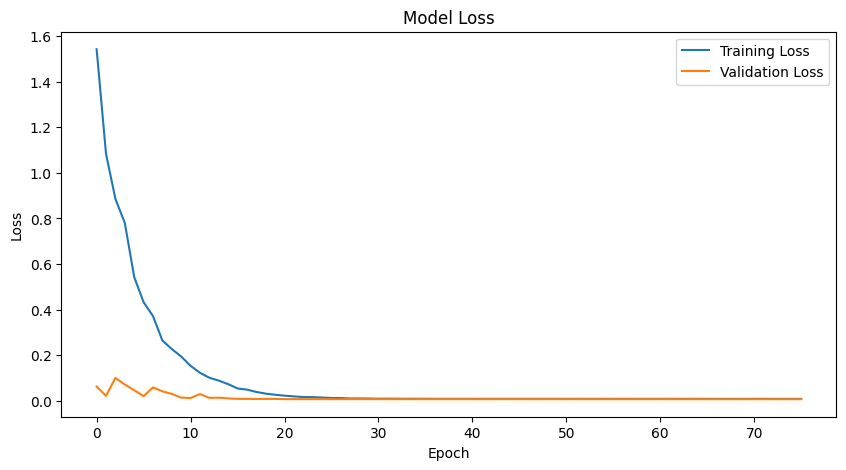

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Accuracy: 0.5000
Precision: 0.4690
Recall: 0.4609
F1-Score: 0.4649
RMSE: 0.068998


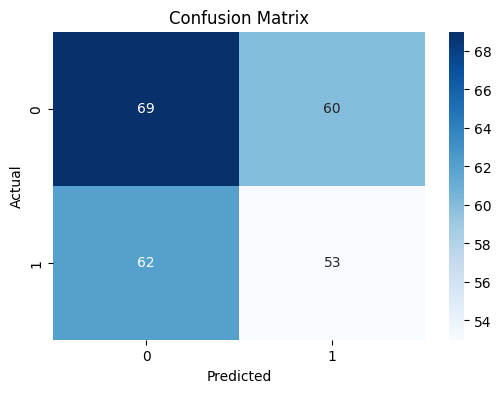

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[6/101] Training GOOG ...
/--------------------------------------------------------------------/
GOOG
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 1.4898 - mae: 0.9557 - val_loss: 0.0747 - val_mae: 0.2612 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0122 - mae: 0.7957 - val_loss: 0.0622 - val_mae: 0.2358 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7444 - mae: 0.6665 - val_loss: 0.0892 - val_mae: 0.2871 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5899 - mae: 0.5986 - val_loss: 0.1391 - val_mae: 0.3562 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3840 - mae: 0.4786 - val_loss: 0.0436 - val_mae: 0.1823 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3283 - mae: 0.4364 

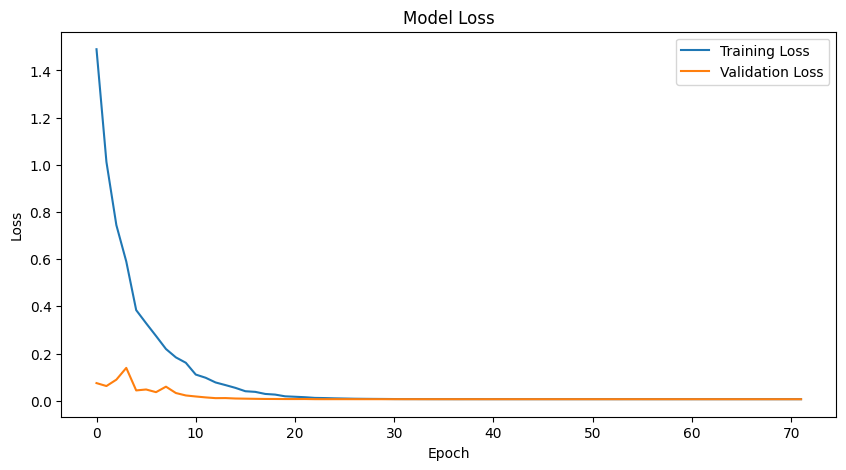

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
Accuracy: 0.5041
Precision: 0.5126
Recall: 0.4919
F1-Score: 0.5021
RMSE: 0.018800


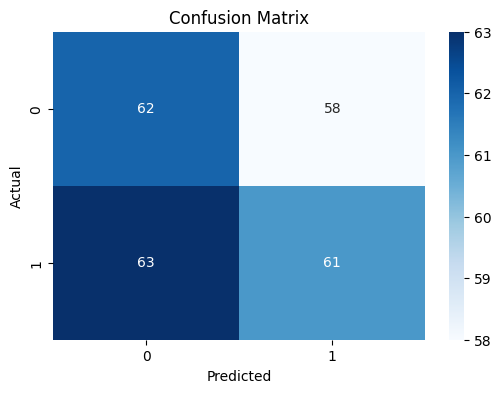

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[7/101] Training FTNT ...
/--------------------------------------------------------------------/
FTNT
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 1.8497 - mae: 1.0679 - val_loss: 0.0114 - val_mae: 0.0694 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1825 - mae: 0.8378 - val_loss: 0.0095 - val_mae: 0.0540 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8727 - mae: 0.7286 - val_loss: 0.0089 - val_mae: 0.0429 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6014 - mae: 0.6056 - val_loss: 0.0161 - val_mae: 0.0691 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5729 - mae: 0.5870 - val_loss: 0.0715 - val_mae: 0.2333 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4569 - mae: 0.5227 -

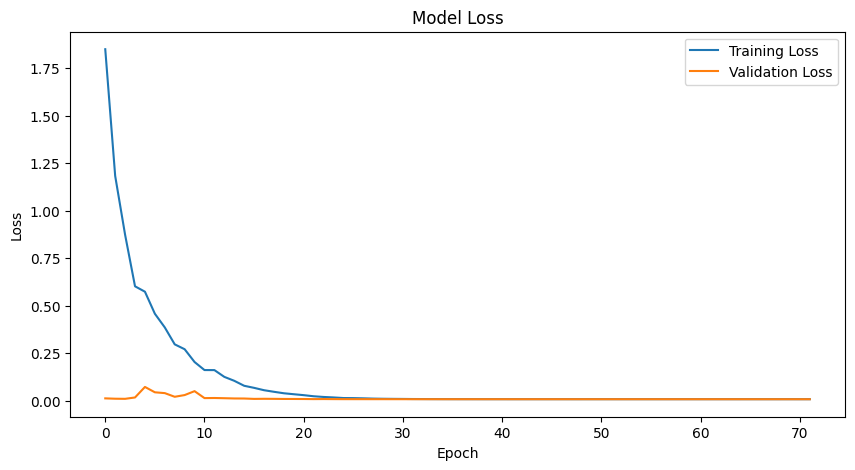

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
Accuracy: 0.5246
Precision: 0.4754
Recall: 0.5273
F1-Score: 0.5000
RMSE: 0.023618


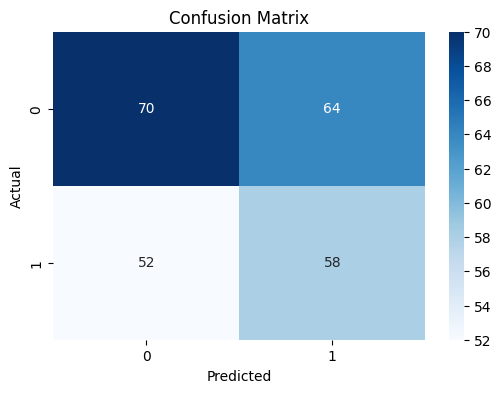

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[8/101] Training NVDA ...
/--------------------------------------------------------------------/
NVDA
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 1.9120 - mae: 1.0682 - val_loss: 0.0069 - val_mae: 0.0188 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1987 - mae: 0.8728 - val_loss: 0.0557 - val_mae: 0.2208 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8179 - mae: 0.6994 - val_loss: 0.0192 - val_mae: 0.1107 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6453 - mae: 0.6262 - val_loss: 0.0337 - val_mae: 0.1608 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5590 - mae: 0.5814 - val_loss: 0.1266 - val_mae: 0.3430 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5221 - mae: 0.5569

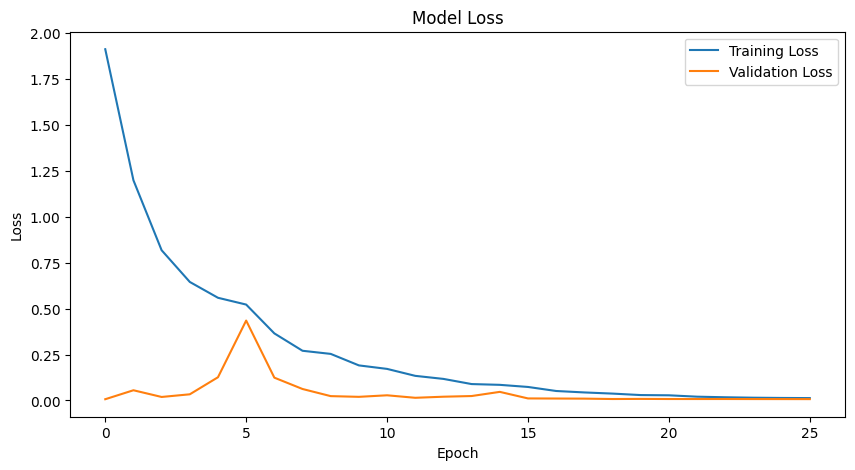

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Accuracy: 0.4959
Precision: 0.4872
Recall: 0.4750
F1-Score: 0.4810
RMSE: 0.032968


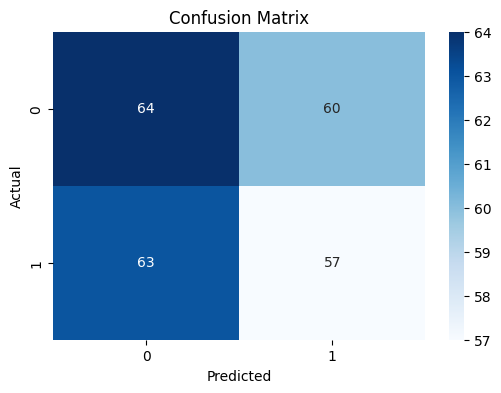

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[9/101] Training TTD ...
/--------------------------------------------------------------------/
TTD
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 1.4559 - mae: 0.9378 - val_loss: 0.0071 - val_mae: 0.0218 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8430 - mae: 0.7295 - val_loss: 0.0070 - val_mae: 0.0208 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6309 - mae: 0.6131 - val_loss: 0.0084 - val_mae: 0.0399 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4883 - mae: 0.5369 - val_loss: 0.0222 - val_mae: 0.1196 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4316 - mae: 0.5080 - val_loss: 0.0154 - val_mae: 0.0655 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3313 - mae: 0.4483 - 

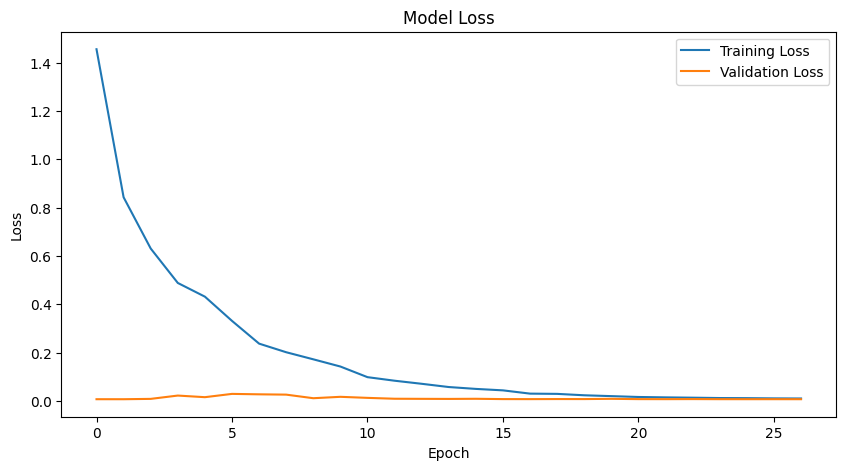

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Accuracy: 0.5451
Precision: 0.5440
Recall: 0.5574
F1-Score: 0.5506
RMSE: 0.026738


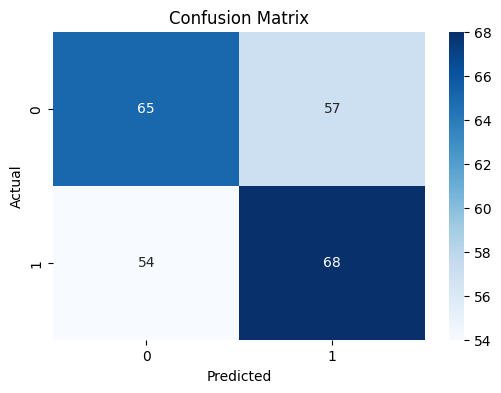

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[10/101] Training GOOGL ...
/--------------------------------------------------------------------/
GOOGL
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 2.5669 - mae: 1.2639 - val_loss: 0.1191 - val_mae: 0.3357 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3401 - mae: 0.9146 - val_loss: 0.0961 - val_mae: 0.2993 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0806 - mae: 0.8168 - val_loss: 0.2537 - val_mae: 0.4967 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8344 - mae: 0.7167 - val_loss: 0.3687 - val_mae: 0.6014 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6328 - mae: 0.6173 - val_loss: 0.0188 - val_mae: 0.0789 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5386 - mae: 0.

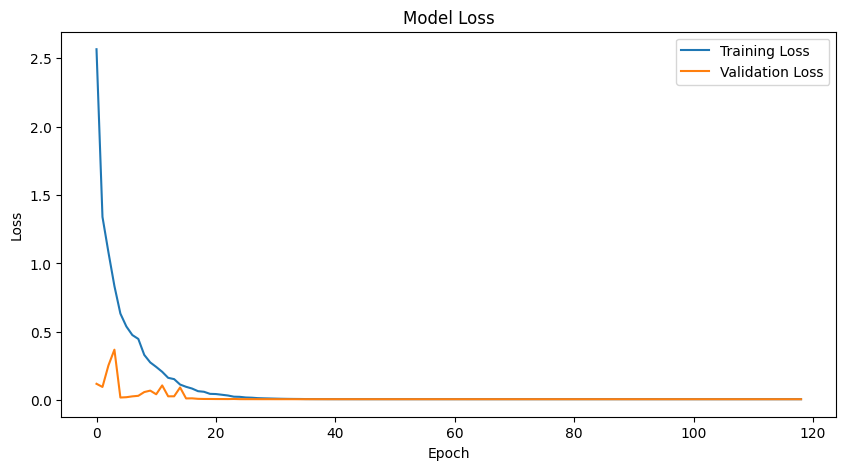

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step
Accuracy: 0.4795
Precision: 0.4870
Recall: 0.4516
F1-Score: 0.4686
RMSE: 0.018013


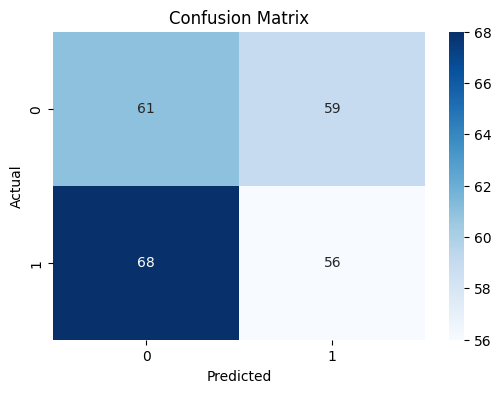

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[11/101] Training ODFL ...
/--------------------------------------------------------------------/
ODFL
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 2.0872 - mae: 1.1441 - val_loss: 0.0600 - val_mae: 0.2314 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3651 - mae: 0.9012 - val_loss: 0.0396 - val_mae: 0.1818 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8738 - mae: 0.7323 - val_loss: 0.0588 - val_mae: 0.2281 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6729 - mae: 0.6304 - val_loss: 0.0128 - val_mae: 0.0654 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6325 - mae: 0.6220 - val_loss: 0.0263 - val_mae: 0.1289 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5462 - mae: 0.5767 -

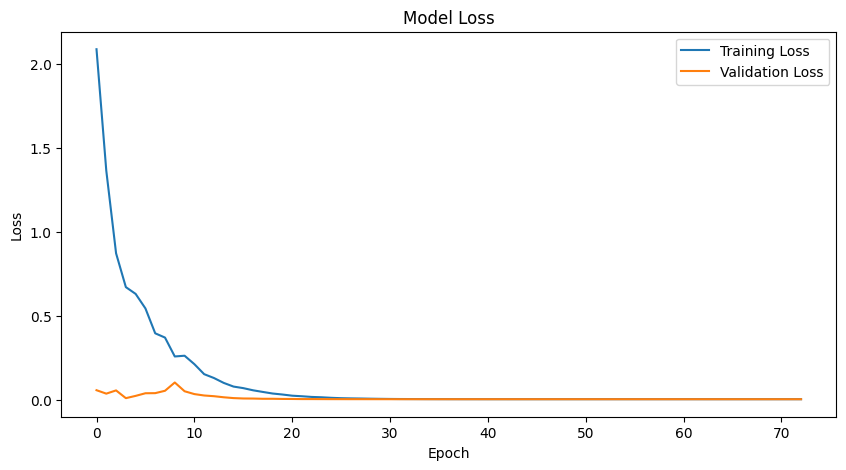

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Accuracy: 0.5492
Precision: 0.5680
Recall: 0.5591
F1-Score: 0.5635
RMSE: 0.021205


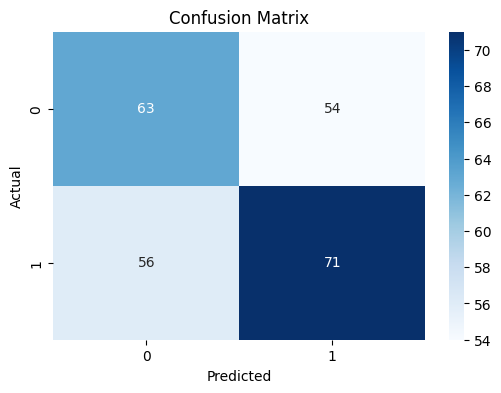

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[12/101] Training ADP ...
/--------------------------------------------------------------------/
ADP
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 2.3435 - mae: 1.1618 - val_loss: 0.0064 - val_mae: 0.0088 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3334 - mae: 0.8890 - val_loss: 0.0133 - val_mae: 0.0832 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9442 - mae: 0.7527 - val_loss: 0.0184 - val_mae: 0.1032 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7451 - mae: 0.6703 - val_loss: 0.0217 - val_mae: 0.1222 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5964 - mae: 0.6064 - val_loss: 0.0264 - val_mae: 0.1382 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5817 - mae: 0.5804 - v

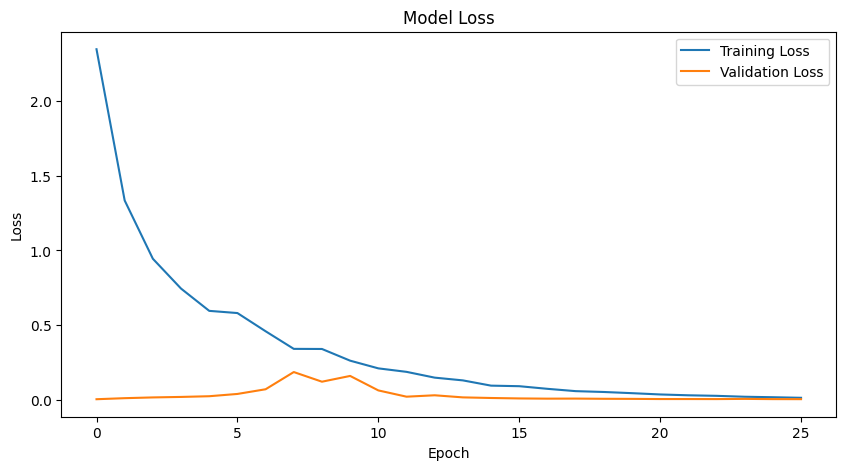

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Accuracy: 0.4590
Precision: 0.4286
Recall: 0.4435
F1-Score: 0.4359
RMSE: 0.009827


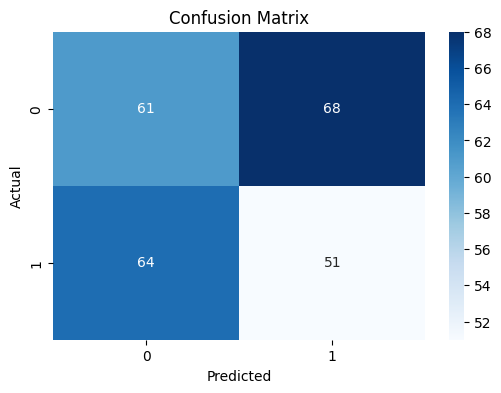

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[13/101] Training MCHP ...
/--------------------------------------------------------------------/
MCHP
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 2.1926 - mae: 1.1382 - val_loss: 0.0074 - val_mae: 0.0298 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0095 - mae: 0.7788 - val_loss: 0.0113 - val_mae: 0.0676 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8534 - mae: 0.7133 - val_loss: 0.0075 - val_mae: 0.0299 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7440 - mae: 0.6665 - val_loss: 0.0180 - val_mae: 0.1052 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5720 - mae: 0.6001 - val_loss: 0.0328 - val_mae: 0.1498 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4798 - mae: 0.5299 - 

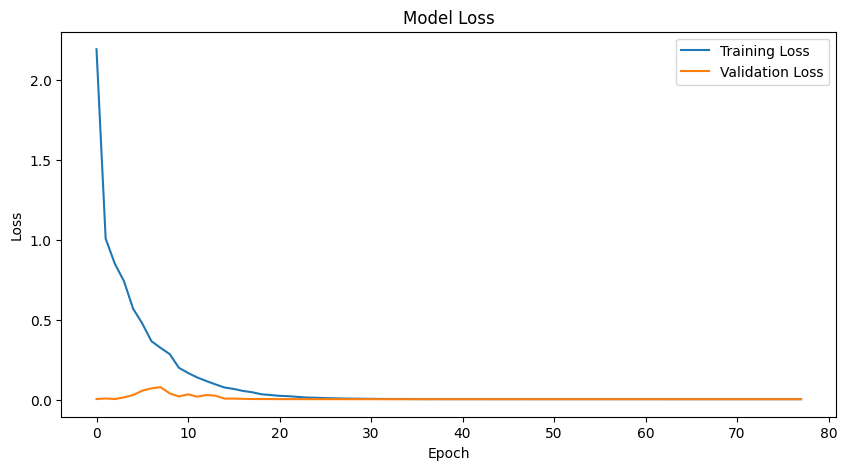

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Accuracy: 0.4754
Precision: 0.5042
Recall: 0.4651
F1-Score: 0.4839
RMSE: 0.025444


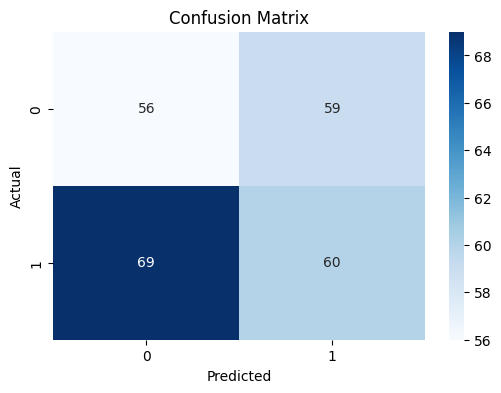

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[14/101] Training XEL ...
/--------------------------------------------------------------------/
XEL
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 1.6933 - mae: 1.0227 - val_loss: 0.0934 - val_mae: 0.2952 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9467 - mae: 0.7594 - val_loss: 0.1318 - val_mae: 0.3543 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6870 - mae: 0.6464 - val_loss: 0.1182 - val_mae: 0.3324 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5615 - mae: 0.5729 - val_loss: 0.0246 - val_mae: 0.1218 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5157 - mae: 0.5579 - val_loss: 0.0525 - val_mae: 0.2034 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3202 - mae: 0.4351 - v

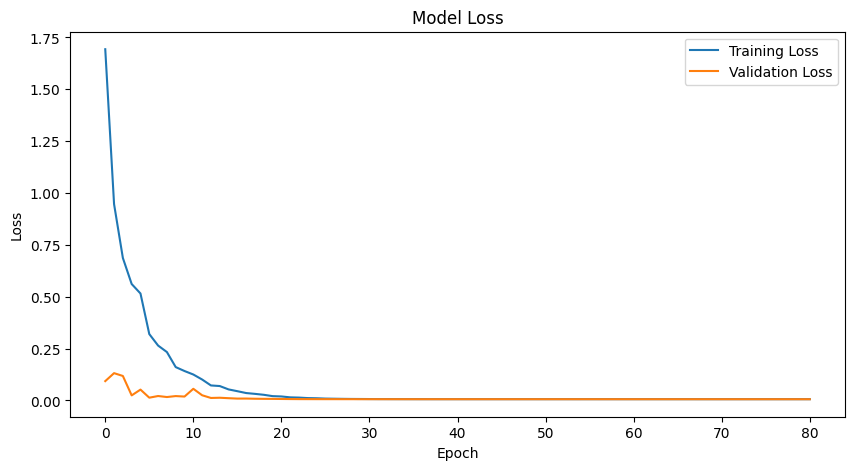

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Accuracy: 0.4221
Precision: 0.4167
Recall: 0.4622
F1-Score: 0.4382
RMSE: 0.015229


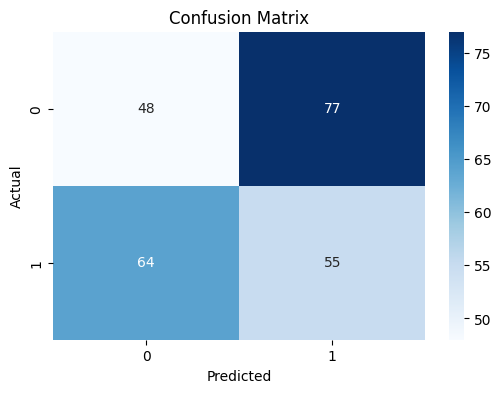

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[15/101] Training ABNB ...
/--------------------------------------------------------------------/
ABNB
/--------------------------------------------------------------------/
Epoch 1/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - loss: 2.1118 - mae: 1.1271 - val_loss: 0.0070 - val_mae: 0.0235 - learning_rate: 0.0010
Epoch 2/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6116 - mae: 1.0045 - val_loss: 0.0135 - val_mae: 0.0823 - learning_rate: 0.0010
Epoch 3/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2348 - mae: 0.8740 - val_loss: 0.0428 - val_mae: 0.1892 - learning_rate: 0.0010
Epoch 4/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1011 - mae: 0.8315 - val_loss: 0.0488 - val_mae: 0.2046 - learning_rate: 0.0010
Epoch 5/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7509 - mae: 0.6774 - val_loss: 0.0580 - val_mae: 0.2244 - learning_rate: 0.0010
Epoch 6/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7049 - mae: 0.62

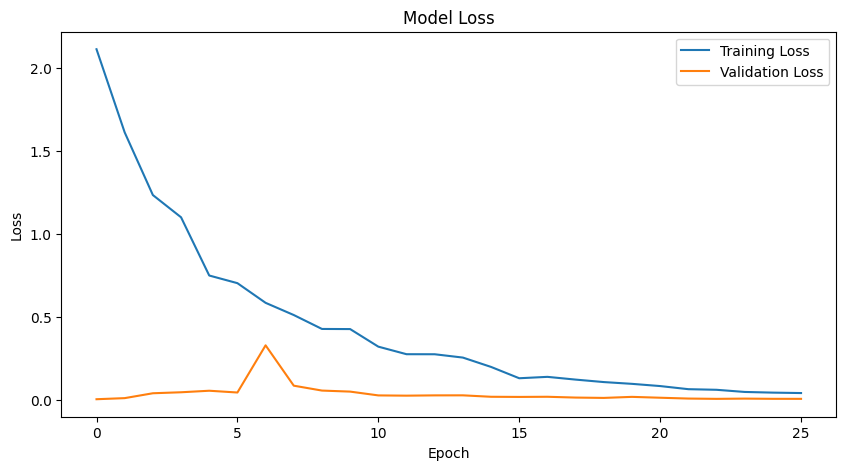

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
Accuracy: 0.4426
Precision: 0.4370
Recall: 0.4298
F1-Score: 0.4333
RMSE: 0.028899


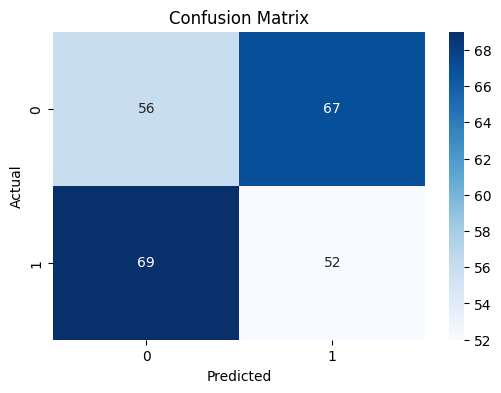

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[16/101] Training ADI ...
/--------------------------------------------------------------------/
ADI
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 1.6111 - mae: 1.0159 - val_loss: 0.0064 - val_mae: 0.0123 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9113 - mae: 0.7518 - val_loss: 0.0211 - val_mae: 0.1210 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6144 - mae: 0.6103 - val_loss: 0.0138 - val_mae: 0.0809 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4581 - mae: 0.5159 - val_loss: 0.0150 - val_mae: 0.0815 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3642 - mae: 0.4642 - val_loss: 0.0190 - val_mae: 0.0885 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3167 - mae: 0.4342

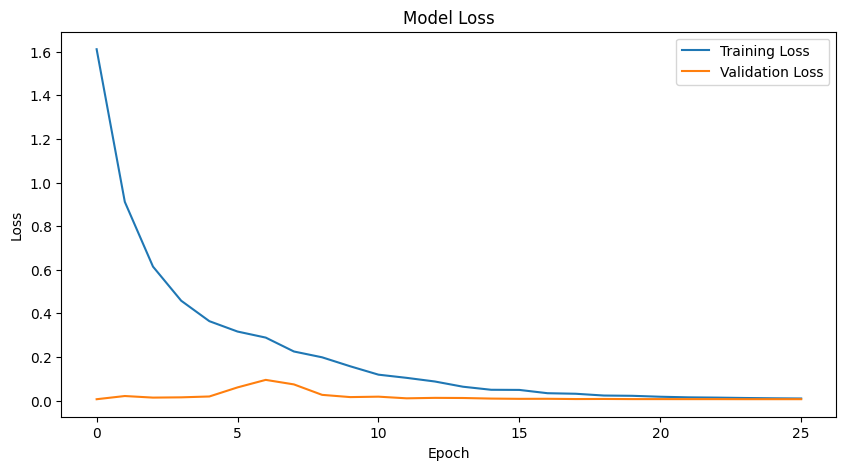

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Accuracy: 0.5041
Precision: 0.5120
Recall: 0.5161
F1-Score: 0.5141
RMSE: 0.020368


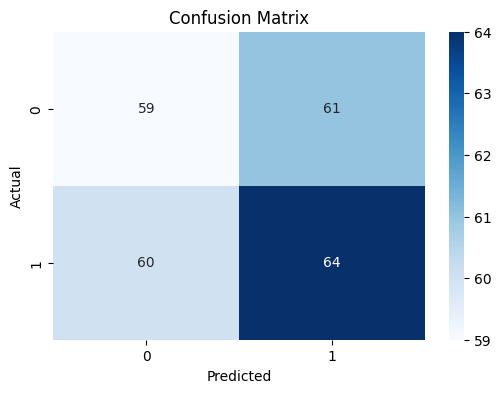

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[17/101] Training APP ...
/--------------------------------------------------------------------/
APP
/--------------------------------------------------------------------/
Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 1.9466 - mae: 1.0861 - val_loss: 0.0238 - val_mae: 0.1303 - learning_rate: 0.0010
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0605 - mae: 0.8249 - val_loss: 0.0345 - val_mae: 0.1660 - learning_rate: 0.0010
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8747 - mae: 0.7288 - val_loss: 0.0842 - val_mae: 0.2773 - learning_rate: 0.0010
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6673 - mae: 0.6365 - val_loss: 0.0221 - val_mae: 0.1222 - learning_rate: 0.0010
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5661 - mae: 0.5883 - val_loss: 0.0102 - val_mae: 0.0561 - learning_rate: 0.0010
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4760 - mae: 0.547

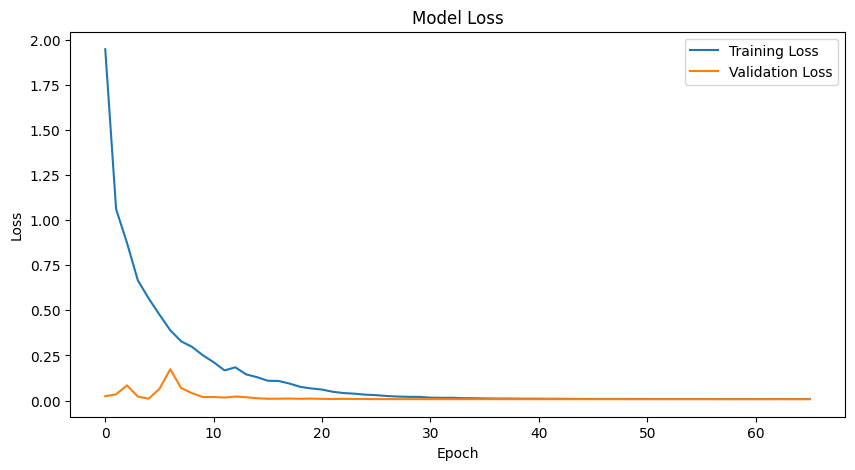

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
Accuracy: 0.5246
Precision: 0.5159
Recall: 0.5417
F1-Score: 0.5285
RMSE: 0.051729


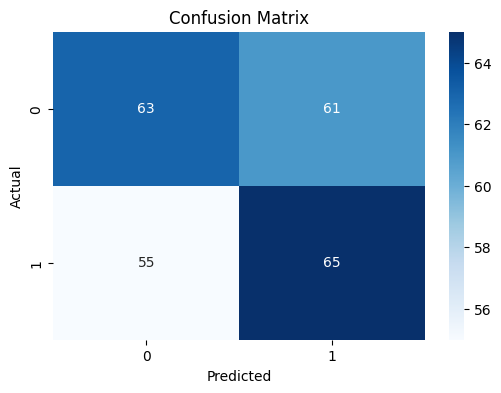

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[18/101] Training BIIB ...
/--------------------------------------------------------------------/
BIIB
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 1.9721 - mae: 1.0792 - val_loss: 0.0166 - val_mae: 0.1009 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1217 - mae: 0.8291 - val_loss: 0.0375 - val_mae: 0.1757 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9241 - mae: 0.7594 - val_loss: 0.0615 - val_mae: 0.2316 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7087 - mae: 0.6685 - val_loss: 0.0074 - val_mae: 0.0204 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5353 - mae: 0.5709 - val_loss: 0.0381 - val_mae: 0.1550 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4314 - mae: 0.51

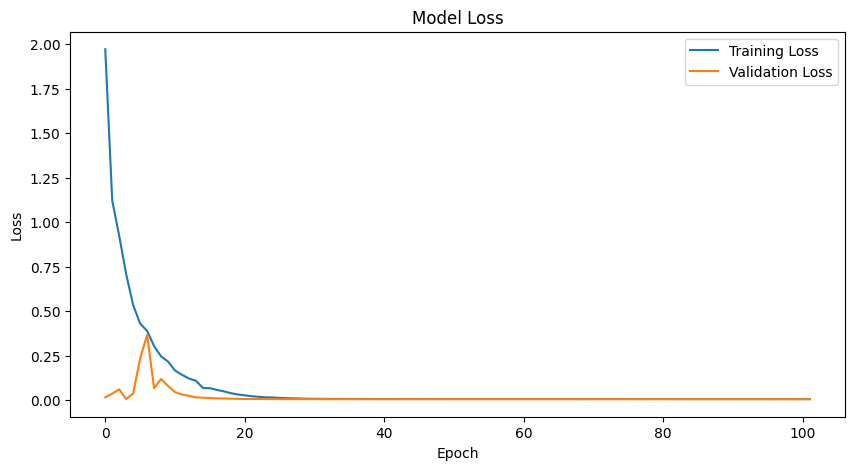

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
Accuracy: 0.4877
Precision: 0.4737
Recall: 0.5339
F1-Score: 0.5020
RMSE: 0.016983


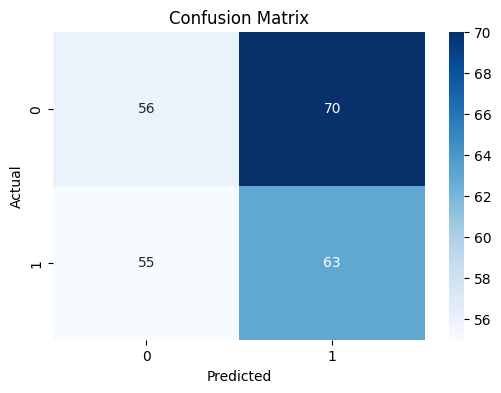

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[19/101] Training ARM ...
/--------------------------------------------------------------------/
ARM
/--------------------------------------------------------------------/
Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 257ms/step - loss: 4.3043 - mae: 1.5855 - val_loss: 0.0077 - val_mae: 0.0279 - learning_rate: 0.0010
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.2988 - mae: 1.4089 - val_loss: 0.0087 - val_mae: 0.0401 - learning_rate: 0.0010
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.6927 - mae: 1.5212 - val_loss: 0.0166 - val_mae: 0.0956 - learning_rate: 0.0010
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.2110 - mae: 1.4138 - val_loss: 0.0187 - val_mae: 0.1058 - learning_rate: 0.0010
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.2528 - mae: 1.3711 - val_loss: 0.0214 - val_mae: 0.1178 - learning_rate: 0.0010
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.8716 - mae: 1.0618 - val_loss

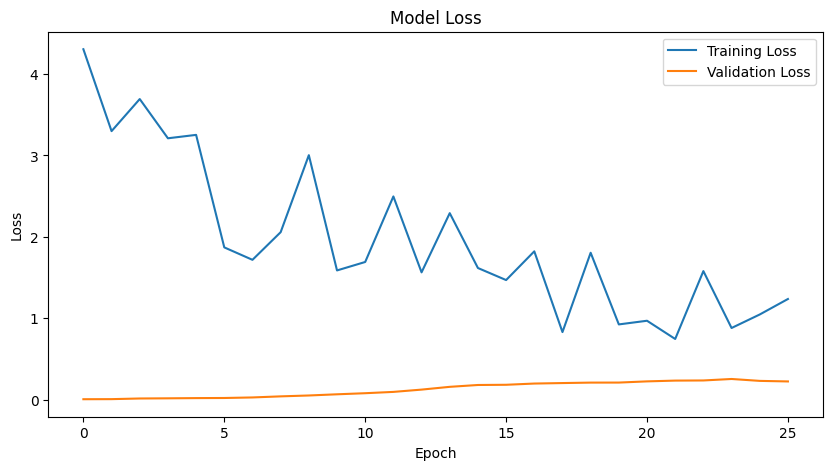

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Accuracy: 0.5779
Precision: 0.6198
Recall: 0.5682
F1-Score: 0.5929
RMSE: 0.054899


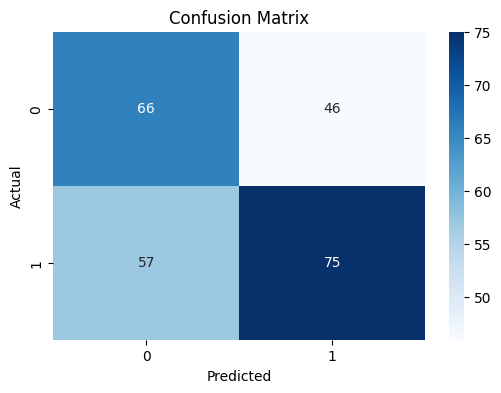

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[20/101] Training LIN ...
/--------------------------------------------------------------------/
LIN
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 1.5752 - mae: 0.9913 - val_loss: 0.0080 - val_mae: 0.0419 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0078 - mae: 0.7854 - val_loss: 0.0084 - val_mae: 0.0459 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8246 - mae: 0.7066 - val_loss: 0.0065 - val_mae: 0.0144 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5781 - mae: 0.5919 - val_loss: 0.0257 - val_mae: 0.1368 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5108 - mae: 0.5424 - val_loss: 0.0101 - val_mae: 0.0426 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3635 - mae: 0.4534

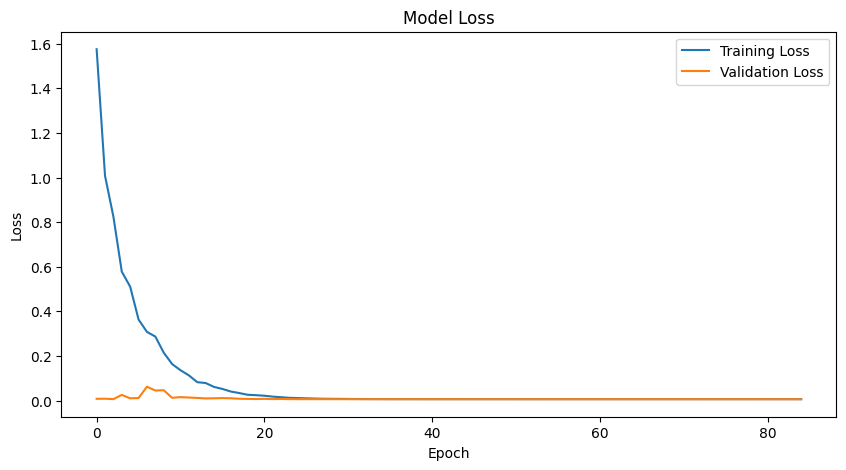

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Accuracy: 0.5082
Precision: 0.4874
Recall: 0.4957
F1-Score: 0.4915
RMSE: 0.009660


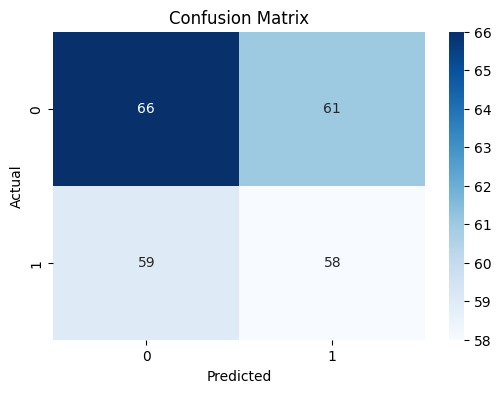

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[21/101] Training ORLY ...
/--------------------------------------------------------------------/
ORLY
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1.6116 - mae: 0.9789 - val_loss: 0.0560 - val_mae: 0.2228 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8778 - mae: 0.7314 - val_loss: 0.1256 - val_mae: 0.3452 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6728 - mae: 0.6369 - val_loss: 0.0724 - val_mae: 0.2546 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5162 - mae: 0.5525 - val_loss: 0.0404 - val_mae: 0.1827 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4498 - mae: 0.5129 - val_loss: 0.0162 - val_mae: 0.0899 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3565 - mae: 0.4550 

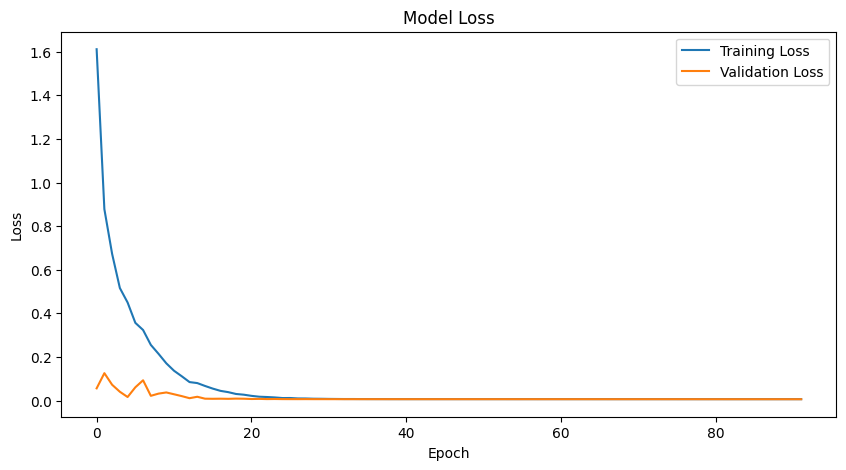

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Accuracy: 0.5164
Precision: 0.5118
Recall: 0.5372
F1-Score: 0.5242
RMSE: 0.012290


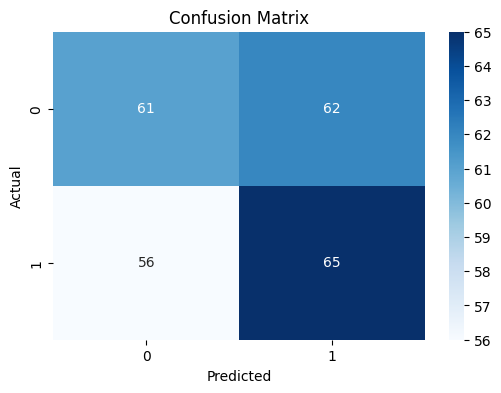

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[22/101] Training REGN ...
/--------------------------------------------------------------------/
REGN
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1.8263 - mae: 1.0479 - val_loss: 0.0435 - val_mae: 0.1928 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2510 - mae: 0.8705 - val_loss: 0.0097 - val_mae: 0.0574 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0176 - mae: 0.7784 - val_loss: 0.0220 - val_mae: 0.1242 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8446 - mae: 0.7328 - val_loss: 0.0284 - val_mae: 0.1468 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6963 - mae: 0.6402 - val_loss: 0.2667 - val_mae: 0.5095 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5014 - mae: 0.551

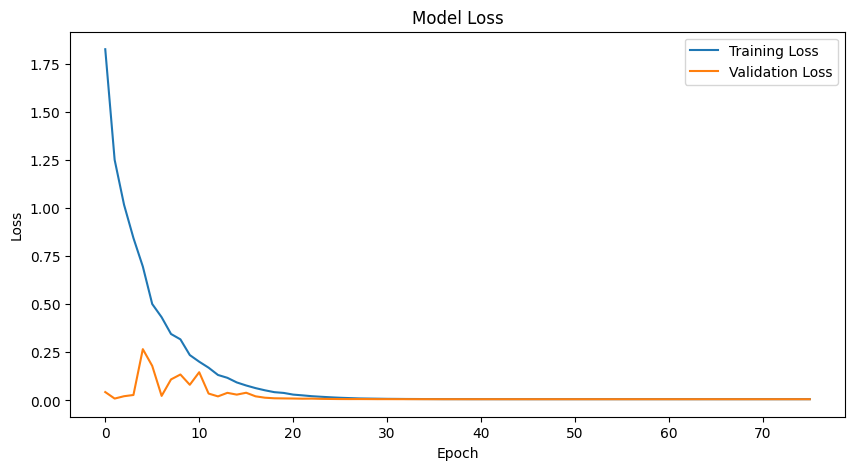

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Accuracy: 0.4631
Precision: 0.4483
Recall: 0.4370
F1-Score: 0.4426
RMSE: 0.014133


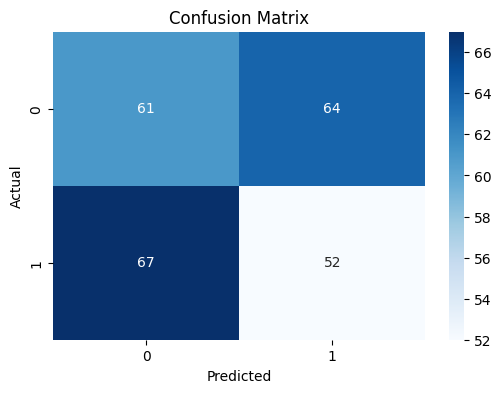

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[23/101] Training AVGO ...
/--------------------------------------------------------------------/
AVGO
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 2.0707 - mae: 1.0956 - val_loss: 0.0100 - val_mae: 0.0590 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0566 - mae: 0.7971 - val_loss: 0.0079 - val_mae: 0.0380 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8683 - mae: 0.7282 - val_loss: 0.0143 - val_mae: 0.0876 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6144 - mae: 0.6068 - val_loss: 0.0083 - val_mae: 0.0398 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4834 - mae: 0.5322 - val_loss: 0.0124 - val_mae: 0.0670 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4159 - mae: 0.5006 - 

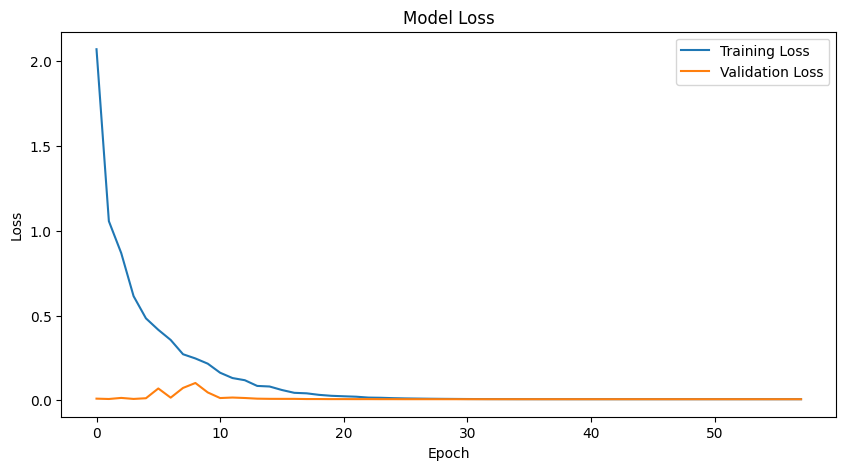

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Accuracy: 0.4713
Precision: 0.4754
Recall: 0.4715
F1-Score: 0.4735
RMSE: 0.033206


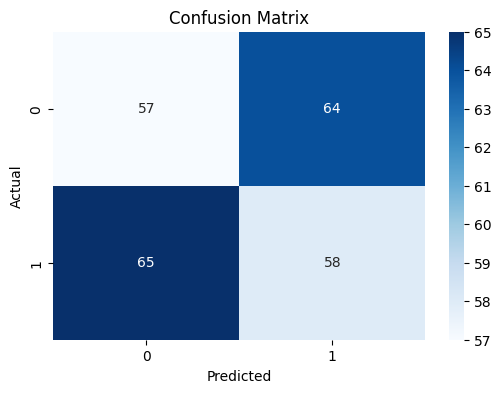

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[24/101] Training INTC ...
/--------------------------------------------------------------------/
INTC
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 2.4941 - mae: 1.2249 - val_loss: 0.1037 - val_mae: 0.3113 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3289 - mae: 0.9066 - val_loss: 0.0608 - val_mae: 0.2323 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9654 - mae: 0.7583 - val_loss: 0.1652 - val_mae: 0.3981 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7924 - mae: 0.6925 - val_loss: 0.2375 - val_mae: 0.4794 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6889 - mae: 0.6424 - val_loss: 0.3251 - val_mae: 0.5612 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5423 - mae: 0.5718 -

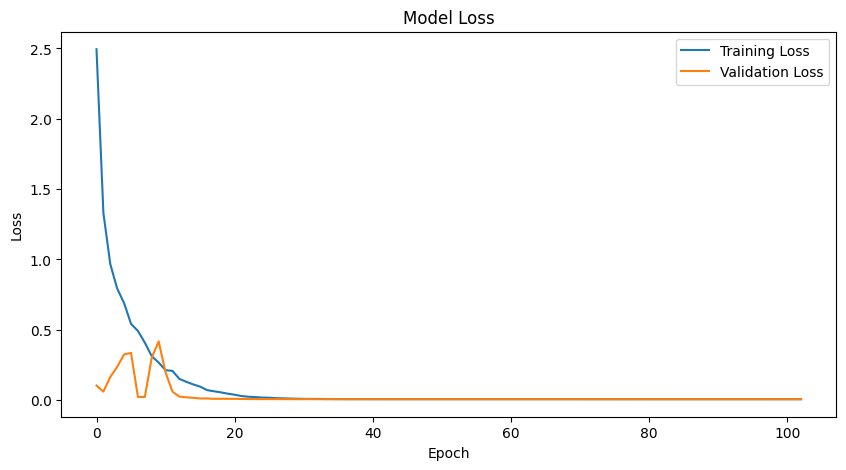

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Accuracy: 0.4754
Precision: 0.4597
Recall: 0.4831
F1-Score: 0.4711
RMSE: 0.035493


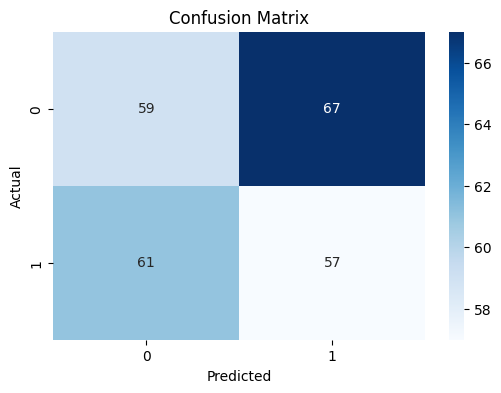

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[25/101] Training SBUX ...
/--------------------------------------------------------------------/
SBUX
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 1.5039 - mae: 0.9501 - val_loss: 0.0260 - val_mae: 0.1404 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8695 - mae: 0.7341 - val_loss: 0.0159 - val_mae: 0.0978 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6940 - mae: 0.6578 - val_loss: 0.0076 - val_mae: 0.0359 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5261 - mae: 0.5649 - val_loss: 0.0430 - val_mae: 0.1907 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3835 - mae: 0.4922 - val_loss: 0.0071 - val_mae: 0.0244 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3382 - mae: 0.446

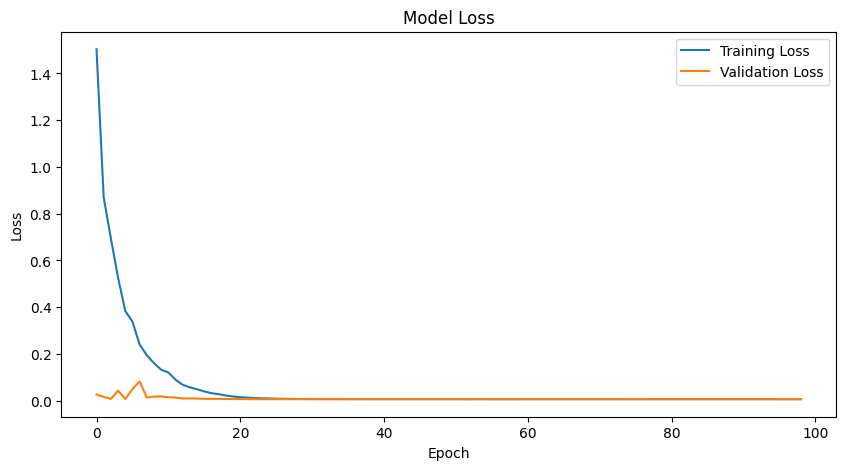

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Accuracy: 0.5082
Precision: 0.5242
Recall: 0.5159
F1-Score: 0.5200
RMSE: 0.023271


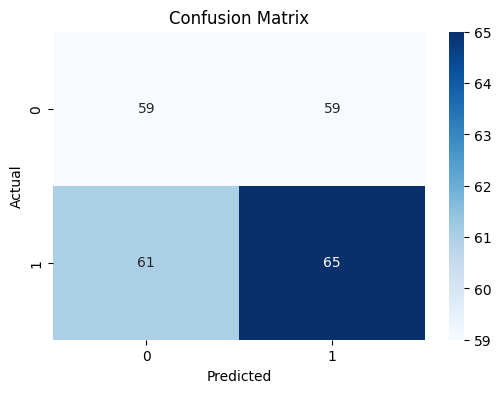

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[26/101] Training PDD ...
/--------------------------------------------------------------------/
PDD
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 2.0963 - mae: 1.1332 - val_loss: 0.0513 - val_mae: 0.2095 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0470 - mae: 0.8075 - val_loss: 0.0118 - val_mae: 0.0671 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8654 - mae: 0.7263 - val_loss: 0.0099 - val_mae: 0.0525 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6756 - mae: 0.6315 - val_loss: 0.0292 - val_mae: 0.1468 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5393 - mae: 0.5680 - val_loss: 0.0198 - val_mae: 0.0978 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4277 - mae: 0.5033 - va

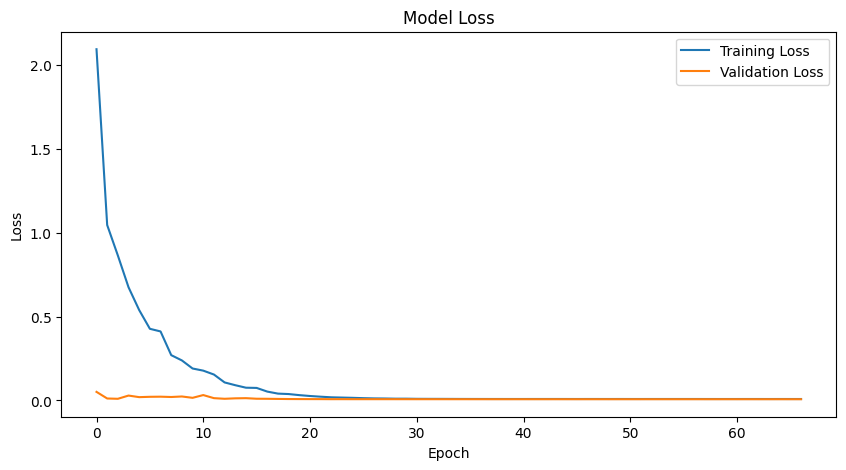

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Accuracy: 0.4877
Precision: 0.4882
Recall: 0.5082
F1-Score: 0.4980
RMSE: 0.037504


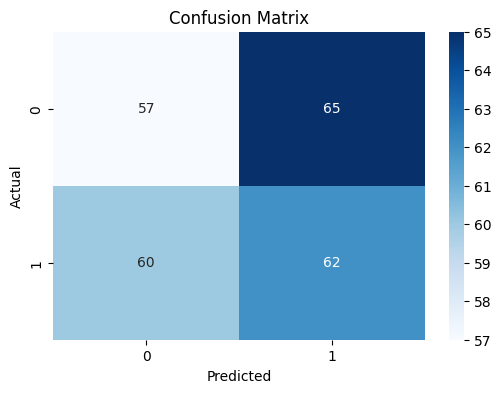

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[27/101] Training AMZN ...
/--------------------------------------------------------------------/
AMZN
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 2.2179 - mae: 1.1680 - val_loss: 0.0176 - val_mae: 0.1053 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2817 - mae: 0.8974 - val_loss: 0.0401 - val_mae: 0.1832 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9157 - mae: 0.7511 - val_loss: 0.0078 - val_mae: 0.0354 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7566 - mae: 0.6630 - val_loss: 0.0078 - val_mae: 0.0354 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5998 - mae: 0.5977 - val_loss: 0.0090 - val_mae: 0.0449 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4797 - mae: 0.5368 -

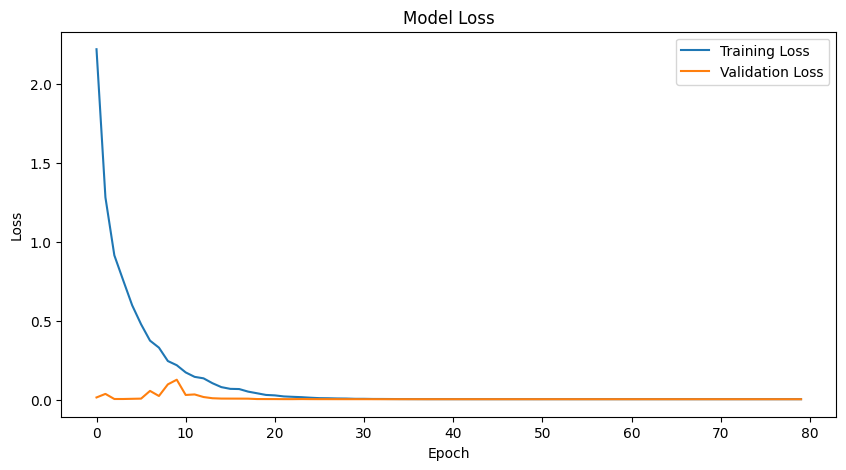

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
Accuracy: 0.4795
Precision: 0.4746
Recall: 0.4628
F1-Score: 0.4686
RMSE: 0.018972


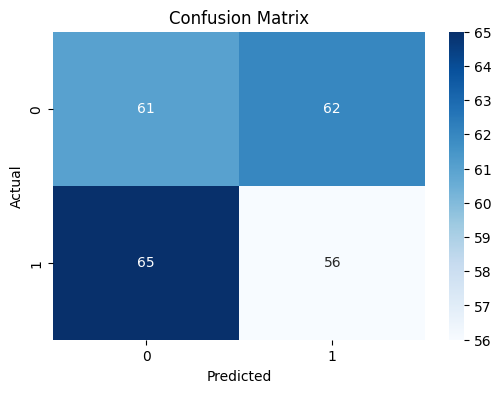

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[28/101] Training HON ...
/--------------------------------------------------------------------/
HON
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 1.8282 - mae: 1.0318 - val_loss: 0.0070 - val_mae: 0.0274 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0873 - mae: 0.8319 - val_loss: 0.0354 - val_mae: 0.1707 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7510 - mae: 0.6774 - val_loss: 0.1145 - val_mae: 0.3286 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5687 - mae: 0.5827 - val_loss: 0.0898 - val_mae: 0.2852 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4590 - mae: 0.5353 - val_loss: 0.0624 - val_mae: 0.2350 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3791 - mae: 0.4821 - va

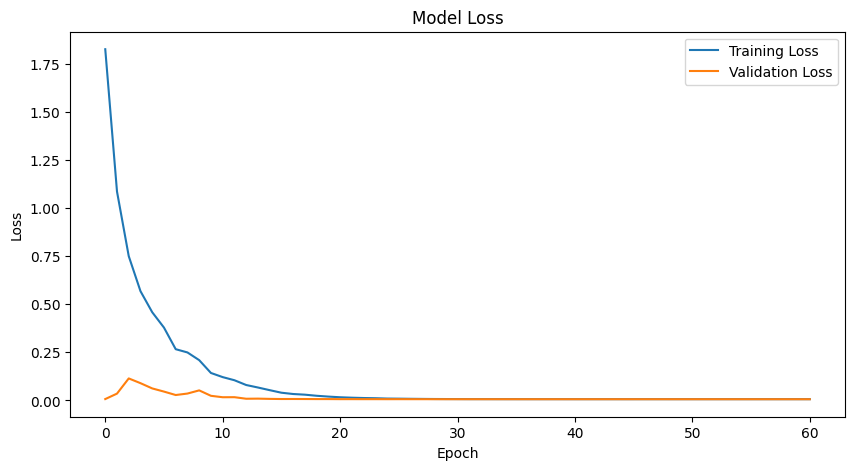

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
Accuracy: 0.4590
Precision: 0.4182
Recall: 0.4035
F1-Score: 0.4107
RMSE: 0.012660


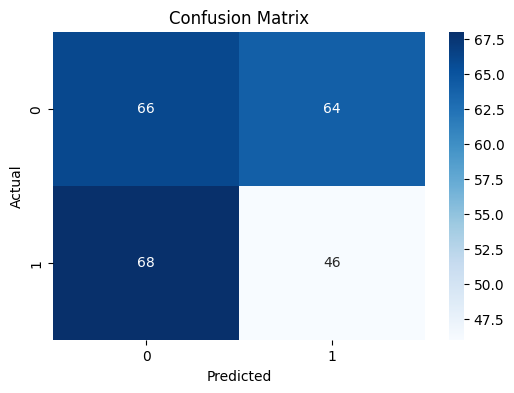

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[29/101] Training MRVL ...
/--------------------------------------------------------------------/
MRVL
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 1.8113 - mae: 1.0402 - val_loss: 0.0329 - val_mae: 0.1615 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9791 - mae: 0.7801 - val_loss: 0.0151 - val_mae: 0.0906 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8624 - mae: 0.7267 - val_loss: 0.1113 - val_mae: 0.3223 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6357 - mae: 0.6153 - val_loss: 0.0398 - val_mae: 0.1791 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4927 - mae: 0.5512 - val_loss: 0.2002 - val_mae: 0.4369 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3766 - mae: 0.4660 

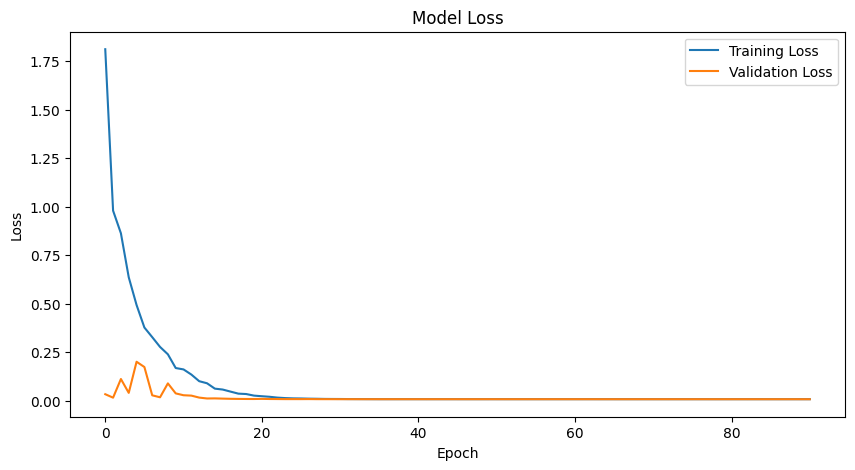

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Accuracy: 0.5574
Precision: 0.5556
Recall: 0.5738
F1-Score: 0.5645
RMSE: 0.035581


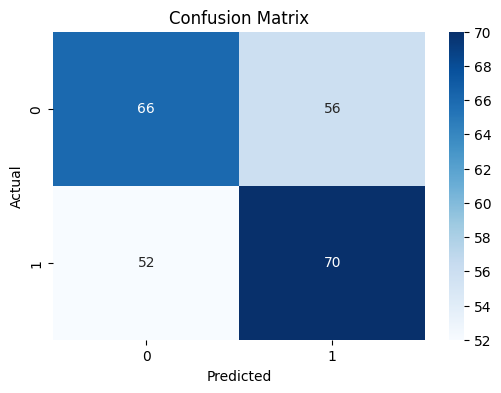

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[30/101] Training PYPL ...
/--------------------------------------------------------------------/
PYPL
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1.8685 - mae: 1.0775 - val_loss: 0.0073 - val_mae: 0.0256 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0793 - mae: 0.8139 - val_loss: 0.0350 - val_mae: 0.1679 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8391 - mae: 0.7169 - val_loss: 0.0081 - val_mae: 0.0362 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7490 - mae: 0.6770 - val_loss: 0.0836 - val_mae: 0.2768 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5527 - mae: 0.5733 - val_loss: 0.0531 - val_mae: 0.2063 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4132 - mae: 0.5139 -

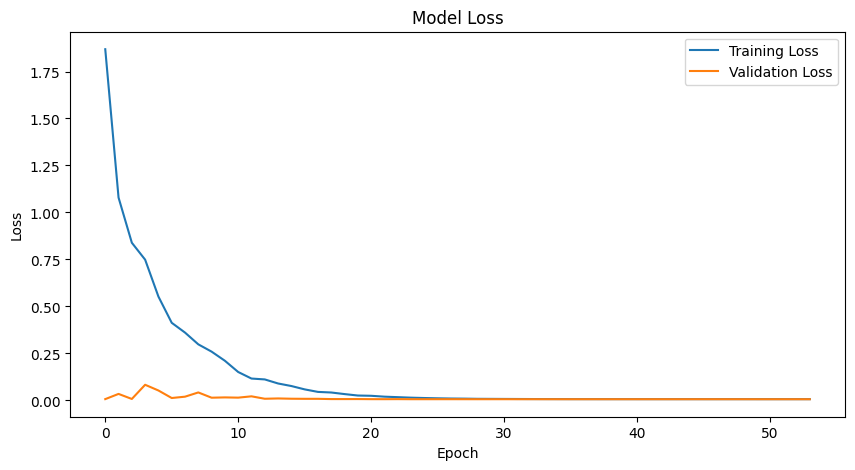

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Accuracy: 0.4549
Precision: 0.4274
Recall: 0.4310
F1-Score: 0.4292
RMSE: 0.023798


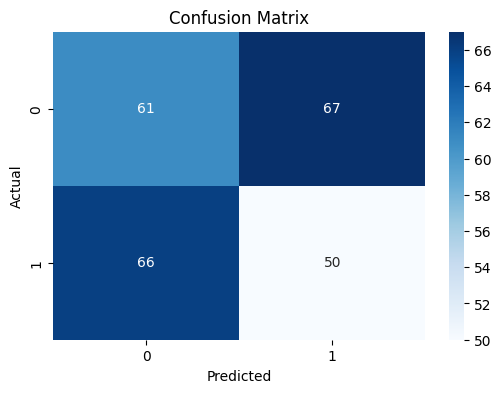

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[31/101] Training MSFT ...
/--------------------------------------------------------------------/
MSFT
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 2.0734 - mae: 1.1147 - val_loss: 0.0183 - val_mae: 0.1091 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.3467 - mae: 0.8858 - val_loss: 0.0088 - val_mae: 0.0490 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8986 - mae: 0.7346 - val_loss: 0.0092 - val_mae: 0.0509 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6282 - mae: 0.6118 - val_loss: 0.0106 - val_mae: 0.0628 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5305 - mae: 0.5674 - val_loss: 0.0269 - val_mae: 0.1252 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4586 - mae: 0.52

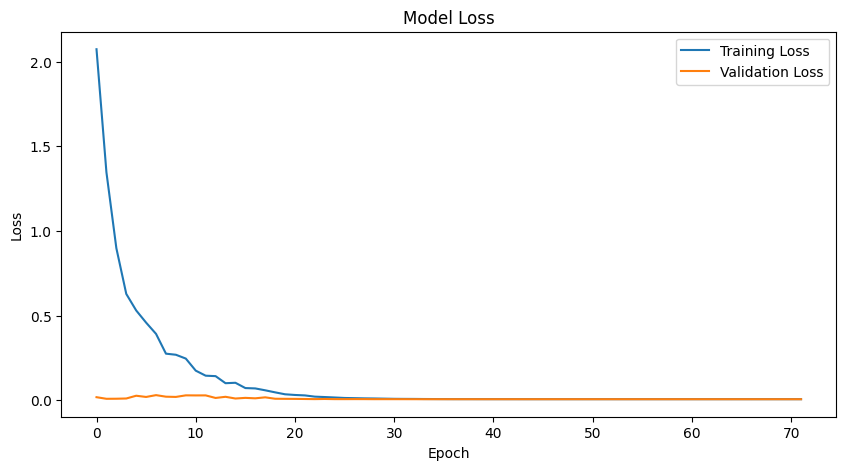

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Accuracy: 0.4508
Precision: 0.4409
Recall: 0.4706
F1-Score: 0.4553
RMSE: 0.012739


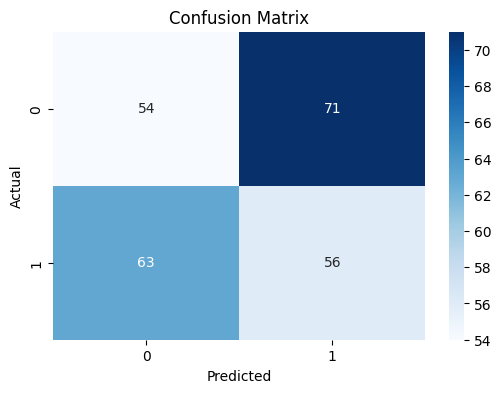

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[32/101] Training CHTR ...
/--------------------------------------------------------------------/
CHTR
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 1.7930 - mae: 1.0446 - val_loss: 0.0106 - val_mae: 0.0635 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1946 - mae: 0.8358 - val_loss: 0.0124 - val_mae: 0.0758 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.9011 - mae: 0.7432 - val_loss: 0.0995 - val_mae: 0.3048 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7159 - mae: 0.6456 - val_loss: 0.1272 - val_mae: 0.3470 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5523 - mae: 0.5664 - val_loss: 0.0734 - val_mae: 0.2499 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4602 - mae: 0.52

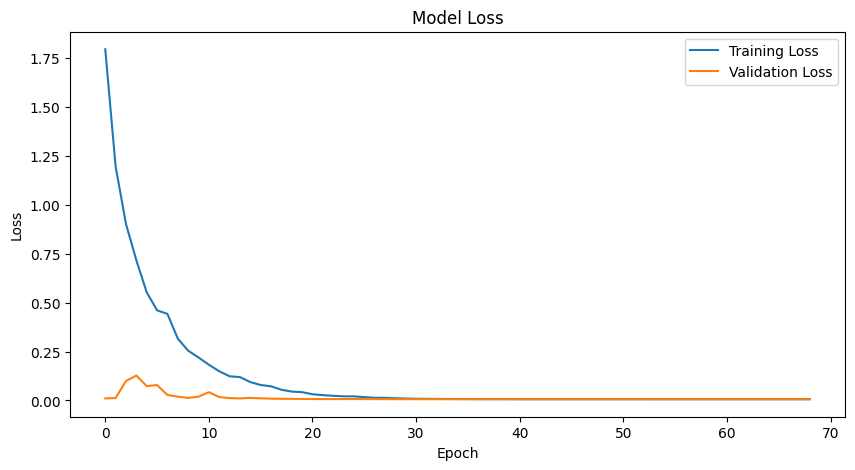

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Accuracy: 0.4467
Precision: 0.4672
Recall: 0.4488
F1-Score: 0.4578
RMSE: 0.025946


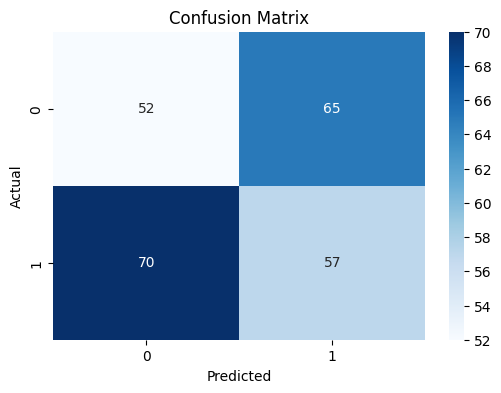

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[33/101] Training LRCX ...
/--------------------------------------------------------------------/
LRCX
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 2.0549 - mae: 1.0966 - val_loss: 0.0070 - val_mae: 0.0249 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1506 - mae: 0.8163 - val_loss: 0.0078 - val_mae: 0.0359 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8312 - mae: 0.7200 - val_loss: 0.0103 - val_mae: 0.0604 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6600 - mae: 0.6194 - val_loss: 0.0092 - val_mae: 0.0499 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4905 - mae: 0.5407 - val_loss: 0.0425 - val_mae: 0.1843 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4066 - mae: 0.494

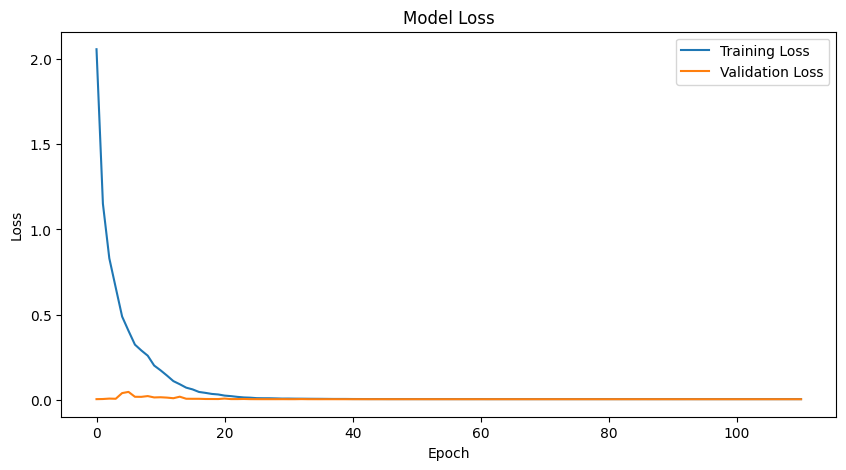

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
Accuracy: 0.5000
Precision: 0.5081
Recall: 0.5081
F1-Score: 0.5081
RMSE: 0.027525


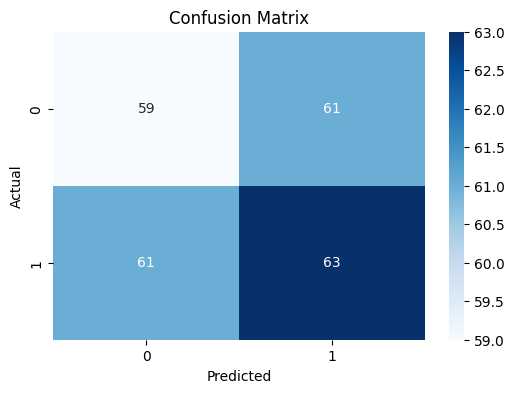

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[34/101] Training GILD ...
/--------------------------------------------------------------------/
GILD
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 2.1841 - mae: 1.1465 - val_loss: 0.0091 - val_mae: 0.0530 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2608 - mae: 0.8697 - val_loss: 0.0239 - val_mae: 0.1325 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9714 - mae: 0.7823 - val_loss: 0.0388 - val_mae: 0.1801 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8096 - mae: 0.7031 - val_loss: 0.1081 - val_mae: 0.3171 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5858 - mae: 0.5916 - val_loss: 0.1395 - val_mae: 0.3632 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5552 - mae: 0.5553 -

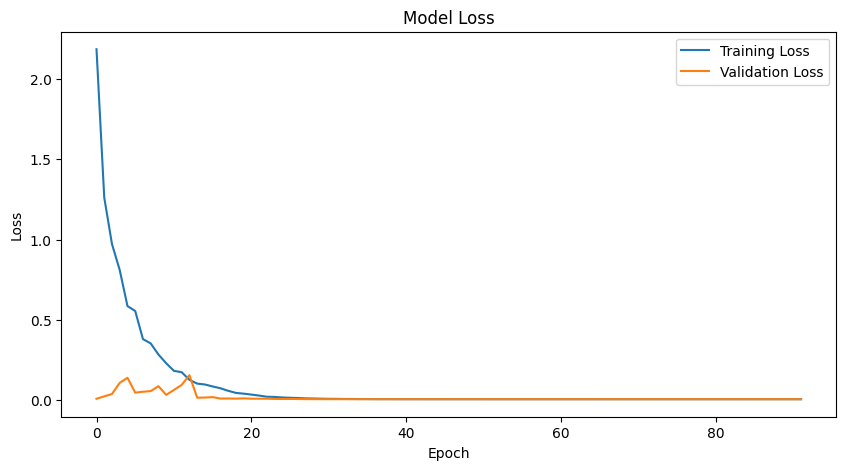

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
Accuracy: 0.5205
Precision: 0.5271
Recall: 0.5484
F1-Score: 0.5375
RMSE: 0.015837


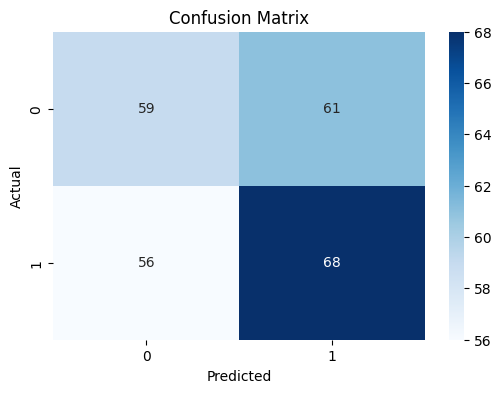

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[35/101] Training KDP ...
/--------------------------------------------------------------------/
KDP
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1.4282 - mae: 0.9392 - val_loss: 0.0088 - val_mae: 0.0501 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0740 - mae: 0.8144 - val_loss: 0.0464 - val_mae: 0.2001 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7311 - mae: 0.6650 - val_loss: 0.0071 - val_mae: 0.0271 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6308 - mae: 0.6210 - val_loss: 0.0749 - val_mae: 0.2614 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5327 - mae: 0.5727 - val_loss: 0.1123 - val_mae: 0.3232 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4104 - mae: 0.4985 - va

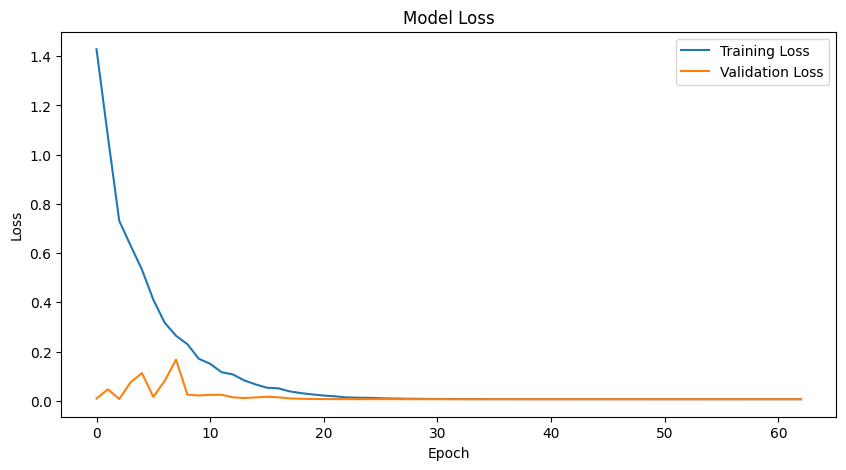

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Accuracy: 0.4303
Precision: 0.4365
Recall: 0.4472
F1-Score: 0.4418
RMSE: 0.011674


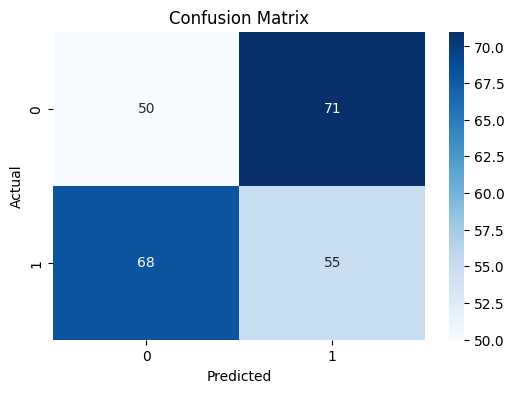

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[36/101] Training QCOM ...
/--------------------------------------------------------------------/
QCOM
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 2.2236 - mae: 1.1689 - val_loss: 0.0066 - val_mae: 0.0140 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.2920 - mae: 0.8919 - val_loss: 0.0078 - val_mae: 0.0349 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9560 - mae: 0.7792 - val_loss: 0.0287 - val_mae: 0.1465 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7570 - mae: 0.6955 - val_loss: 0.0512 - val_mae: 0.2103 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5371 - mae: 0.5671 - val_loss: 0.0192 - val_mae: 0.1042 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5059 - mae: 0.55

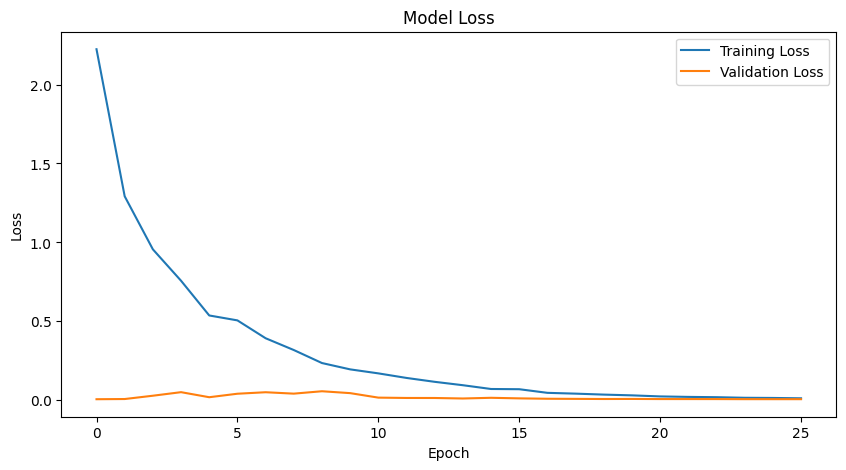

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Accuracy: 0.5246
Precision: 0.5492
Recall: 0.5234
F1-Score: 0.5360
RMSE: 0.024471


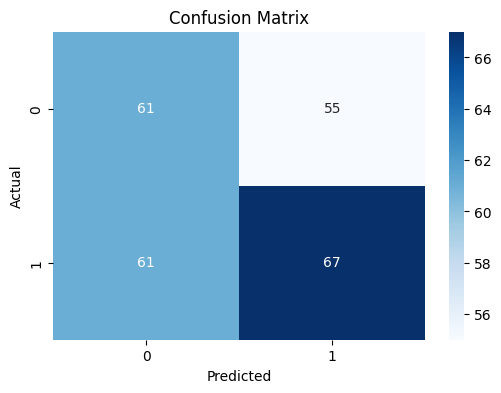

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[37/101] Training GEHC ...
/--------------------------------------------------------------------/
GEHC
/--------------------------------------------------------------------/
Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - loss: 1.6648 - mae: 1.0182 - val_loss: 0.0124 - val_mae: 0.0769 - learning_rate: 0.0010
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4992 - mae: 1.0073 - val_loss: 0.0316 - val_mae: 0.1587 - learning_rate: 0.0010
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2819 - mae: 0.9145 - val_loss: 0.0215 - val_mae: 0.1226 - learning_rate: 0.0010
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1374 - mae: 0.8444 - val_loss: 0.0312 - val_mae: 0.1570 - learning_rate: 0.0010
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9916 - mae: 0.8083 - val_loss: 0.0200 - val_mae: 0.1162 - learning_rate: 0.0010
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9566 - mae: 0.7

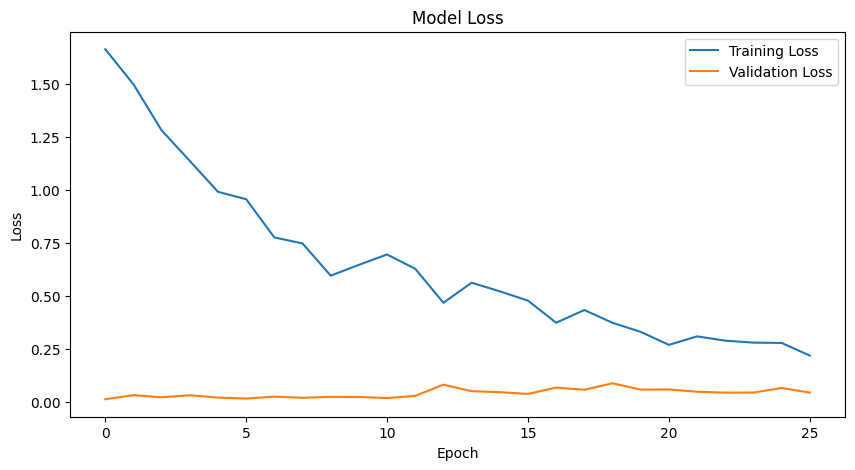

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Accuracy: 0.4713
Precision: 0.4274
Recall: 0.4464
F1-Score: 0.4367
RMSE: 0.076168


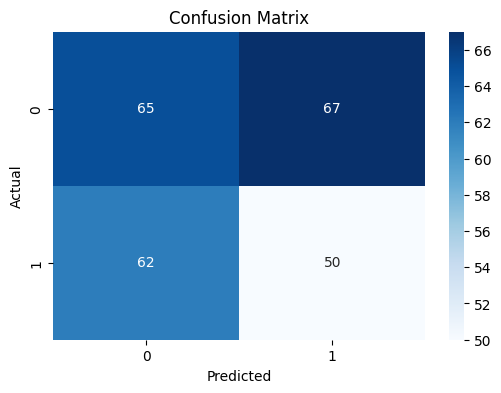

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[38/101] Training CMCSA ...
/--------------------------------------------------------------------/
CMCSA
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 2.1943 - mae: 1.1663 - val_loss: 0.0077 - val_mae: 0.0370 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2198 - mae: 0.8676 - val_loss: 0.0094 - val_mae: 0.0558 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9154 - mae: 0.7371 - val_loss: 0.0271 - val_mae: 0.1437 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7964 - mae: 0.6916 - val_loss: 0.1107 - val_mae: 0.3213 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6504 - mae: 0.6169 - val_loss: 0.1181 - val_mae: 0.3205 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5471 - mae: 0.573

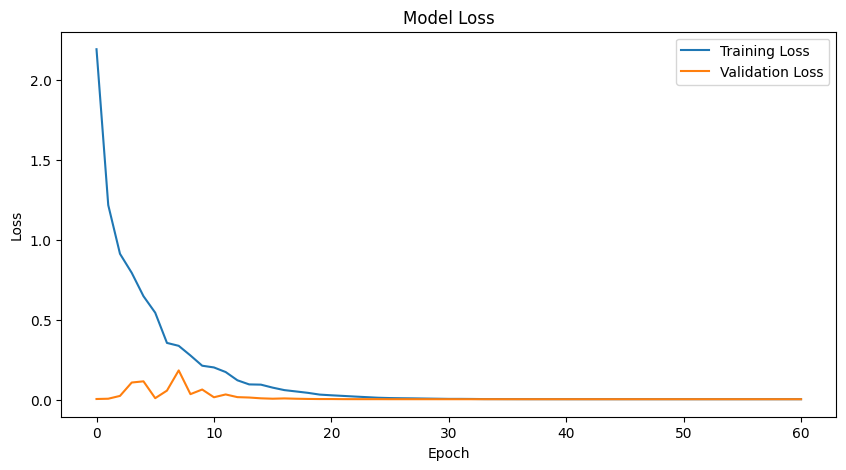

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Accuracy: 0.4836
Precision: 0.4530
Recall: 0.4609
F1-Score: 0.4569
RMSE: 0.015793


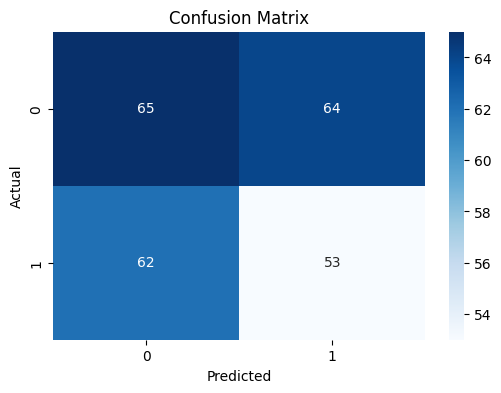

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[39/101] Training ANSS ...
/--------------------------------------------------------------------/
ANSS
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 2.5327 - mae: 1.2347 - val_loss: 0.0087 - val_mae: 0.0465 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.2574 - mae: 0.8649 - val_loss: 0.0158 - val_mae: 0.0961 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9830 - mae: 0.7801 - val_loss: 0.0413 - val_mae: 0.1859 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.8428 - mae: 0.7167 - val_loss: 0.0291 - val_mae: 0.1076 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6542 - mae: 0.6207 - val_loss: 0.1841 - val_mae: 0.3905 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5787 - mae: 0.58

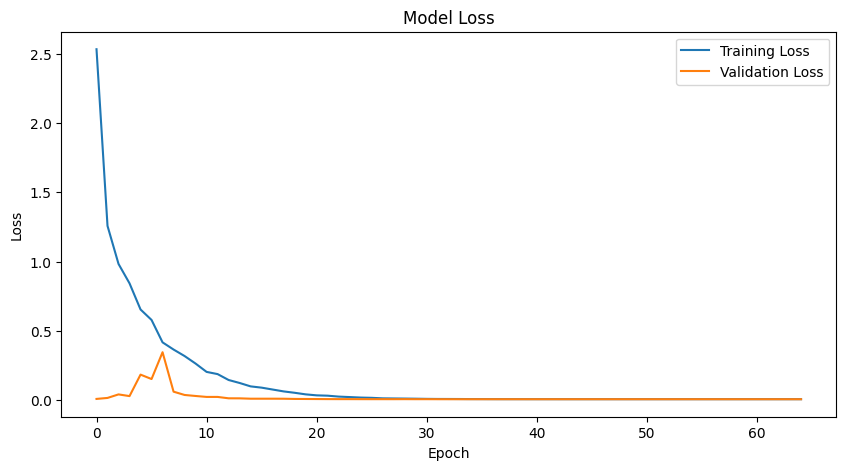

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
Accuracy: 0.4836
Precision: 0.4583
Recall: 0.4741
F1-Score: 0.4661
RMSE: 0.015387


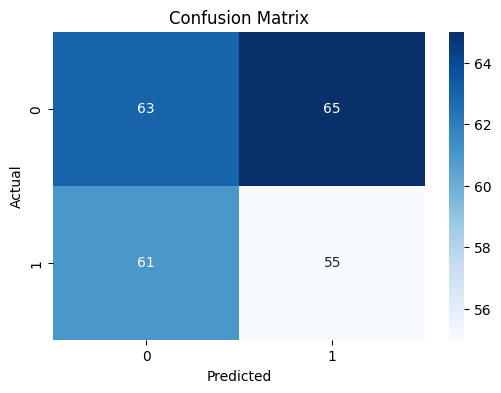

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[40/101] Training AAPL ...
/--------------------------------------------------------------------/
AAPL
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1.8339 - mae: 1.0496 - val_loss: 0.0063 - val_mae: 0.0099 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8518 - mae: 0.7258 - val_loss: 0.0250 - val_mae: 0.1368 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6351 - mae: 0.6162 - val_loss: 0.0065 - val_mae: 0.0138 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5302 - mae: 0.5655 - val_loss: 0.0229 - val_mae: 0.1285 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.4595 - mae: 0.5199 - val_loss: 0.0795 - val_mae: 0.2643 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3768 - mae: 0.4781 -

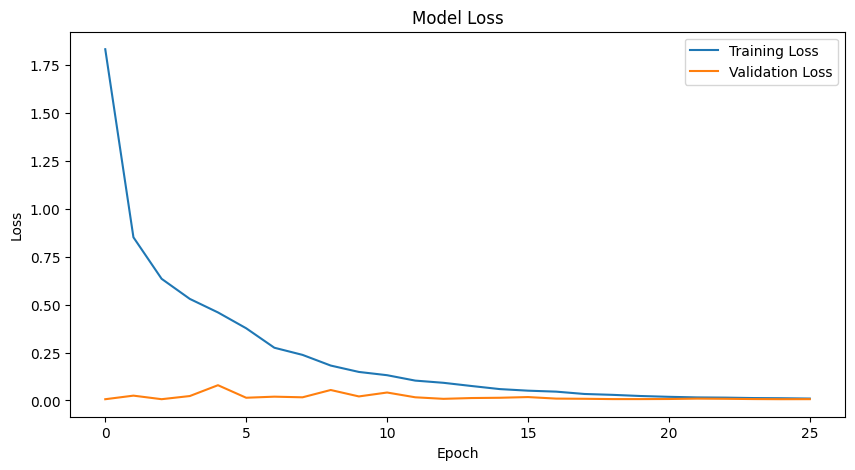

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Accuracy: 0.5164
Precision: 0.5135
Recall: 0.4711
F1-Score: 0.4914
RMSE: 0.014842


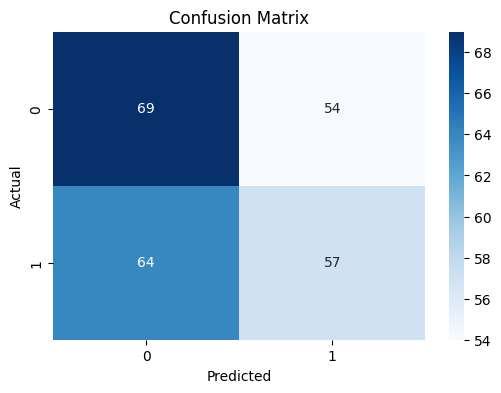

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[41/101] Training EA ...
/--------------------------------------------------------------------/
EA
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 1.9514 - mae: 1.0951 - val_loss: 0.0541 - val_mae: 0.2187 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3094 - mae: 0.8886 - val_loss: 0.0503 - val_mae: 0.2083 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8843 - mae: 0.7410 - val_loss: 0.0236 - val_mae: 0.1273 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6976 - mae: 0.6598 - val_loss: 0.0911 - val_mae: 0.2904 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6202 - mae: 0.6100 - val_loss: 0.0365 - val_mae: 0.1356 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4456 - mae: 0.5189 - va

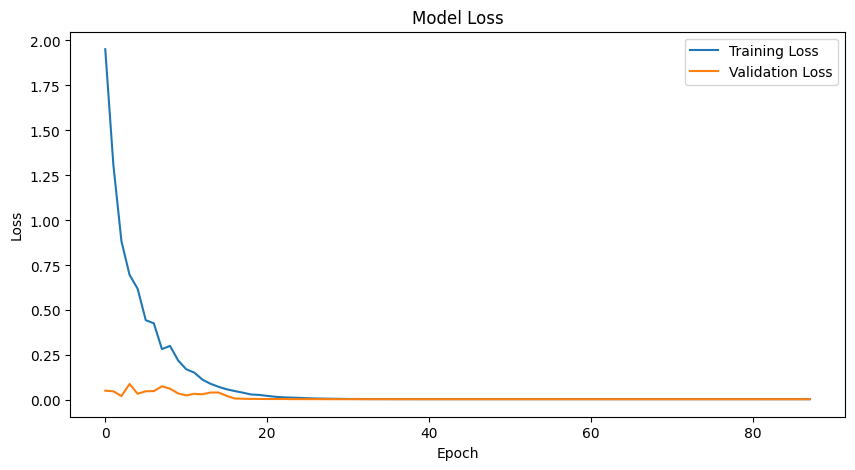

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Accuracy: 0.5410
Precision: 0.5200
Recall: 0.5556
F1-Score: 0.5372
RMSE: 0.011692


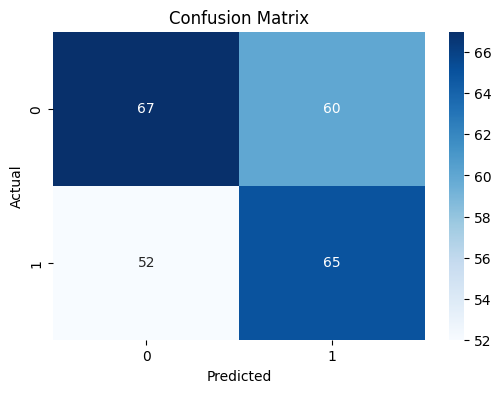

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[42/101] Training MNST ...
/--------------------------------------------------------------------/
MNST
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 2.1671 - mae: 1.1627 - val_loss: 0.0121 - val_mae: 0.0761 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0897 - mae: 0.8271 - val_loss: 0.0119 - val_mae: 0.0749 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8958 - mae: 0.7345 - val_loss: 0.0546 - val_mae: 0.2187 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7060 - mae: 0.6536 - val_loss: 0.3458 - val_mae: 0.5822 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4953 - mae: 0.5442 - val_loss: 0.2022 - val_mae: 0.4406 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4090 - mae: 0.4893 - v

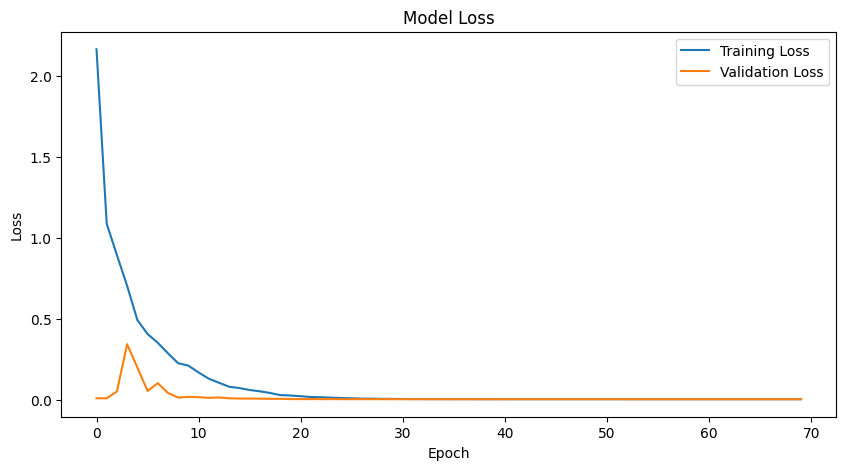

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Accuracy: 0.4754
Precision: 0.4706
Recall: 0.4628
F1-Score: 0.4667
RMSE: 0.016744


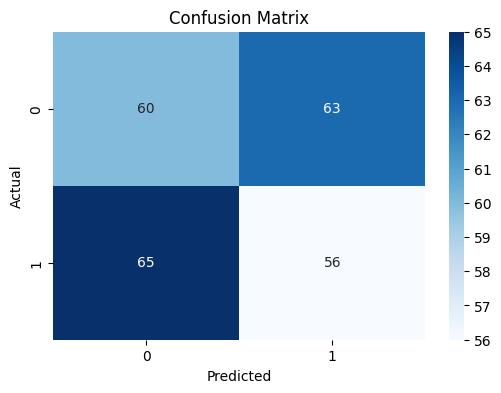

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[43/101] Training WDAY ...
/--------------------------------------------------------------------/
WDAY
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 1.6924 - mae: 1.0314 - val_loss: 0.0153 - val_mae: 0.0939 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0787 - mae: 0.8279 - val_loss: 0.0404 - val_mae: 0.1837 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7655 - mae: 0.6899 - val_loss: 0.0379 - val_mae: 0.1768 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5552 - mae: 0.5909 - val_loss: 0.0387 - val_mae: 0.1777 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3807 - mae: 0.4895 - val_loss: 0.0094 - val_mae: 0.0505 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3441 - mae: 0.4563 - v

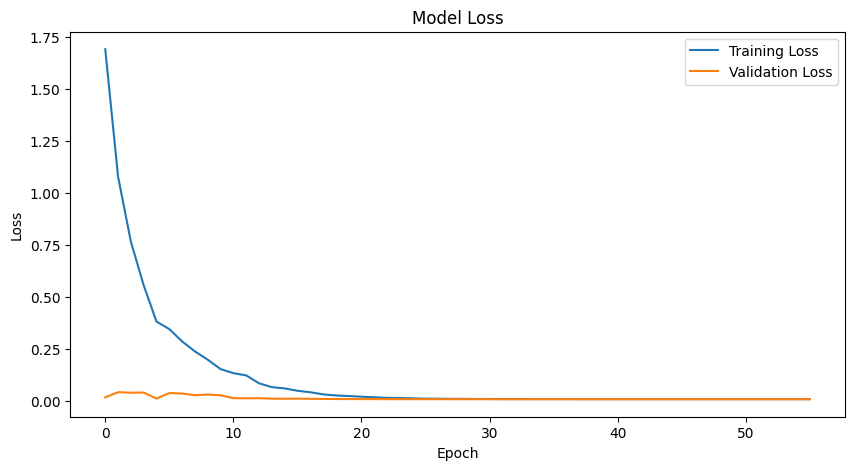

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Accuracy: 0.5451
Precision: 0.5500
Recall: 0.5366
F1-Score: 0.5432
RMSE: 0.021392


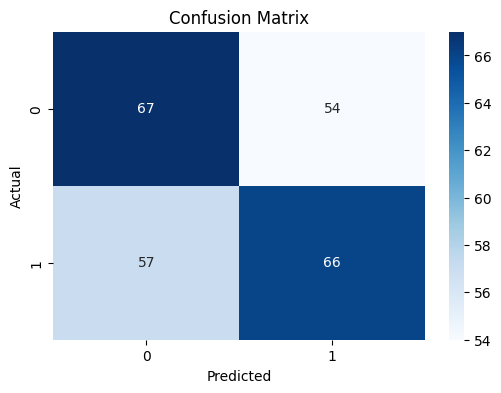

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[44/101] Training IDXX ...
/--------------------------------------------------------------------/
IDXX
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 1.6266 - mae: 1.0049 - val_loss: 0.0186 - val_mae: 0.1100 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8756 - mae: 0.7270 - val_loss: 0.1251 - val_mae: 0.3429 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6918 - mae: 0.6414 - val_loss: 0.0202 - val_mae: 0.1065 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5694 - mae: 0.5883 - val_loss: 0.0118 - val_mae: 0.0717 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4370 - mae: 0.5157 - val_loss: 0.0204 - val_mae: 0.1116 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3589 - mae: 0.4617 - v

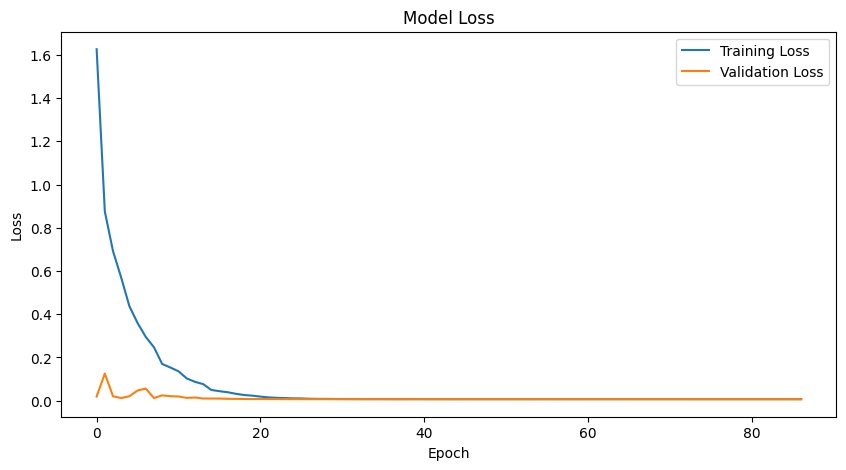

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Accuracy: 0.4959
Precision: 0.4706
Recall: 0.4828
F1-Score: 0.4766
RMSE: 0.017690


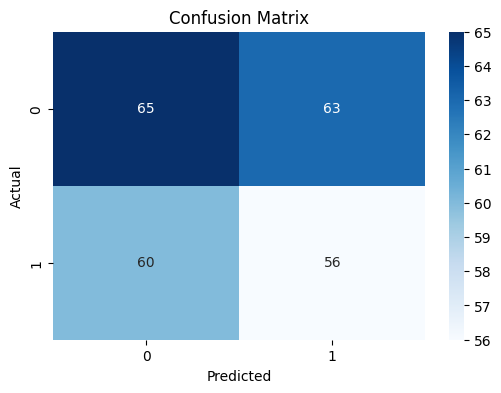

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[45/101] Training TEAM ...
/--------------------------------------------------------------------/
TEAM
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 2.5038 - mae: 1.2166 - val_loss: 0.0303 - val_mae: 0.1522 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2776 - mae: 0.8817 - val_loss: 0.1486 - val_mae: 0.3760 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9125 - mae: 0.7557 - val_loss: 0.2357 - val_mae: 0.4776 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8169 - mae: 0.7012 - val_loss: 0.1648 - val_mae: 0.3834 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6103 - mae: 0.5959 - val_loss: 0.1191 - val_mae: 0.3242 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4883 - mae: 0.5353 - 

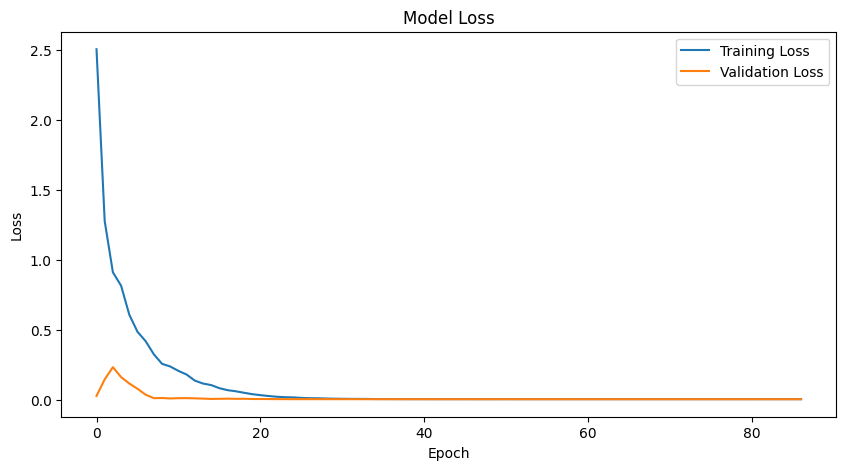

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Accuracy: 0.4795
Precision: 0.4872
Recall: 0.4597
F1-Score: 0.4730
RMSE: 0.030123


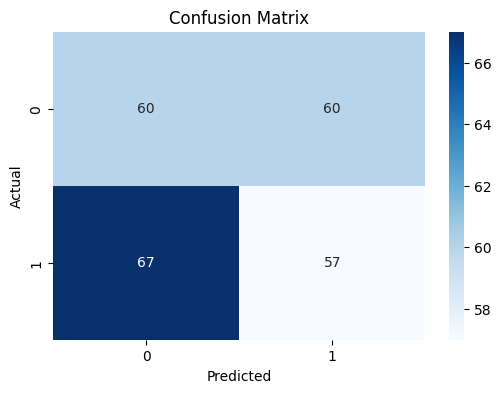

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[46/101] Training SNPS ...
/--------------------------------------------------------------------/
SNPS
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 1.6865 - mae: 1.0002 - val_loss: 0.0303 - val_mae: 0.1543 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9260 - mae: 0.7513 - val_loss: 0.0264 - val_mae: 0.1408 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7956 - mae: 0.6990 - val_loss: 0.1897 - val_mae: 0.4277 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6261 - mae: 0.6252 - val_loss: 0.1660 - val_mae: 0.3906 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4956 - mae: 0.5626 - val_loss: 0.0318 - val_mae: 0.1462 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4256 - mae: 0.5179 - 

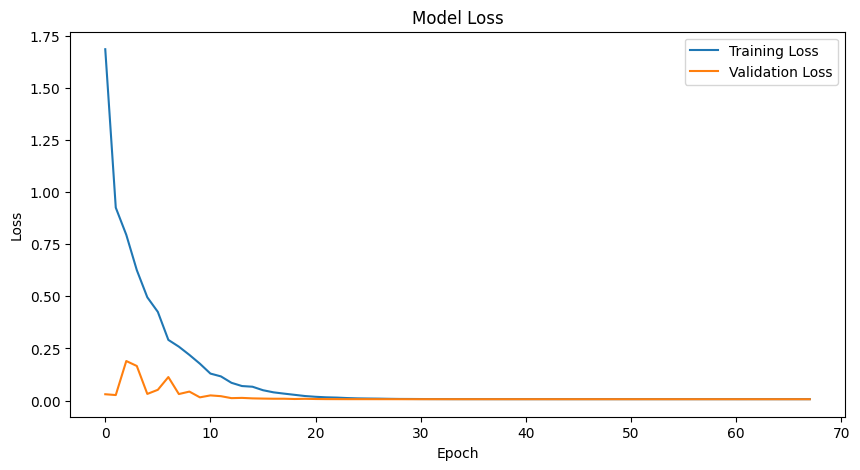

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Accuracy: 0.4754
Precision: 0.4576
Recall: 0.4576
F1-Score: 0.4576
RMSE: 0.023814


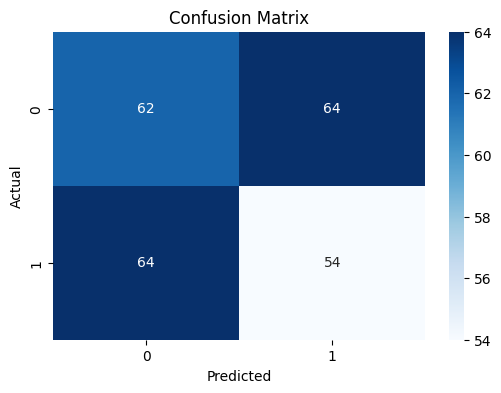

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[47/101] Training VRSK ...
/--------------------------------------------------------------------/
VRSK
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 2.0180 - mae: 1.1113 - val_loss: 0.0179 - val_mae: 0.1074 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0549 - mae: 0.8138 - val_loss: 0.0100 - val_mae: 0.0603 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7428 - mae: 0.6826 - val_loss: 0.1051 - val_mae: 0.3141 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6757 - mae: 0.6315 - val_loss: 0.1005 - val_mae: 0.2764 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5093 - mae: 0.5683 - val_loss: 0.0759 - val_mae: 0.2566 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4359 - mae: 0.5092 -

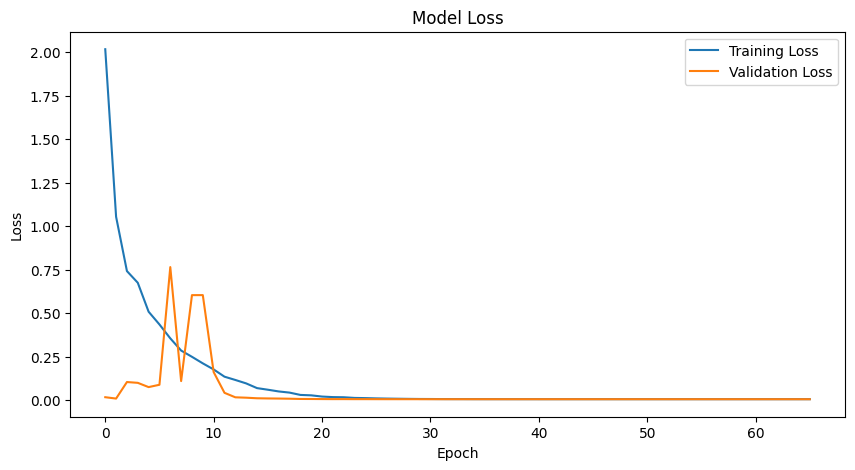

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Accuracy: 0.5205
Precision: 0.5234
Recall: 0.5447
F1-Score: 0.5339
RMSE: 0.012304


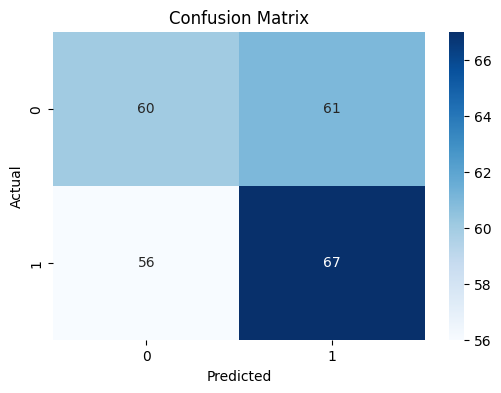

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[48/101] Training AMD ...
/--------------------------------------------------------------------/
AMD
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 1.4456 - mae: 0.9499 - val_loss: 0.0072 - val_mae: 0.0242 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8546 - mae: 0.7209 - val_loss: 0.0143 - val_mae: 0.0857 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6725 - mae: 0.6525 - val_loss: 0.0220 - val_mae: 0.1225 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4890 - mae: 0.5498 - val_loss: 0.0159 - val_mae: 0.0909 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3751 - mae: 0.4756 - val_loss: 0.0170 - val_mae: 0.0946 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3219 - mae: 0.4573 - val

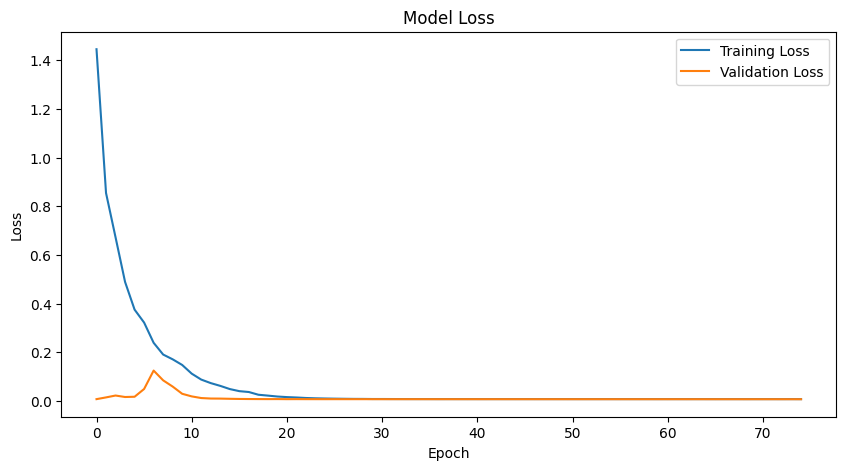

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Accuracy: 0.5164
Precision: 0.5349
Recall: 0.5433
F1-Score: 0.5391
RMSE: 0.030399


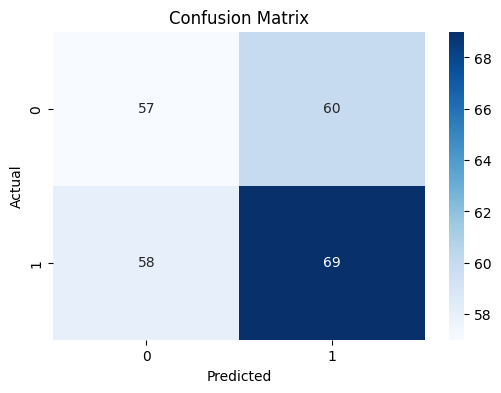

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[49/101] Training CTSH ...
/--------------------------------------------------------------------/
CTSH
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 1.9020 - mae: 1.0846 - val_loss: 0.0105 - val_mae: 0.0643 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2497 - mae: 0.8784 - val_loss: 0.0081 - val_mae: 0.0429 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8730 - mae: 0.7288 - val_loss: 0.0328 - val_mae: 0.1623 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7417 - mae: 0.6545 - val_loss: 0.1561 - val_mae: 0.3867 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5735 - mae: 0.5906 - val_loss: 0.0279 - val_mae: 0.1383 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4716 - mae: 0.5280 - 

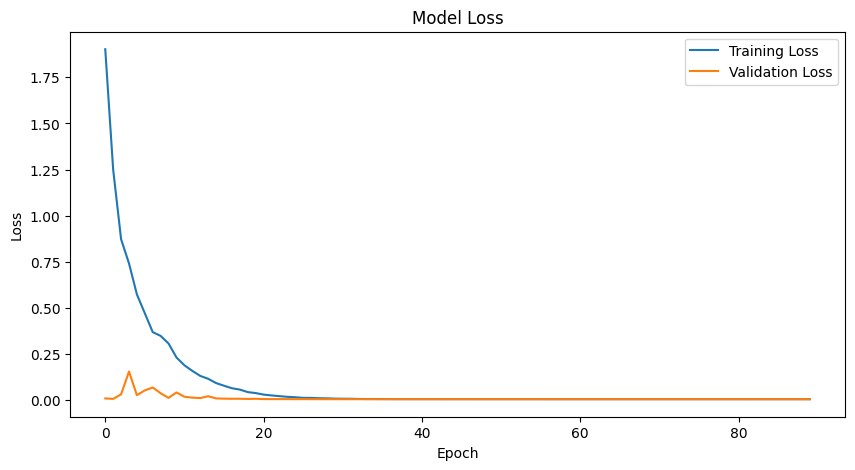

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step
Accuracy: 0.5082
Precision: 0.5191
Recall: 0.5440
F1-Score: 0.5312
RMSE: 0.013957


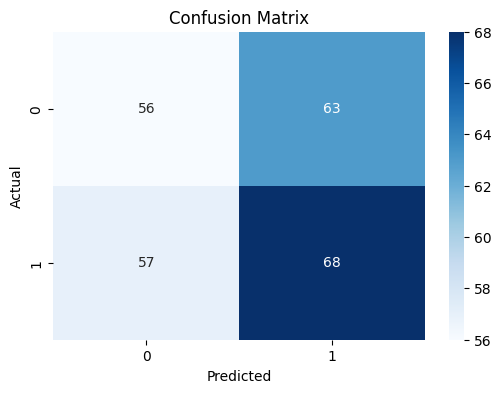

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[50/101] Training AMAT ...
/--------------------------------------------------------------------/
AMAT
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 1.4243 - mae: 0.9306 - val_loss: 0.0649 - val_mae: 0.2415 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8927 - mae: 0.7468 - val_loss: 0.1311 - val_mae: 0.3528 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7489 - mae: 0.6668 - val_loss: 0.1214 - val_mae: 0.3378 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5662 - mae: 0.5906 - val_loss: 0.0372 - val_mae: 0.1728 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4185 - mae: 0.4907 - val_loss: 0.0275 - val_mae: 0.1444 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3345 - mae: 0.4478 -

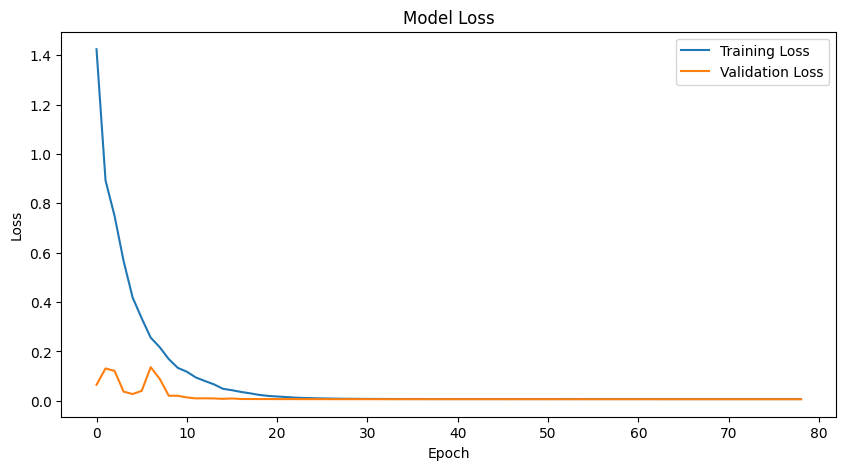

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
Accuracy: 0.5123
Precision: 0.5328
Recall: 0.5118
F1-Score: 0.5221
RMSE: 0.027332


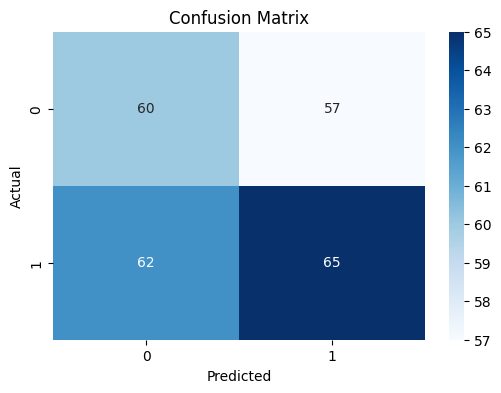

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[51/101] Training AXON ...
/--------------------------------------------------------------------/
AXON
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 1.2157 - mae: 0.8478 - val_loss: 0.0076 - val_mae: 0.0316 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8288 - mae: 0.6909 - val_loss: 0.0076 - val_mae: 0.0298 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6416 - mae: 0.5954 - val_loss: 0.0075 - val_mae: 0.0304 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4887 - mae: 0.5318 - val_loss: 0.0135 - val_mae: 0.0721 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3888 - mae: 0.4577 - val_loss: 0.0190 - val_mae: 0.1033 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3139 - mae: 0.4095 - 

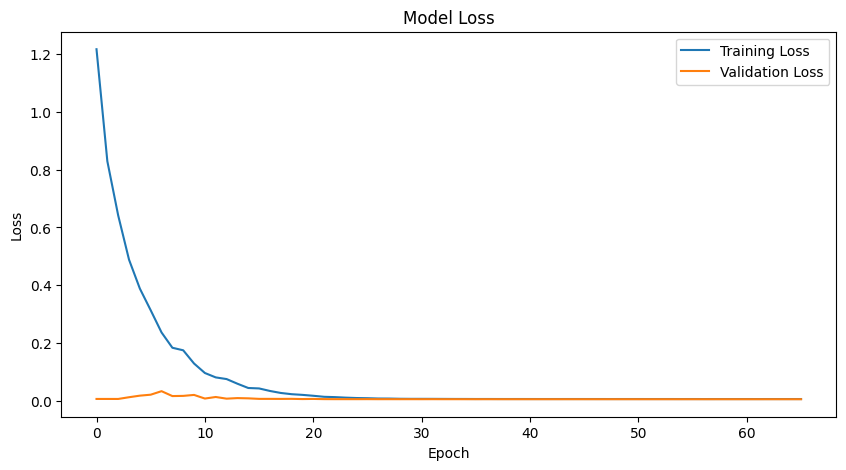

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
Accuracy: 0.5123
Precision: 0.5152
Recall: 0.5528
F1-Score: 0.5333
RMSE: 0.027236


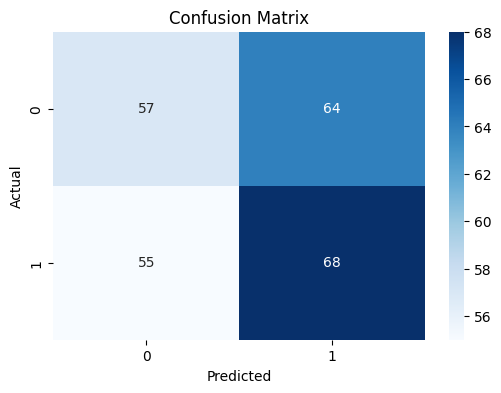

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[52/101] Training NFLX ...
/--------------------------------------------------------------------/
NFLX
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 1.4618 - mae: 0.9513 - val_loss: 0.0220 - val_mae: 0.1237 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9283 - mae: 0.7543 - val_loss: 0.0210 - val_mae: 0.1193 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6074 - mae: 0.6099 - val_loss: 0.0074 - val_mae: 0.0245 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5349 - mae: 0.5722 - val_loss: 0.0675 - val_mae: 0.2386 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4249 - mae: 0.5001 - val_loss: 0.1028 - val_mae: 0.3068 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3365 - mae: 0.4484 - 

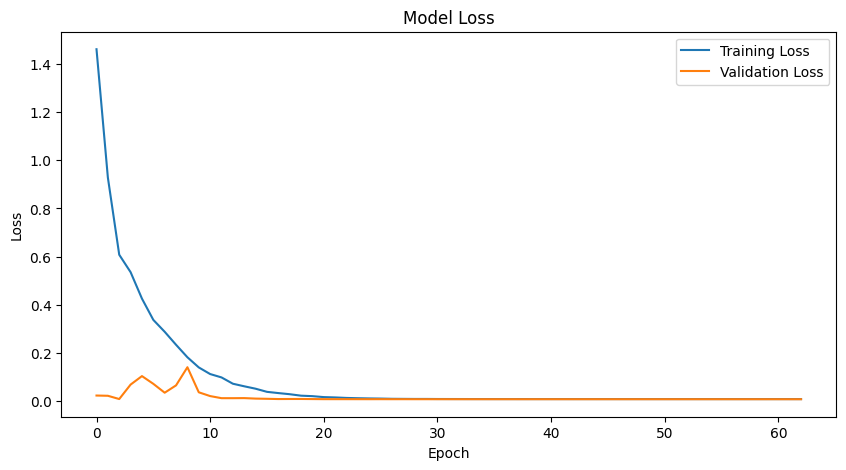

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Accuracy: 0.5410
Precision: 0.5405
Recall: 0.4959
F1-Score: 0.5172
RMSE: 0.020837


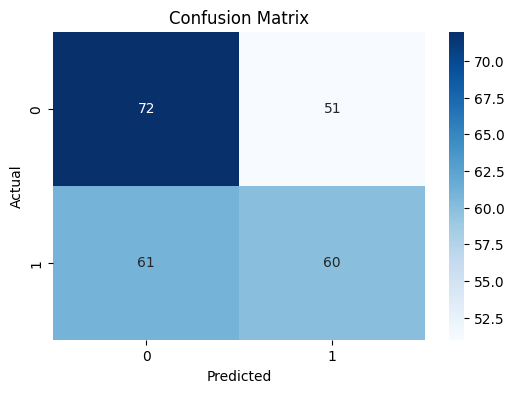

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[53/101] Training DXCM ...
/--------------------------------------------------------------------/
DXCM
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1.7796 - mae: 1.0341 - val_loss: 0.0069 - val_mae: 0.0200 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9683 - mae: 0.7609 - val_loss: 0.0076 - val_mae: 0.0309 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9203 - mae: 0.7386 - val_loss: 0.0078 - val_mae: 0.0340 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6129 - mae: 0.5973 - val_loss: 0.0166 - val_mae: 0.0909 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4665 - mae: 0.5236 - val_loss: 0.0194 - val_mae: 0.0935 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4033 - mae: 0.4755 - v

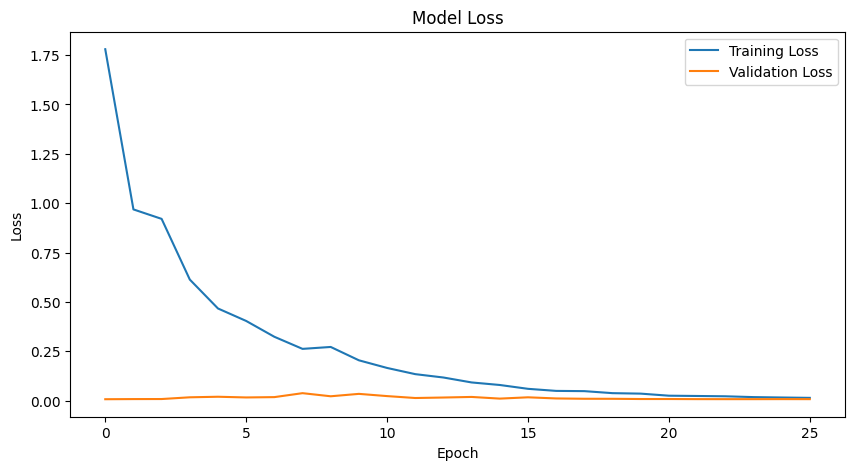

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Accuracy: 0.4590
Precision: 0.4220
Recall: 0.4000
F1-Score: 0.4107
RMSE: 0.041245


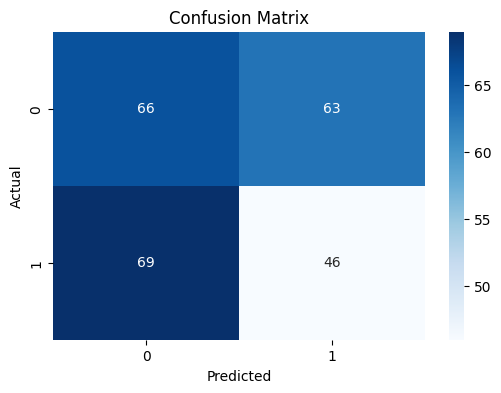

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[54/101] Training CSGP ...
/--------------------------------------------------------------------/
CSGP
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 2.1547 - mae: 1.1363 - val_loss: 0.0150 - val_mae: 0.0925 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2181 - mae: 0.8625 - val_loss: 0.0441 - val_mae: 0.1939 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8236 - mae: 0.7151 - val_loss: 0.0117 - val_mae: 0.0636 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6917 - mae: 0.6498 - val_loss: 0.0158 - val_mae: 0.0890 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4866 - mae: 0.5475 - val_loss: 0.0268 - val_mae: 0.1210 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4125 - mae: 0.5095 - v

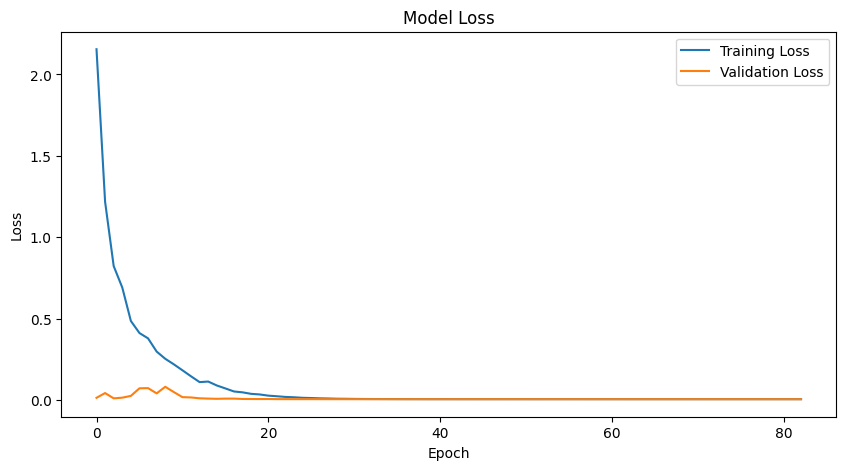

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Accuracy: 0.5205
Precision: 0.4773
Recall: 0.5676
F1-Score: 0.5185
RMSE: 0.018853


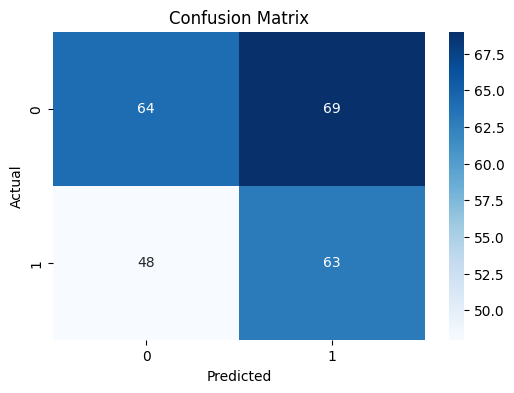

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[55/101] Training TSLA ...
/--------------------------------------------------------------------/
TSLA
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 2.2212 - mae: 1.1662 - val_loss: 0.0586 - val_mae: 0.2271 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2404 - mae: 0.8818 - val_loss: 0.0241 - val_mae: 0.1303 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0990 - mae: 0.8036 - val_loss: 0.0136 - val_mae: 0.0786 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7216 - mae: 0.6638 - val_loss: 0.0629 - val_mae: 0.2304 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6379 - mae: 0.6260 - val_loss: 0.0133 - val_mae: 0.0720 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5816 - mae: 0.5645 - 

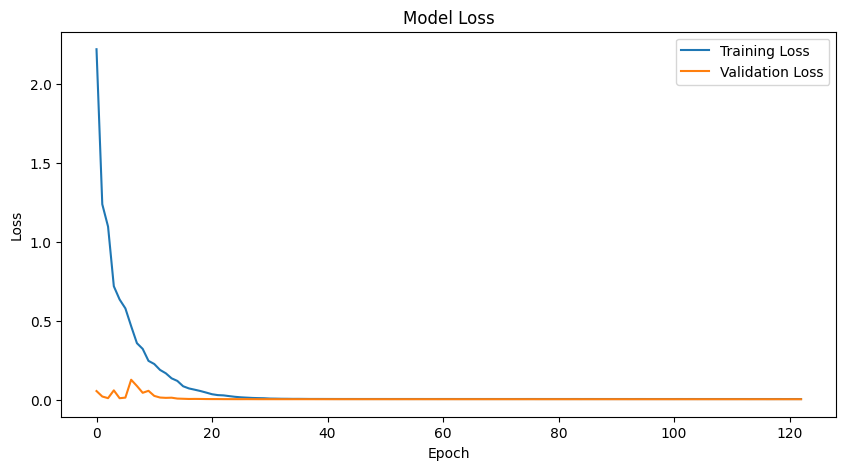

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Accuracy: 0.5164
Precision: 0.5317
Recall: 0.5317
F1-Score: 0.5317
RMSE: 0.039440


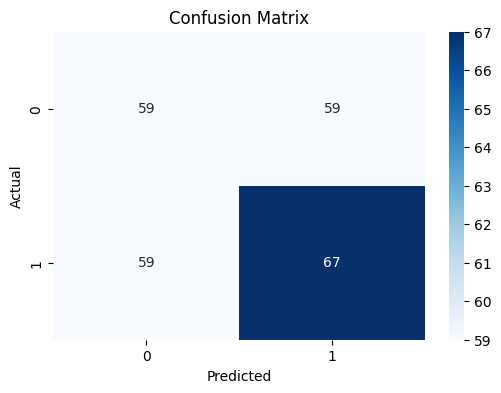

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[56/101] Training DASH ...
/--------------------------------------------------------------------/
DASH
/--------------------------------------------------------------------/
Epoch 1/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 2.4139 - mae: 1.2003 - val_loss: 0.0199 - val_mae: 0.1149 - learning_rate: 0.0010
Epoch 2/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4030 - mae: 0.9398 - val_loss: 0.0572 - val_mae: 0.2246 - learning_rate: 0.0010
Epoch 3/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1149 - mae: 0.8558 - val_loss: 0.0254 - val_mae: 0.1365 - learning_rate: 0.0010
Epoch 4/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.8008 - mae: 0.7111 - val_loss: 0.0093 - val_mae: 0.0426 - learning_rate: 0.0010
Epoch 5/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7154 - mae: 0.6610 - val_loss: 0.0717 - val_mae: 0.2519 - learning_rate: 0.0010
Epoch 6/200
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6870 - mae: 0.64

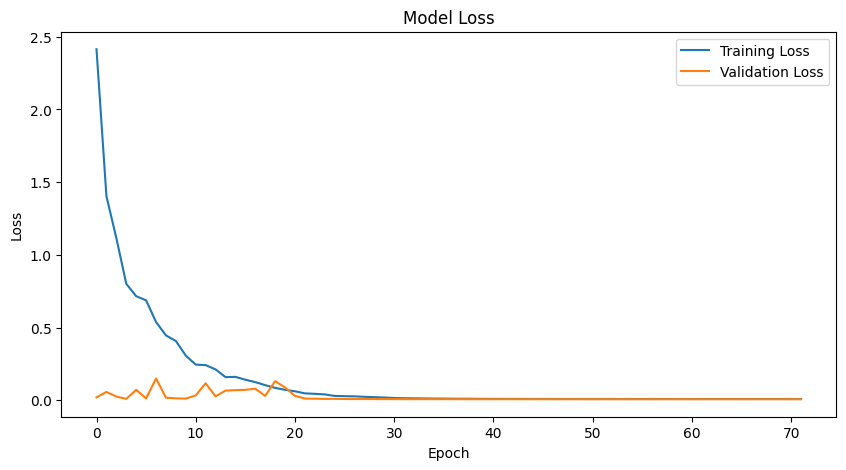

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Accuracy: 0.5328
Precision: 0.5484
Recall: 0.5397
F1-Score: 0.5440
RMSE: 0.022803


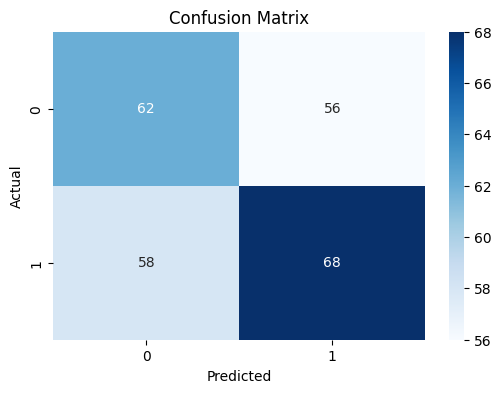

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[57/101] Training CDW ...
/--------------------------------------------------------------------/
CDW
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 2.1389 - mae: 1.1214 - val_loss: 0.0083 - val_mae: 0.0439 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1066 - mae: 0.8233 - val_loss: 0.0065 - val_mae: 0.0132 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8300 - mae: 0.6979 - val_loss: 0.0110 - val_mae: 0.0658 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5616 - mae: 0.5812 - val_loss: 0.1578 - val_mae: 0.3758 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5393 - mae: 0.5839 - val_loss: 0.1959 - val_mae: 0.4234 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4180 - mae: 0.5034 - v

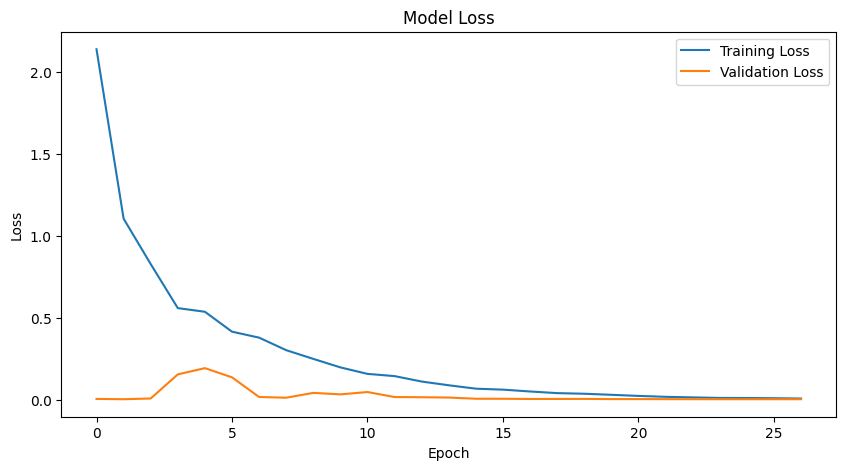

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Accuracy: 0.4959
Precision: 0.4876
Recall: 0.4917
F1-Score: 0.4896
RMSE: 0.020373


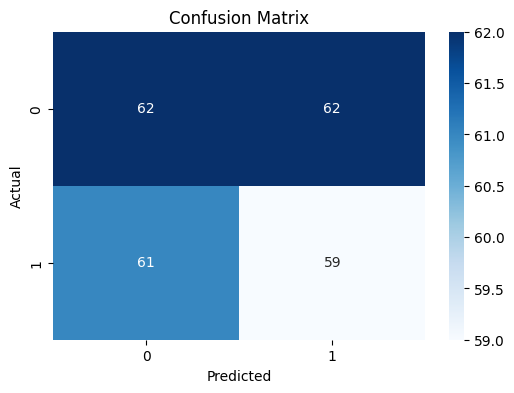

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[58/101] Training BKNG ...
/--------------------------------------------------------------------/
BKNG
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 2.3244 - mae: 1.1726 - val_loss: 0.0067 - val_mae: 0.0187 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3333 - mae: 0.8867 - val_loss: 0.0251 - val_mae: 0.1365 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9063 - mae: 0.7346 - val_loss: 0.1028 - val_mae: 0.3094 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7233 - mae: 0.6413 - val_loss: 0.0881 - val_mae: 0.2836 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5816 - mae: 0.5744 - val_loss: 0.0266 - val_mae: 0.1229 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5203 - mae: 0.5423 - 

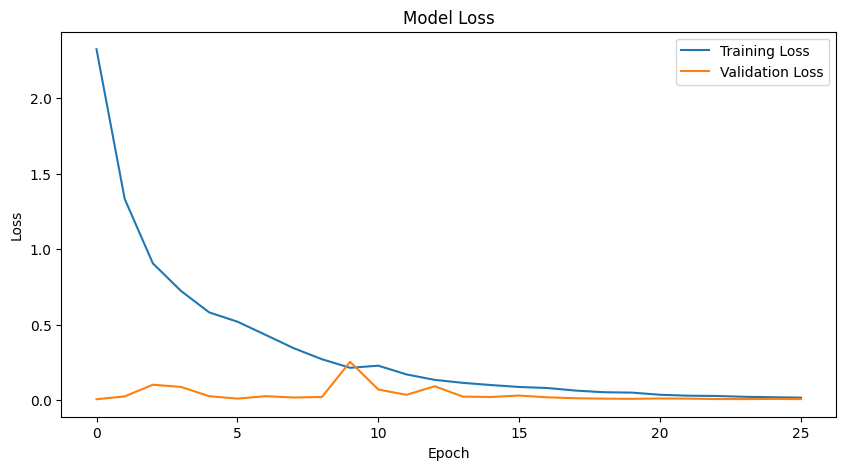

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Accuracy: 0.4549
Precision: 0.4692
Recall: 0.4880
F1-Score: 0.4784
RMSE: 0.024379


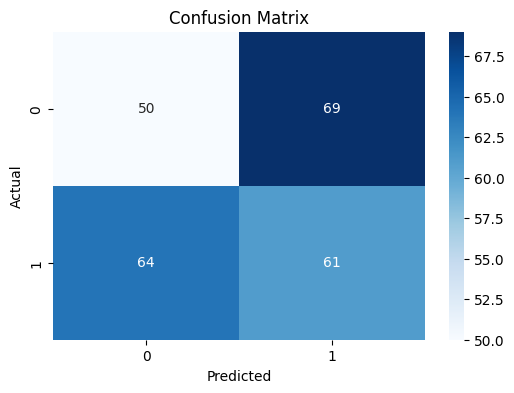

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[59/101] Training MDLZ ...
/--------------------------------------------------------------------/
MDLZ
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 2.2165 - mae: 1.1680 - val_loss: 0.0231 - val_mae: 0.1296 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4470 - mae: 0.9480 - val_loss: 0.1024 - val_mae: 0.3099 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9836 - mae: 0.7815 - val_loss: 0.1507 - val_mae: 0.3799 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7978 - mae: 0.6970 - val_loss: 0.0969 - val_mae: 0.3005 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6614 - mae: 0.6322 - val_loss: 0.0144 - val_mae: 0.0621 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5969 - mae: 0.5929 - 

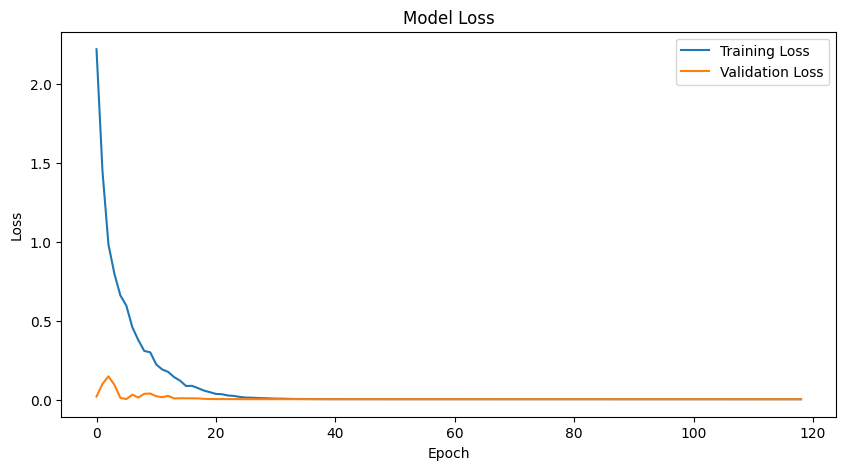

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Accuracy: 0.5205
Precision: 0.5122
Recall: 0.5250
F1-Score: 0.5185
RMSE: 0.011030


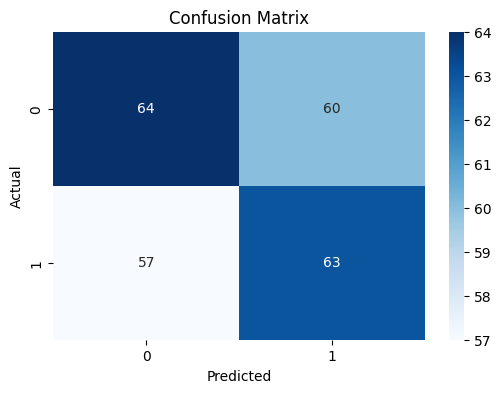

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[60/101] Training CCEP ...
/--------------------------------------------------------------------/
CCEP
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 2.1458 - mae: 1.1213 - val_loss: 0.0063 - val_mae: 0.0086 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1546 - mae: 0.8449 - val_loss: 0.0118 - val_mae: 0.0738 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8713 - mae: 0.7217 - val_loss: 0.0675 - val_mae: 0.2461 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6685 - mae: 0.6391 - val_loss: 0.0797 - val_mae: 0.2568 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6008 - mae: 0.5973 - val_loss: 0.1256 - val_mae: 0.3264 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4966 - mae: 0.5494 - 

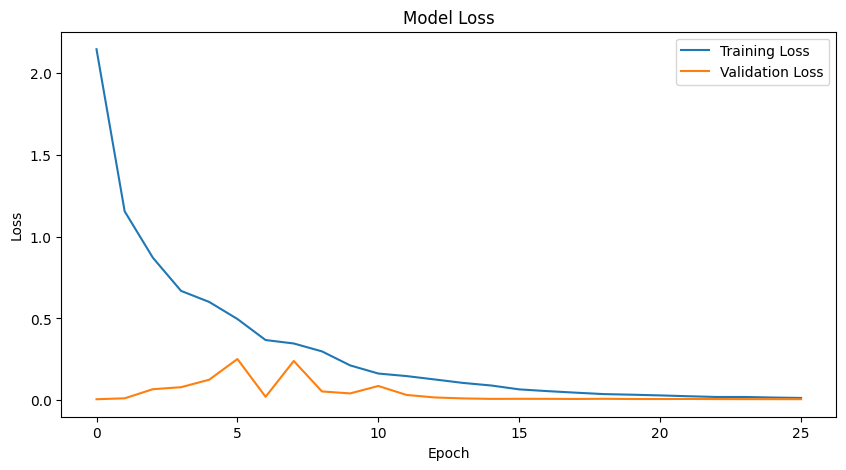

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Accuracy: 0.4795
Precision: 0.4454
Recall: 0.4649
F1-Score: 0.4549
RMSE: 0.010869


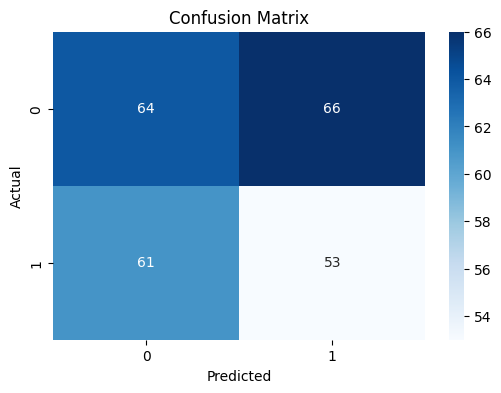

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[61/101] Training CEG ...
/--------------------------------------------------------------------/
CEG
/--------------------------------------------------------------------/
Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 1.9624 - mae: 1.0762 - val_loss: 0.0124 - val_mae: 0.0768 - learning_rate: 0.0010
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4686 - mae: 0.9439 - val_loss: 0.0097 - val_mae: 0.0559 - learning_rate: 0.0010
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2688 - mae: 0.8965 - val_loss: 0.0138 - val_mae: 0.0850 - learning_rate: 0.0010
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0001 - mae: 0.7753 - val_loss: 0.0131 - val_mae: 0.0807 - learning_rate: 0.0010
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8085 - mae: 0.6794 - val_loss: 0.0073 - val_mae: 0.0283 - learning_rate: 0.0010
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6440 - mae: 0.6301 - 

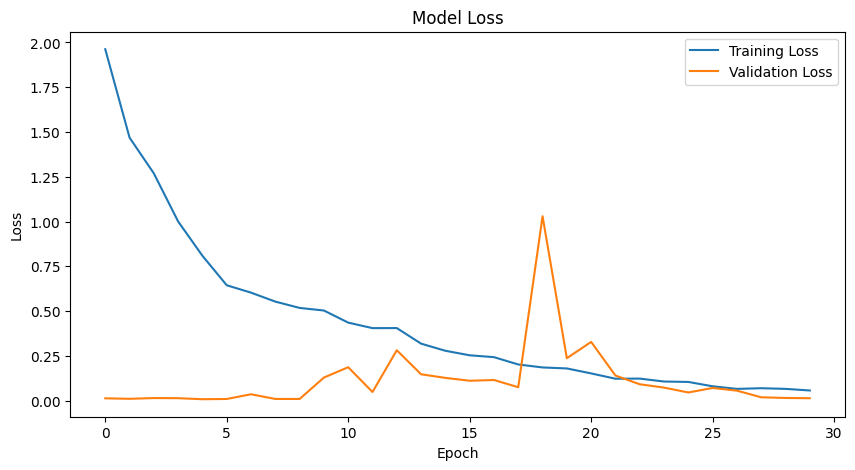

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Accuracy: 0.4795
Precision: 0.4786
Recall: 0.4590
F1-Score: 0.4686
RMSE: 0.037624


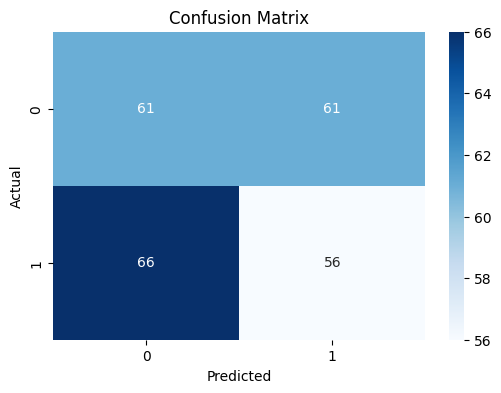

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[62/101] Training FAST ...
/--------------------------------------------------------------------/
FAST
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 1.8277 - mae: 1.0663 - val_loss: 0.0236 - val_mae: 0.1313 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0809 - mae: 0.8238 - val_loss: 0.0066 - val_mae: 0.0181 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8405 - mae: 0.7131 - val_loss: 0.0268 - val_mae: 0.1430 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6914 - mae: 0.6551 - val_loss: 0.0139 - val_mae: 0.0827 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5264 - mae: 0.5601 - val_loss: 0.0138 - val_mae: 0.0784 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3972 - mae: 0.4787 - 

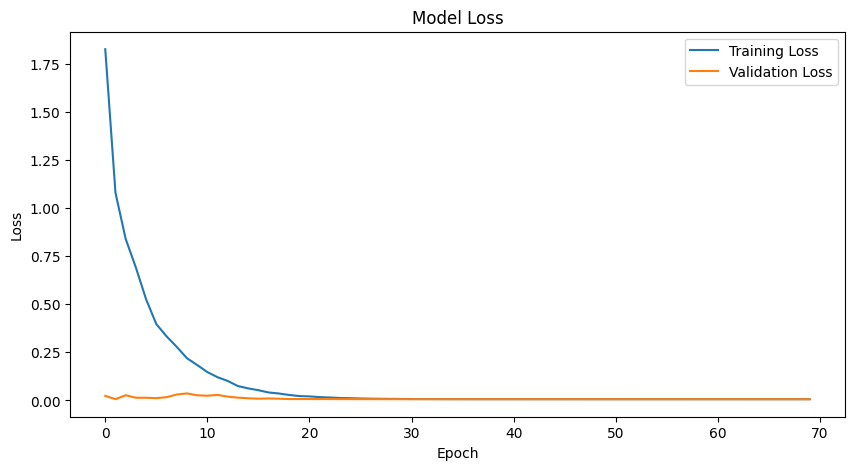

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
Accuracy: 0.5041
Precision: 0.5135
Recall: 0.4597
F1-Score: 0.4851
RMSE: 0.015283


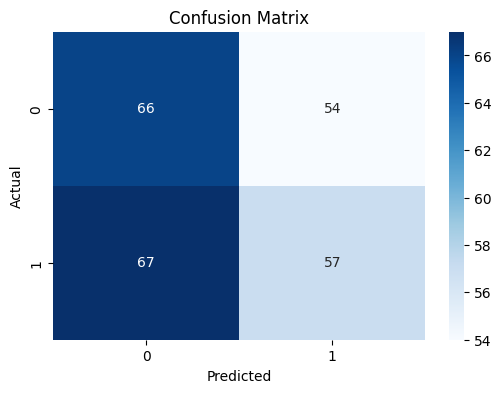

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
[63/101] Training NXPI ...
/--------------------------------------------------------------------/
NXPI
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 2.0539 - mae: 1.1037 - val_loss: 0.0335 - val_mae: 0.1641 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1813 - mae: 0.8546 - val_loss: 0.0309 - val_mae: 0.1561 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8562 - mae: 0.7294 - val_loss: 0.0332 - val_mae: 0.1624 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6188 - mae: 0.6059 - val_loss: 0.0439 - val_mae: 0.1889 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4933 - mae: 0.5418 - val_loss: 0.1363 - val_mae: 0.3486 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4030 - mae: 0.4907 - 

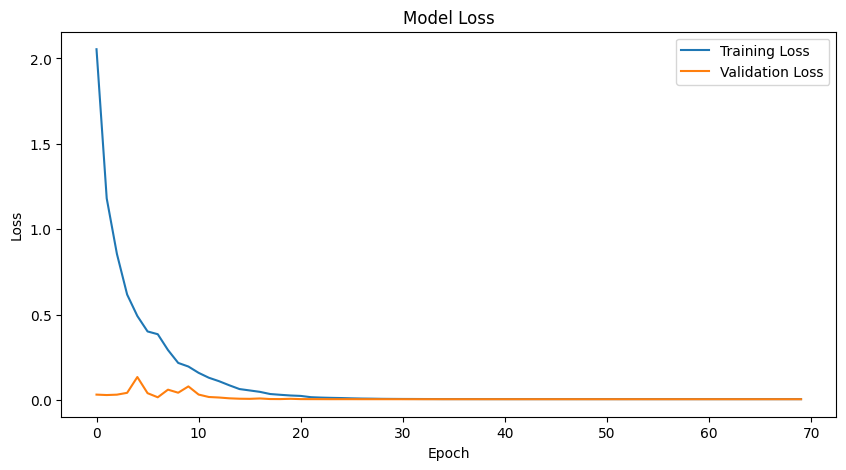

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Accuracy: 0.4631
Precision: 0.4831
Recall: 0.4488
F1-Score: 0.4653
RMSE: 0.022717


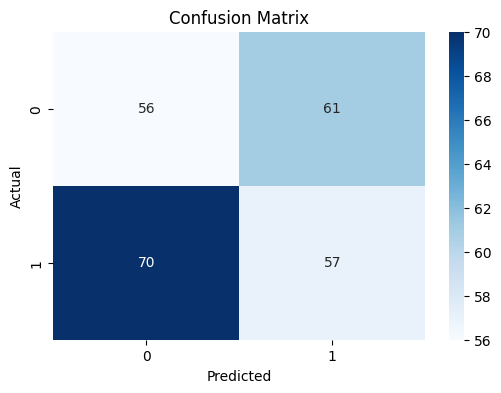

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[64/101] Training VRTX ...
/--------------------------------------------------------------------/
VRTX
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1.9656 - mae: 1.0723 - val_loss: 0.0171 - val_mae: 0.1032 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2296 - mae: 0.8735 - val_loss: 0.0160 - val_mae: 0.0956 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9187 - mae: 0.7439 - val_loss: 0.0112 - val_mae: 0.0683 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7020 - mae: 0.6482 - val_loss: 0.0126 - val_mae: 0.0667 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5166 - mae: 0.5519 - val_loss: 0.0203 - val_mae: 0.1104 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4578 - mae: 0.5128 -

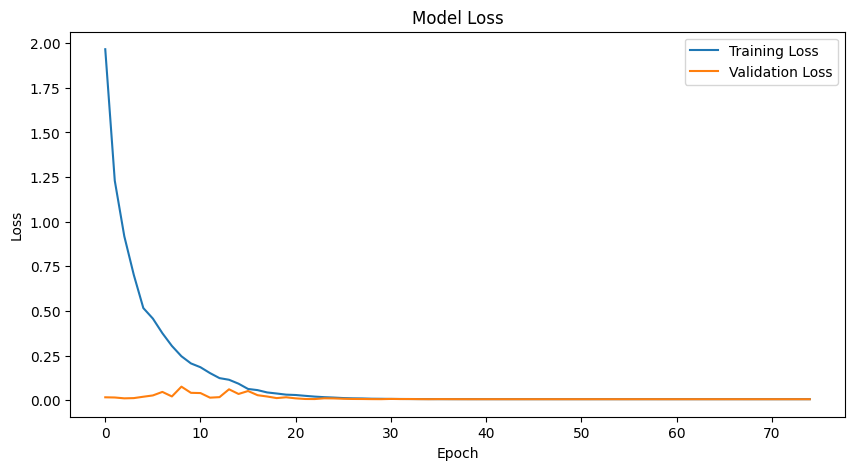

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Accuracy: 0.5369
Precision: 0.5690
Recall: 0.5116
F1-Score: 0.5388
RMSE: 0.015754


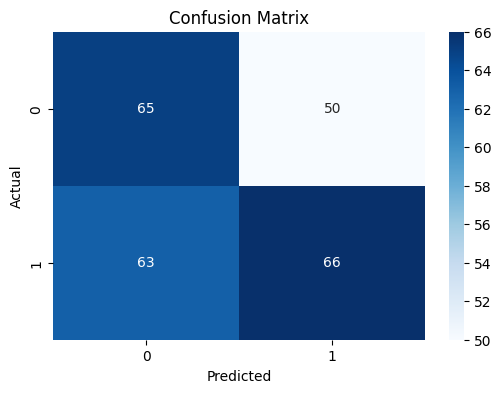

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[65/101] Training PEP ...
/--------------------------------------------------------------------/
PEP
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 2.1726 - mae: 1.1588 - val_loss: 0.0105 - val_mae: 0.0649 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4218 - mae: 0.9254 - val_loss: 0.0156 - val_mae: 0.0963 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9073 - mae: 0.7364 - val_loss: 0.0284 - val_mae: 0.1486 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7309 - mae: 0.6675 - val_loss: 0.0086 - val_mae: 0.0452 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5319 - mae: 0.5632 - val_loss: 0.0393 - val_mae: 0.1745 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5059 - mae: 0.5346 - v

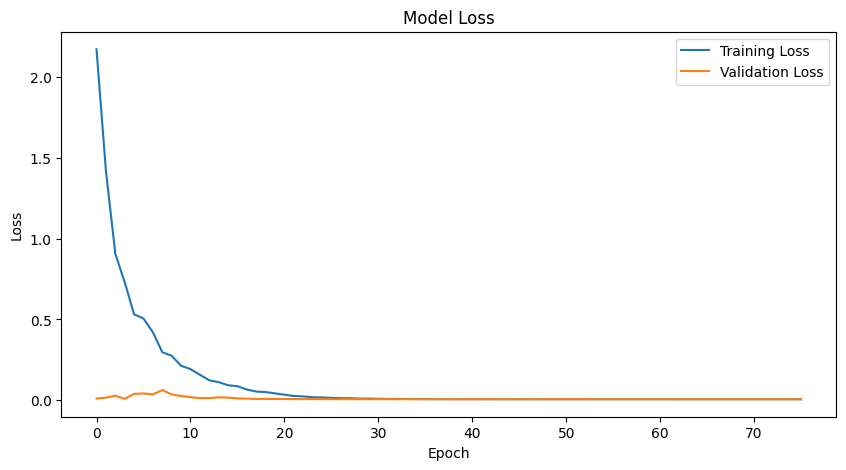

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
Accuracy: 0.5205
Precision: 0.5299
Recall: 0.5000
F1-Score: 0.5145
RMSE: 0.011134


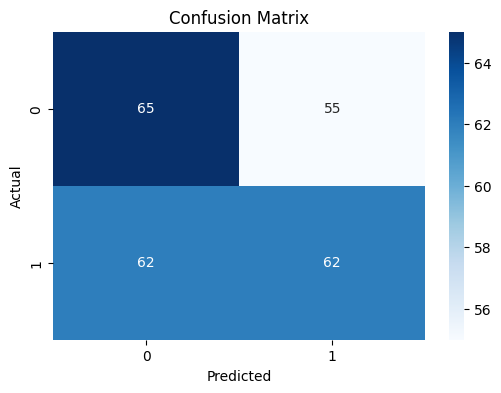

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[66/101] Training CTAS ...
/--------------------------------------------------------------------/
CTAS
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1.7595 - mae: 1.0238 - val_loss: 0.0296 - val_mae: 0.1527 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0323 - mae: 0.8000 - val_loss: 0.0676 - val_mae: 0.2474 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7647 - mae: 0.6769 - val_loss: 0.0394 - val_mae: 0.1810 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6311 - mae: 0.6147 - val_loss: 0.0141 - val_mae: 0.0670 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5184 - mae: 0.5658 - val_loss: 0.0832 - val_mae: 0.2489 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4330 - mae: 0.5041 -

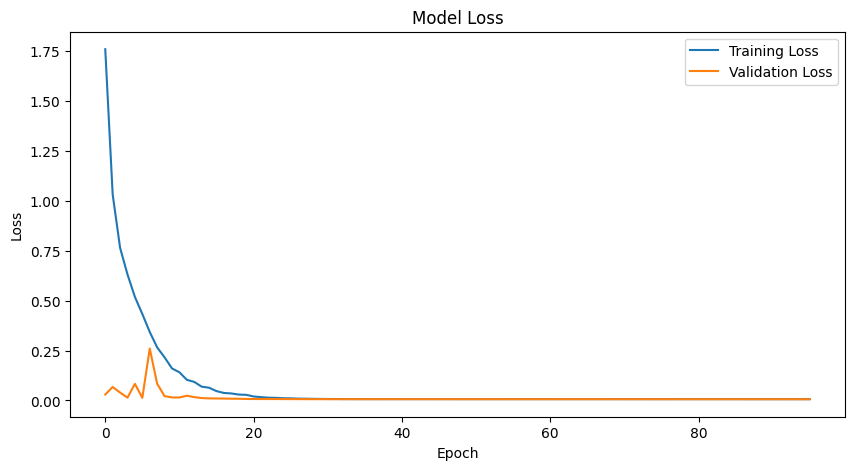

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Accuracy: 0.5164
Precision: 0.5156
Recall: 0.5410
F1-Score: 0.5280
RMSE: 0.014328


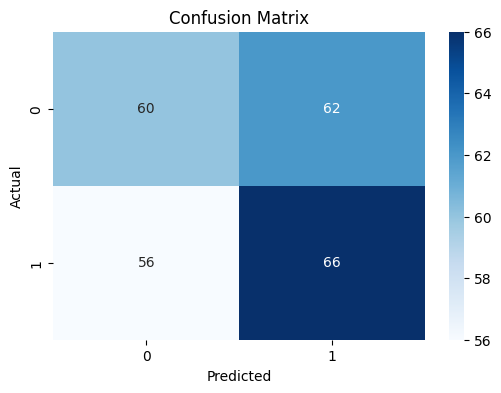

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[67/101] Training META ...
/--------------------------------------------------------------------/
META
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 1.7952 - mae: 1.0541 - val_loss: 0.0847 - val_mae: 0.2796 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9743 - mae: 0.7928 - val_loss: 0.2069 - val_mae: 0.4475 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7978 - mae: 0.7017 - val_loss: 0.1084 - val_mae: 0.3188 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5373 - mae: 0.5651 - val_loss: 0.1785 - val_mae: 0.4117 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4947 - mae: 0.5431 - val_loss: 0.3266 - val_mae: 0.5523 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4117 - mae: 0.4955

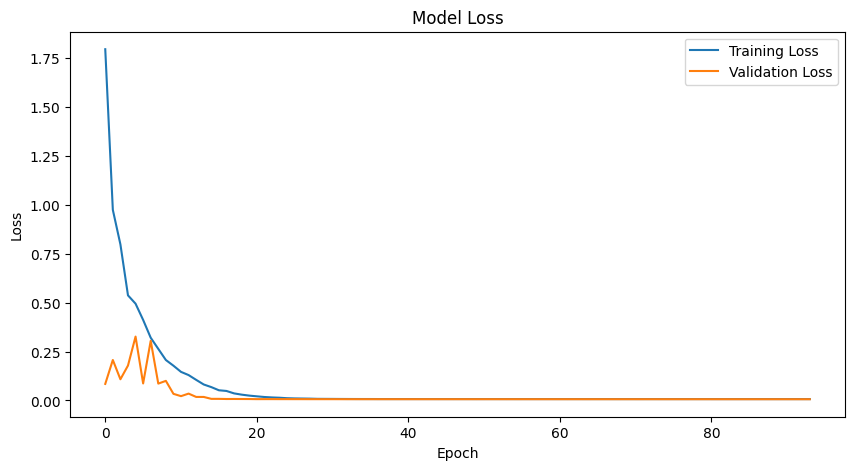

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
Accuracy: 0.5287
Precision: 0.5086
Recall: 0.5043
F1-Score: 0.5064
RMSE: 0.024148


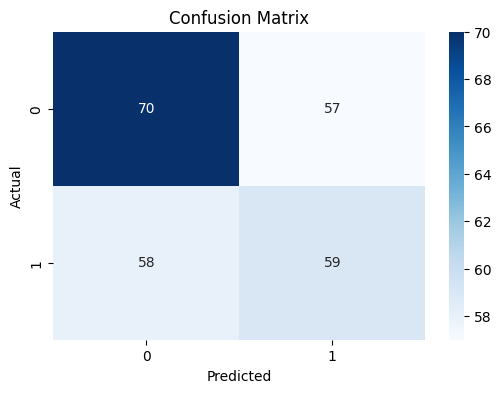

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[68/101] Training MAR ...
/--------------------------------------------------------------------/
MAR
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 1.6489 - mae: 1.0225 - val_loss: 0.0419 - val_mae: 0.1883 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8973 - mae: 0.7462 - val_loss: 0.0674 - val_mae: 0.2469 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7348 - mae: 0.6619 - val_loss: 0.0072 - val_mae: 0.0286 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6135 - mae: 0.6014 - val_loss: 0.0342 - val_mae: 0.1611 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4117 - mae: 0.5033 - val_loss: 0.0134 - val_mae: 0.0773 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3411 - mae: 0.4527 - v

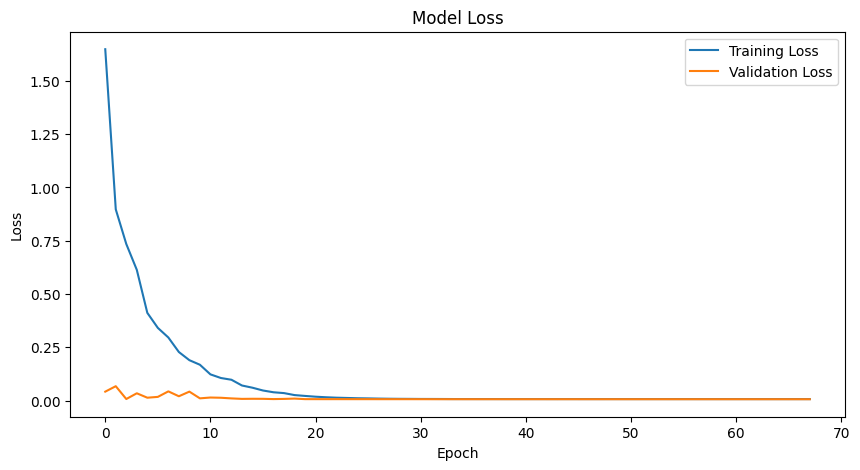

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Accuracy: 0.5000
Precision: 0.5089
Recall: 0.4597
F1-Score: 0.4831
RMSE: 0.013722


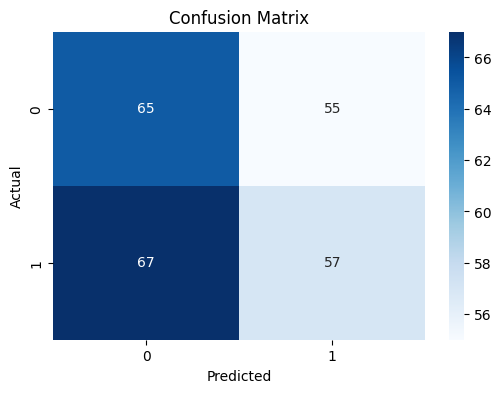

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[69/101] Training SHOP ...
/--------------------------------------------------------------------/
SHOP
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1.8384 - mae: 1.0754 - val_loss: 0.0073 - val_mae: 0.0228 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1247 - mae: 0.8447 - val_loss: 0.0128 - val_mae: 0.0739 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8343 - mae: 0.7232 - val_loss: 0.0223 - val_mae: 0.1221 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6956 - mae: 0.6462 - val_loss: 0.0086 - val_mae: 0.0381 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5389 - mae: 0.5748 - val_loss: 0.0096 - val_mae: 0.0484 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4772 - mae: 0.525

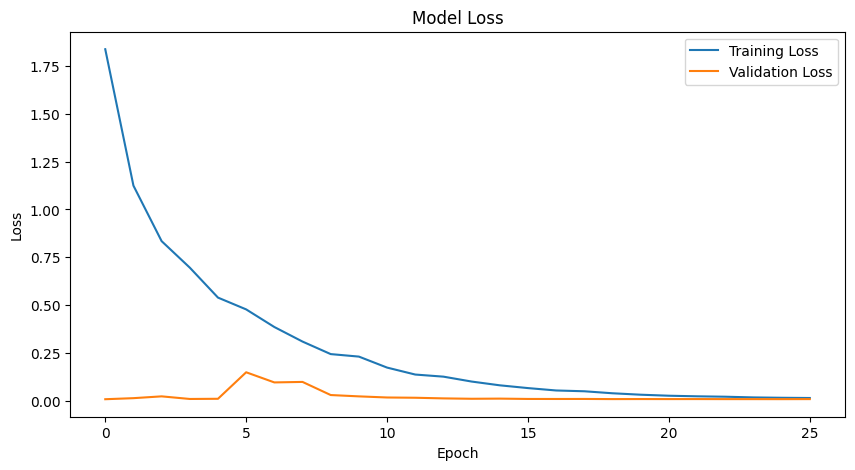

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Accuracy: 0.4672
Precision: 0.4640
Recall: 0.4793
F1-Score: 0.4715
RMSE: 0.033275


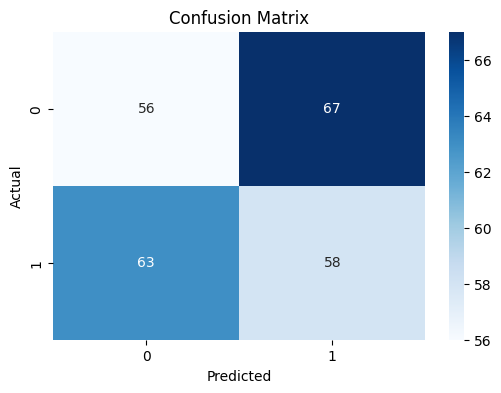

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
[70/101] Training MU ...
/--------------------------------------------------------------------/
MU
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 2.0912 - mae: 1.1282 - val_loss: 0.0278 - val_mae: 0.1453 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1840 - mae: 0.8358 - val_loss: 0.0547 - val_mae: 0.2190 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0017 - mae: 0.7716 - val_loss: 0.0113 - val_mae: 0.0668 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7766 - mae: 0.6803 - val_loss: 0.0157 - val_mae: 0.0935 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5750 - mae: 0.5802 - val_loss: 0.0127 - val_mae: 0.0686 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4725 - mae: 0.5191 - val_

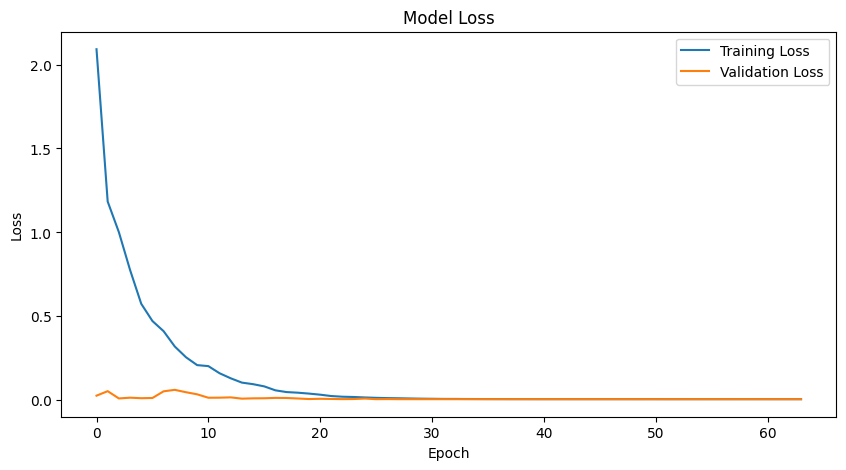

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Accuracy: 0.4836
Precision: 0.4884
Recall: 0.5122
F1-Score: 0.5000
RMSE: 0.033060


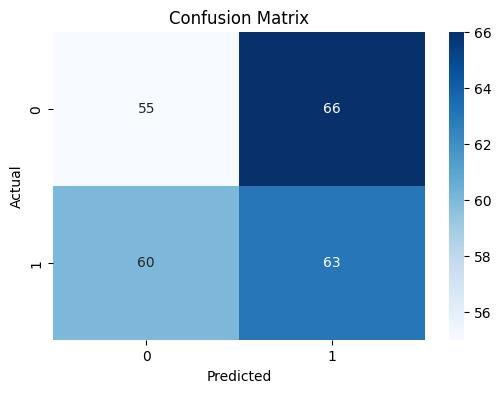

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[71/101] Training ADBE ...
/--------------------------------------------------------------------/
ADBE
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 2.2965 - mae: 1.1992 - val_loss: 0.0120 - val_mae: 0.0736 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2278 - mae: 0.8708 - val_loss: 0.0255 - val_mae: 0.1376 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9558 - mae: 0.7714 - val_loss: 0.0127 - val_mae: 0.0697 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6605 - mae: 0.6353 - val_loss: 0.0293 - val_mae: 0.1303 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5814 - mae: 0.5999 - val_loss: 0.0359 - val_mae: 0.1601 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4543 - mae: 0.5146 

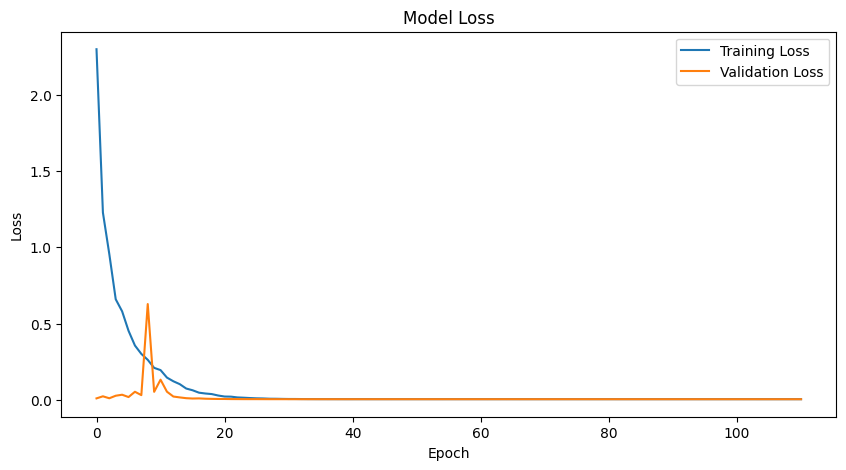

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
Accuracy: 0.5410
Precision: 0.5484
Recall: 0.5484
F1-Score: 0.5484
RMSE: 0.023614


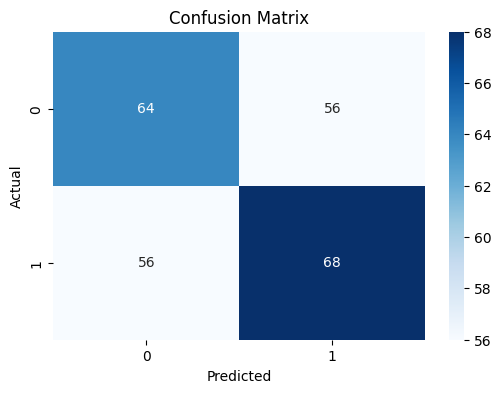

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[72/101] Training PANW ...
/--------------------------------------------------------------------/
PANW
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 2.2604 - mae: 1.1684 - val_loss: 0.0147 - val_mae: 0.0894 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2850 - mae: 0.8955 - val_loss: 0.0171 - val_mae: 0.0998 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8897 - mae: 0.7353 - val_loss: 0.0421 - val_mae: 0.1781 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7209 - mae: 0.6641 - val_loss: 0.0820 - val_mae: 0.2673 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5467 - mae: 0.5730 - val_loss: 0.1231 - val_mae: 0.3070 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4580 - mae: 0.51

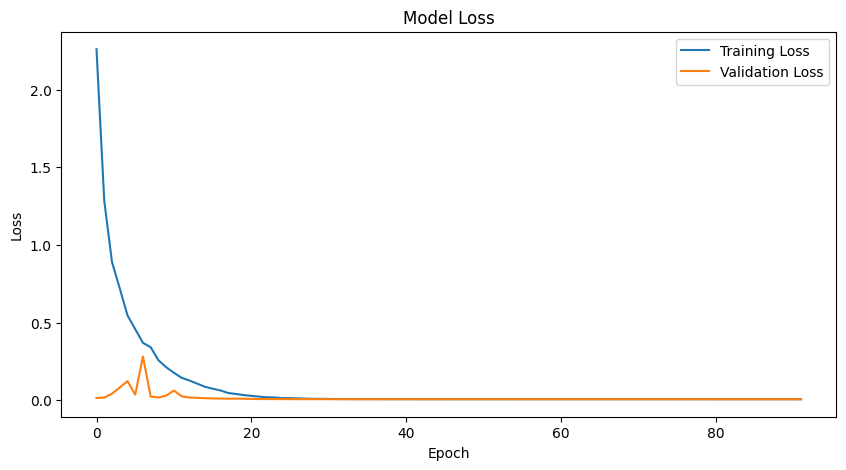

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Accuracy: 0.5369
Precision: 0.5043
Recall: 0.5175
F1-Score: 0.5108
RMSE: 0.030471


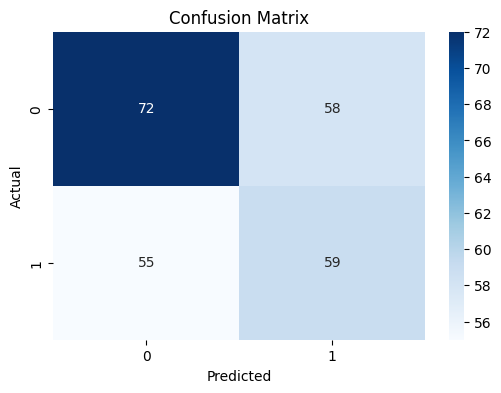

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[73/101] Training ON ...
/--------------------------------------------------------------------/
ON
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 1.9159 - mae: 1.0693 - val_loss: 0.0232 - val_mae: 0.1273 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2179 - mae: 0.8599 - val_loss: 0.0113 - val_mae: 0.0653 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8393 - mae: 0.7127 - val_loss: 0.0581 - val_mae: 0.2220 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7331 - mae: 0.6598 - val_loss: 0.1818 - val_mae: 0.4157 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4898 - mae: 0.5471 - val_loss: 0.0523 - val_mae: 0.1952 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4277 - mae: 0.5102 - 

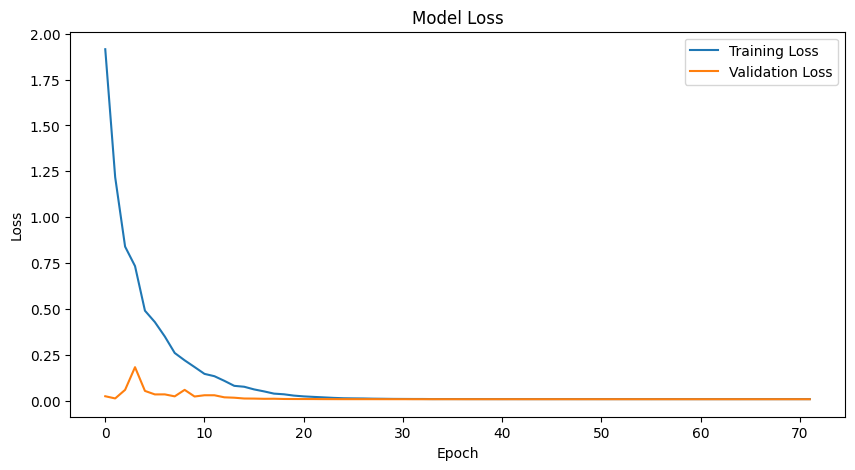

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Accuracy: 0.5123
Precision: 0.5496
Recall: 0.5455
F1-Score: 0.5475
RMSE: 0.029359


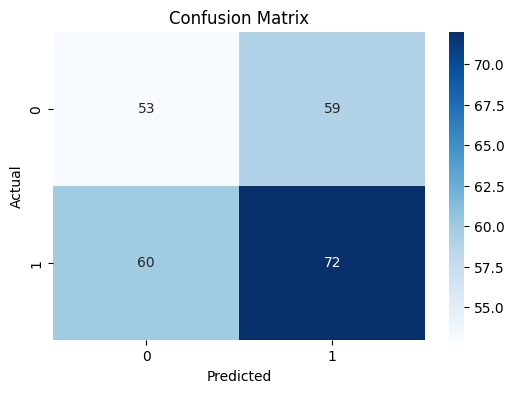

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[74/101] Training ROST ...
/--------------------------------------------------------------------/
ROST
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 1.7951 - mae: 1.0605 - val_loss: 0.0198 - val_mae: 0.1163 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0483 - mae: 0.8044 - val_loss: 0.0192 - val_mae: 0.1130 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8353 - mae: 0.7038 - val_loss: 0.0112 - val_mae: 0.0685 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6904 - mae: 0.6576 - val_loss: 0.0645 - val_mae: 0.2405 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5676 - mae: 0.5832 - val_loss: 0.0154 - val_mae: 0.0832 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4426 - mae: 0.5240 -

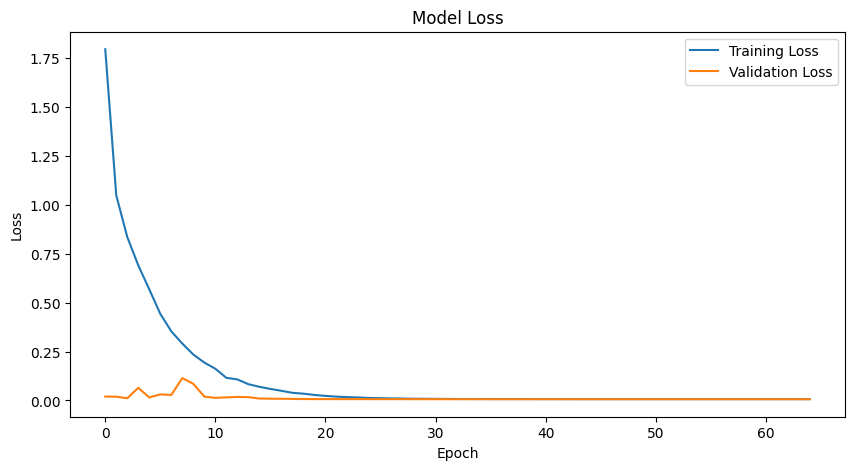

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
Accuracy: 0.4877
Precision: 0.4769
Recall: 0.5210
F1-Score: 0.4980
RMSE: 0.013827


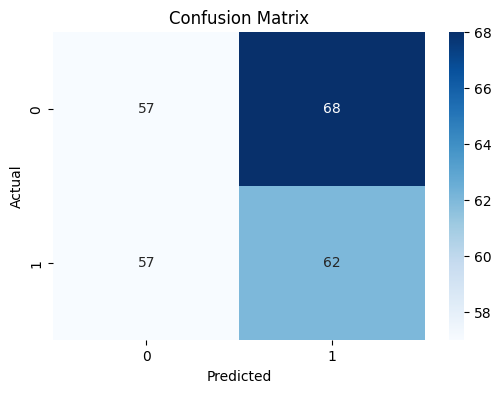

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[75/101] Training MELI ...
/--------------------------------------------------------------------/
MELI
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1.7598 - mae: 1.0384 - val_loss: 0.0070 - val_mae: 0.0232 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1408 - mae: 0.8152 - val_loss: 0.0264 - val_mae: 0.1401 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7554 - mae: 0.6725 - val_loss: 0.0408 - val_mae: 0.1844 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6802 - mae: 0.6413 - val_loss: 0.0103 - val_mae: 0.0515 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5275 - mae: 0.5683 - val_loss: 0.1021 - val_mae: 0.3039 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4682 - mae: 0.51

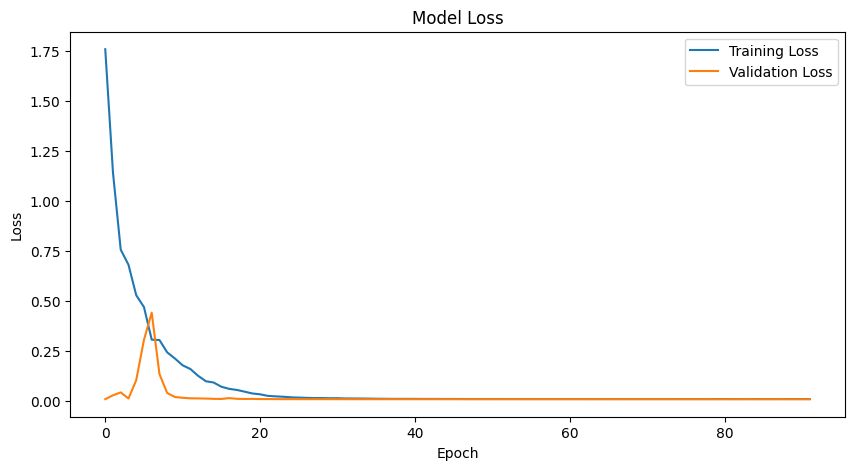

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
Accuracy: 0.5410
Precision: 0.5669
Recall: 0.5581
F1-Score: 0.5625
RMSE: 0.024645


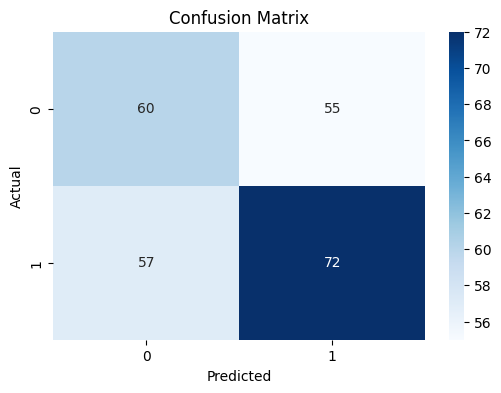

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[76/101] Training WBD ...
/--------------------------------------------------------------------/
WBD
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 2.1618 - mae: 1.1540 - val_loss: 0.0106 - val_mae: 0.0584 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1730 - mae: 0.8513 - val_loss: 0.1420 - val_mae: 0.3669 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8085 - mae: 0.7062 - val_loss: 0.0262 - val_mae: 0.1365 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6843 - mae: 0.6439 - val_loss: 0.0170 - val_mae: 0.0952 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4671 - mae: 0.5414 - val_loss: 0.0663 - val_mae: 0.2396 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4261 - mae: 0.5148 - v

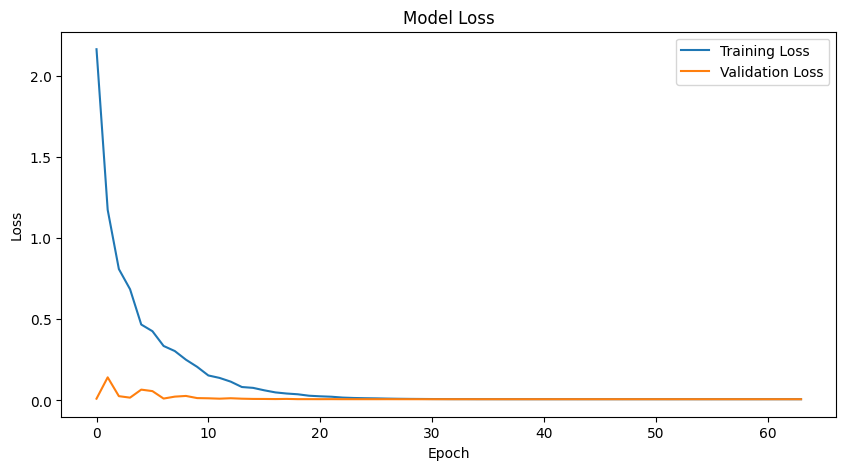

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
Accuracy: 0.4631
Precision: 0.4118
Recall: 0.4455
F1-Score: 0.4279
RMSE: 0.032155


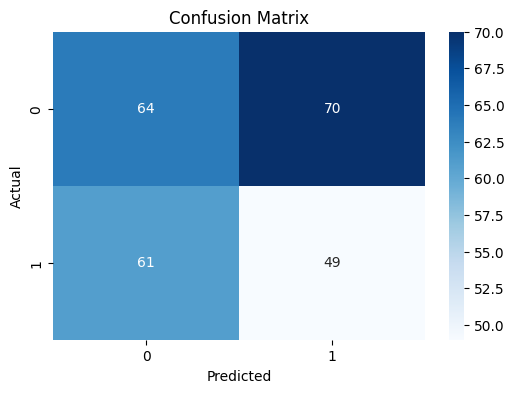

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[77/101] Training PAYX ...
/--------------------------------------------------------------------/
PAYX
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 2.3160 - mae: 1.1931 - val_loss: 0.0064 - val_mae: 0.0125 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2372 - mae: 0.8780 - val_loss: 0.0070 - val_mae: 0.0262 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0314 - mae: 0.7951 - val_loss: 0.0112 - val_mae: 0.0546 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7608 - mae: 0.6841 - val_loss: 0.0823 - val_mae: 0.2731 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5319 - mae: 0.5659 - val_loss: 0.2158 - val_mae: 0.4378 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4677 - mae: 0.5337 

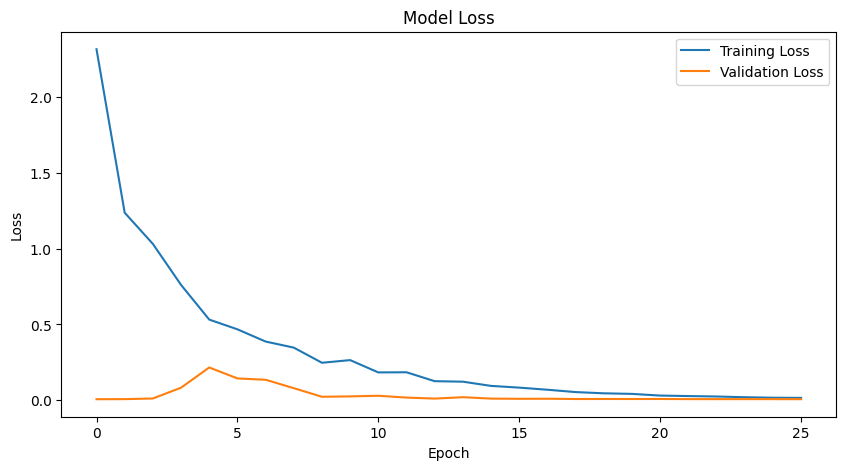

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
Accuracy: 0.4713
Precision: 0.4715
Recall: 0.4754
F1-Score: 0.4735
RMSE: 0.014188


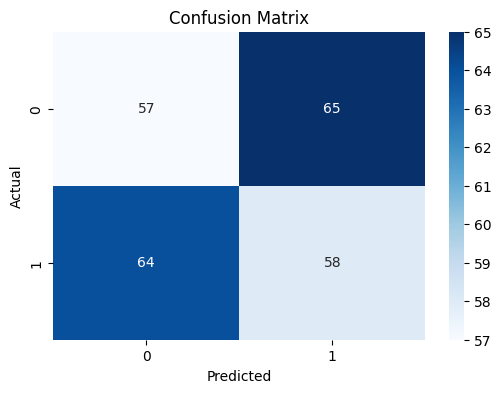

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[78/101] Training KLAC ...
/--------------------------------------------------------------------/
KLAC
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 2.1636 - mae: 1.1431 - val_loss: 0.0494 - val_mae: 0.2069 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1269 - mae: 0.8415 - val_loss: 0.0755 - val_mae: 0.2624 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7482 - mae: 0.6845 - val_loss: 0.1364 - val_mae: 0.3598 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5400 - mae: 0.5714 - val_loss: 0.0426 - val_mae: 0.1862 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4648 - mae: 0.5398 - val_loss: 0.0559 - val_mae: 0.2161 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3515 - mae: 0.46

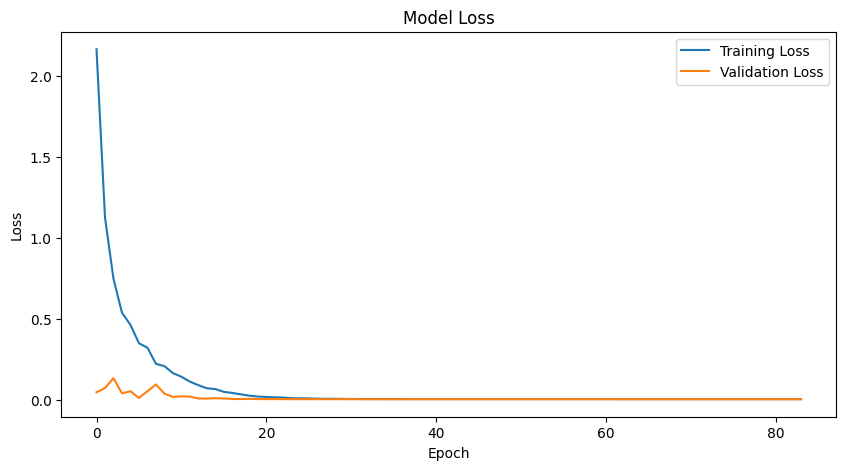

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
Accuracy: 0.5369
Precision: 0.5508
Recall: 0.5200
F1-Score: 0.5350
RMSE: 0.028592


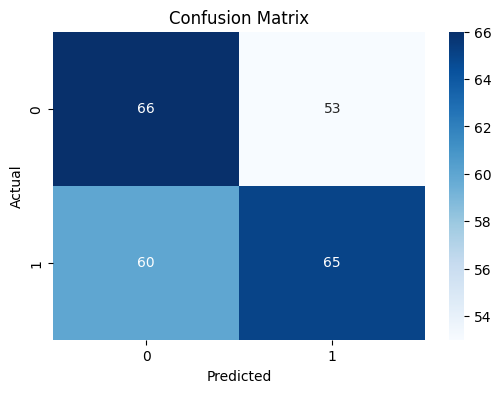

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[79/101] Training CSX ...
/--------------------------------------------------------------------/
CSX
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 1.7294 - mae: 1.0264 - val_loss: 0.0211 - val_mae: 0.1214 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1059 - mae: 0.8212 - val_loss: 0.0093 - val_mae: 0.0542 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8525 - mae: 0.7153 - val_loss: 0.0420 - val_mae: 0.1887 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6717 - mae: 0.6345 - val_loss: 0.0217 - val_mae: 0.1235 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5444 - mae: 0.5629 - val_loss: 0.0194 - val_mae: 0.1004 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4251 - mae: 0.5053 - v

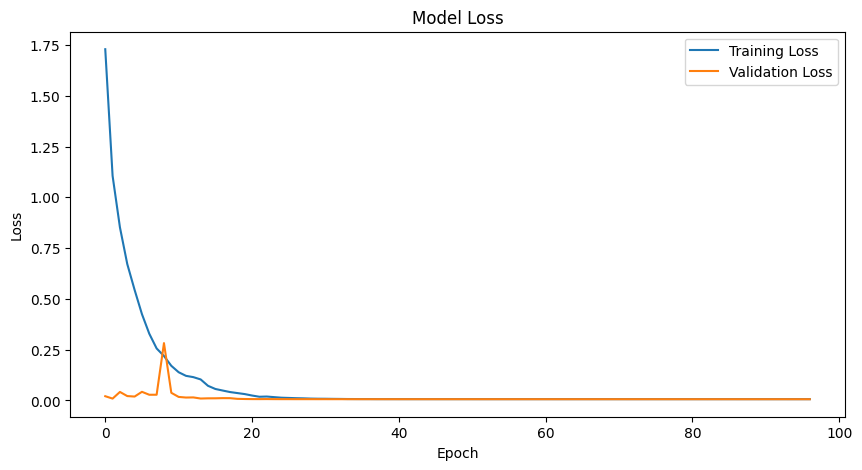

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
Accuracy: 0.4918
Precision: 0.4455
Recall: 0.4375
F1-Score: 0.4414
RMSE: 0.013725


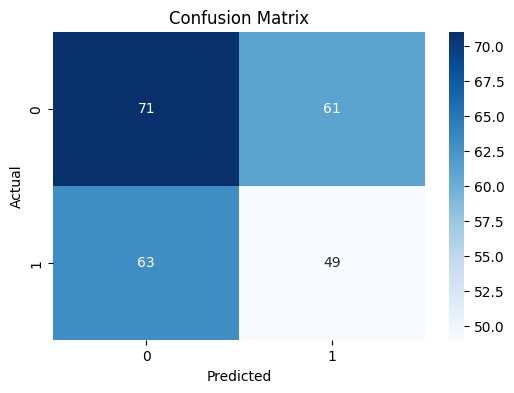

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[80/101] Training KHC ...
/--------------------------------------------------------------------/
KHC
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 2.1260 - mae: 1.1340 - val_loss: 0.0069 - val_mae: 0.0245 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3012 - mae: 0.8898 - val_loss: 0.0113 - val_mae: 0.0702 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9961 - mae: 0.7797 - val_loss: 0.0654 - val_mae: 0.2431 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8282 - mae: 0.6890 - val_loss: 0.3123 - val_mae: 0.5516 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5966 - mae: 0.5981 - val_loss: 0.7461 - val_mae: 0.8503 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4931 - mae: 0.5394 - v

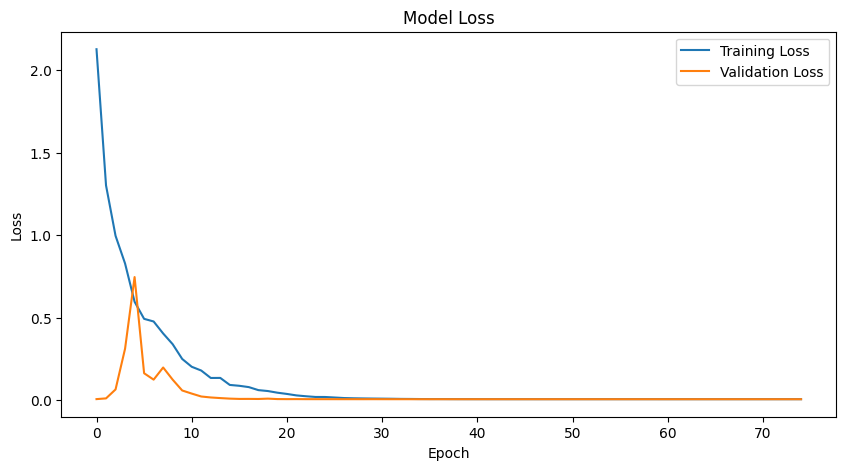

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Accuracy: 0.5082
Precision: 0.4872
Recall: 0.4872
F1-Score: 0.4872
RMSE: 0.012774


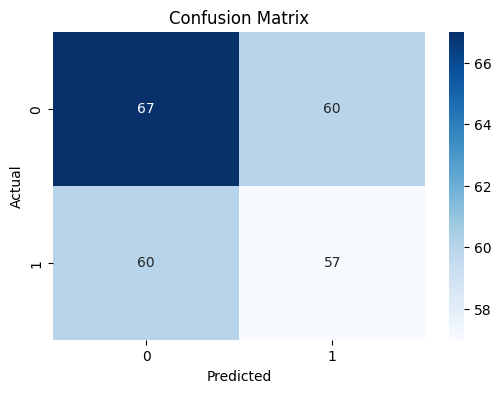

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[81/101] Training LULU ...
/--------------------------------------------------------------------/
LULU
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 1.5997 - mae: 1.0006 - val_loss: 0.0115 - val_mae: 0.0676 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8466 - mae: 0.7242 - val_loss: 0.0096 - val_mae: 0.0521 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6046 - mae: 0.6088 - val_loss: 0.0408 - val_mae: 0.1824 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5076 - mae: 0.5440 - val_loss: 0.0138 - val_mae: 0.0731 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3852 - mae: 0.4772 - val_loss: 0.0429 - val_mae: 0.1448 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3312 - mae: 0.4459 -

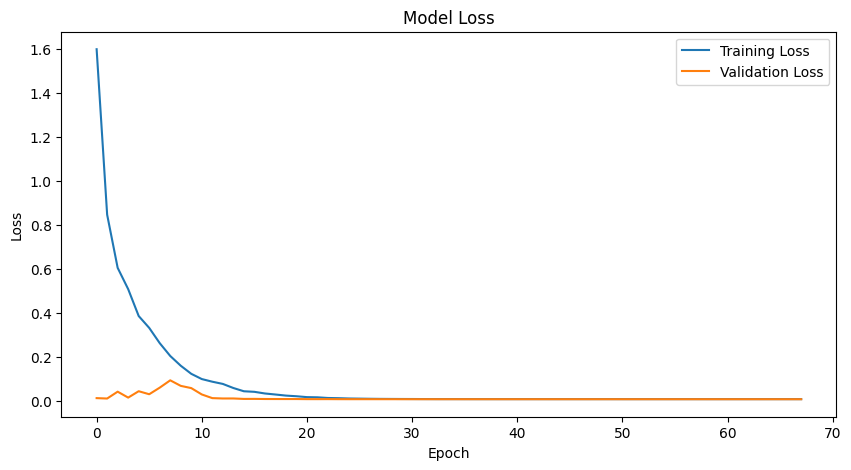

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Accuracy: 0.5287
Precision: 0.5200
Recall: 0.5417
F1-Score: 0.5306
RMSE: 0.025067


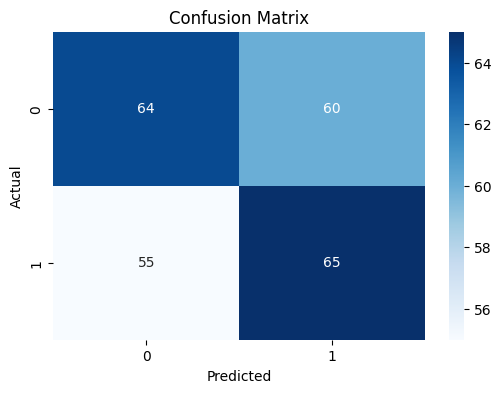

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[82/101] Training CRWD ...
/--------------------------------------------------------------------/
CRWD
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 2.2130 - mae: 1.1662 - val_loss: 0.0072 - val_mae: 0.0245 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1170 - mae: 0.8409 - val_loss: 0.0312 - val_mae: 0.1552 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9151 - mae: 0.7579 - val_loss: 0.0237 - val_mae: 0.1138 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7305 - mae: 0.6686 - val_loss: 0.0170 - val_mae: 0.0949 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5904 - mae: 0.5966 - val_loss: 0.0140 - val_mae: 0.0719 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4385 - mae: 0.5035 

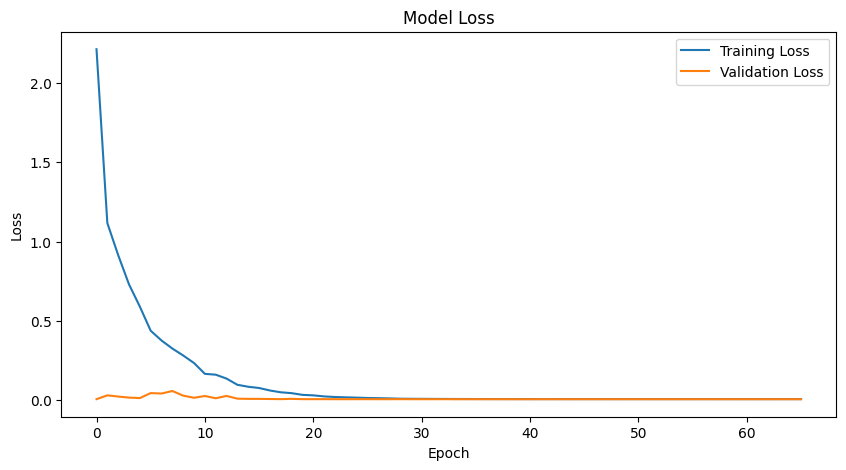

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Accuracy: 0.4754
Precision: 0.4793
Recall: 0.4715
F1-Score: 0.4754
RMSE: 0.030028


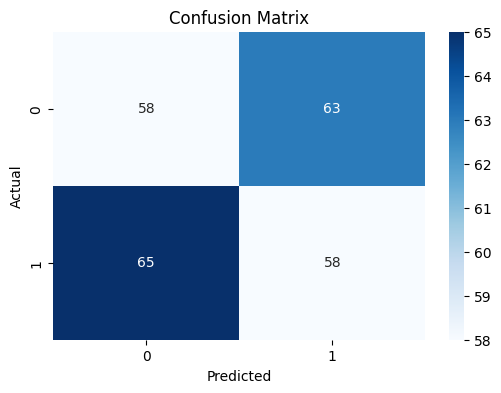

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[83/101] Training AZN ...
/--------------------------------------------------------------------/
AZN
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 2.0191 - mae: 1.0929 - val_loss: 0.0068 - val_mae: 0.0206 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1387 - mae: 0.8407 - val_loss: 0.0459 - val_mae: 0.1985 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7748 - mae: 0.6696 - val_loss: 0.0441 - val_mae: 0.1917 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.6449 - mae: 0.6097 - val_loss: 0.0070 - val_mae: 0.0213 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5284 - mae: 0.5497 - val_loss: 0.0291 - val_mae: 0.1487 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4124 - mae: 0.4838 -

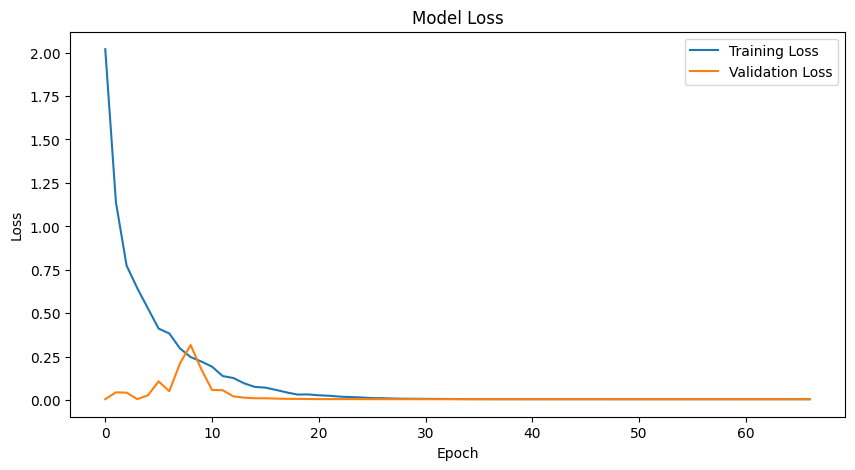

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Accuracy: 0.4590
Precision: 0.4878
Recall: 0.4651
F1-Score: 0.4762
RMSE: 0.013729


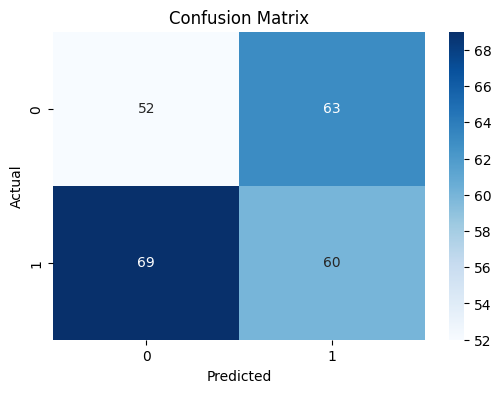

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[84/101] Training TXN ...
/--------------------------------------------------------------------/
TXN
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 2.0612 - mae: 1.1154 - val_loss: 0.0136 - val_mae: 0.0850 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2941 - mae: 0.8915 - val_loss: 0.0232 - val_mae: 0.1294 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0692 - mae: 0.7878 - val_loss: 0.0065 - val_mae: 0.0147 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7215 - mae: 0.6579 - val_loss: 0.1024 - val_mae: 0.3080 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6429 - mae: 0.6132 - val_loss: 0.0743 - val_mae: 0.2207 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5192 - mae: 0.5416 - va

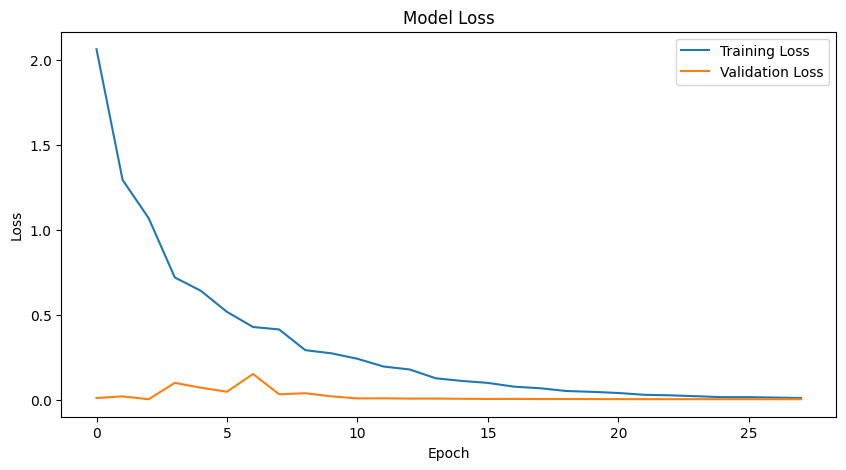

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Accuracy: 0.4713
Precision: 0.4715
Recall: 0.4754
F1-Score: 0.4735
RMSE: 0.019440


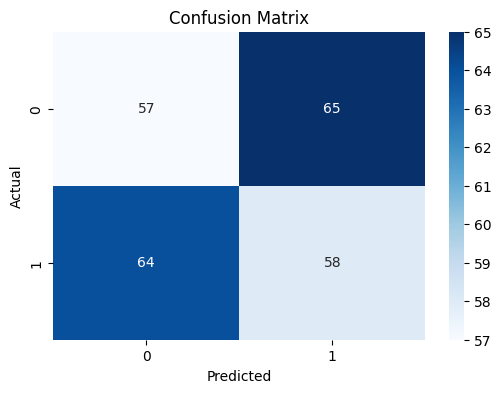

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[85/101] Training TTWO ...
/--------------------------------------------------------------------/
TTWO
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 1.9494 - mae: 1.0818 - val_loss: 0.0076 - val_mae: 0.0341 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9612 - mae: 0.7535 - val_loss: 0.0066 - val_mae: 0.0171 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8469 - mae: 0.7159 - val_loss: 0.0108 - val_mae: 0.0646 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6363 - mae: 0.6028 - val_loss: 0.0068 - val_mae: 0.0174 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4279 - mae: 0.5040 - val_loss: 0.0104 - val_mae: 0.0552 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4022 - mae: 0.4801 

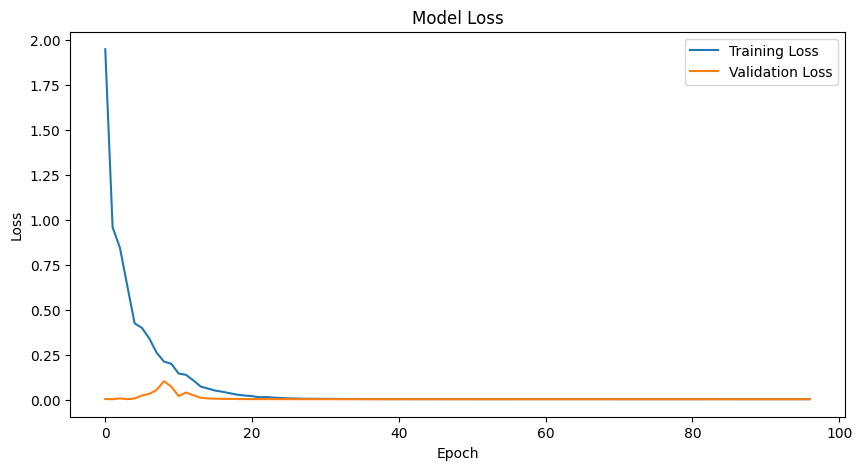

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
Accuracy: 0.5082
Precision: 0.5179
Recall: 0.4677
F1-Score: 0.4915
RMSE: 0.015570


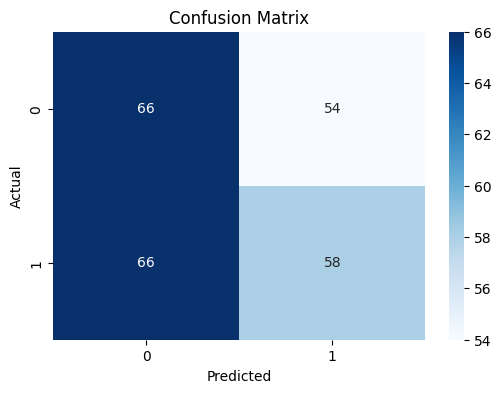

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[86/101] Training ROP ...
/--------------------------------------------------------------------/
ROP
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 1.9273 - mae: 1.0568 - val_loss: 0.0077 - val_mae: 0.0378 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1145 - mae: 0.8040 - val_loss: 0.0126 - val_mae: 0.0795 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8116 - mae: 0.6924 - val_loss: 0.0479 - val_mae: 0.2036 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7629 - mae: 0.6570 - val_loss: 0.0362 - val_mae: 0.1668 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5974 - mae: 0.5763 - val_loss: 0.0509 - val_mae: 0.1988 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4929 - mae: 0.5318 - va

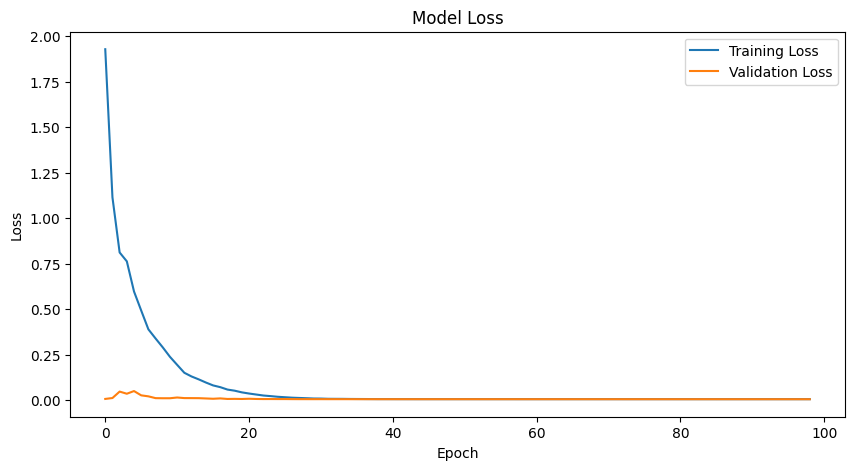

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Accuracy: 0.4303
Precision: 0.4000
Recall: 0.4386
F1-Score: 0.4184
RMSE: 0.011634


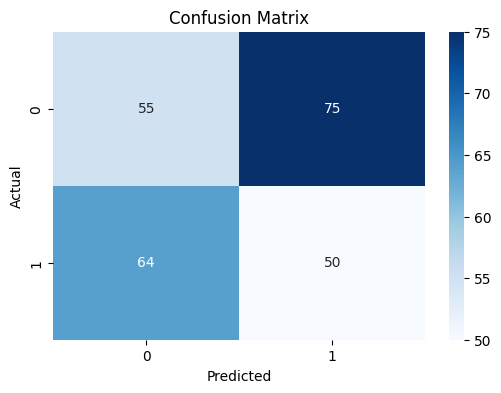

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[87/101] Training ZS ...
/--------------------------------------------------------------------/
ZS
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 2.2620 - mae: 1.1597 - val_loss: 0.0110 - val_mae: 0.0630 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2545 - mae: 0.8759 - val_loss: 0.0236 - val_mae: 0.1288 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9034 - mae: 0.7240 - val_loss: 0.0238 - val_mae: 0.1296 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6720 - mae: 0.6587 - val_loss: 0.0647 - val_mae: 0.2374 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5584 - mae: 0.5775 - val_loss: 0.0371 - val_mae: 0.1573 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4714 - mae: 0.5315 - val_

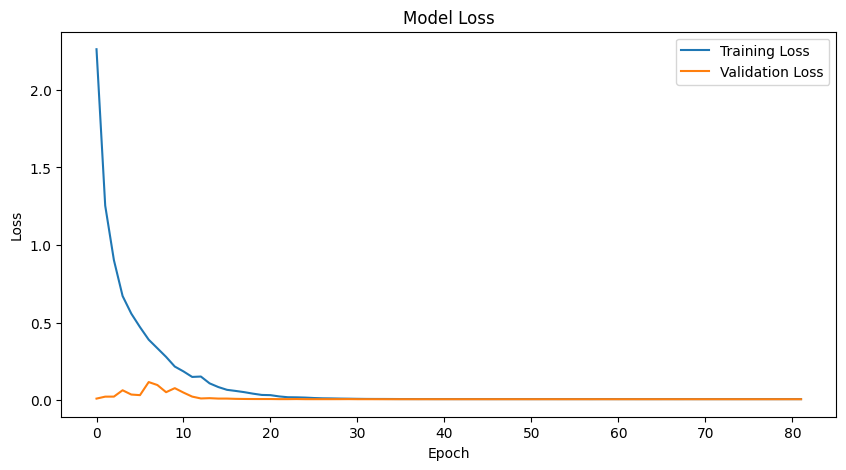

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
Accuracy: 0.4959
Precision: 0.4724
Recall: 0.5172
F1-Score: 0.4938
RMSE: 0.028795


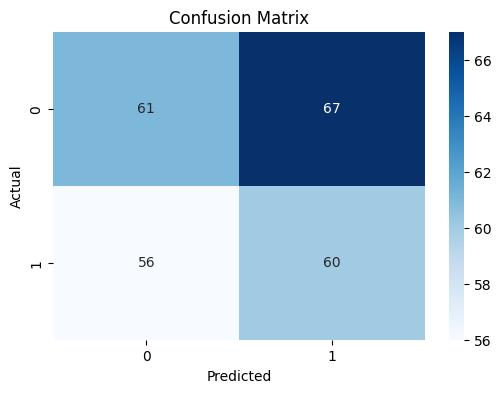

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[88/101] Training GFS ...
/--------------------------------------------------------------------/
GFS
/--------------------------------------------------------------------/
Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 2.5336 - mae: 1.2372 - val_loss: 0.0086 - val_mae: 0.0438 - learning_rate: 0.0010
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5743 - mae: 0.9918 - val_loss: 0.0105 - val_mae: 0.0618 - learning_rate: 0.0010
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0642 - mae: 0.8018 - val_loss: 0.0084 - val_mae: 0.0415 - learning_rate: 0.0010
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9618 - mae: 0.7748 - val_loss: 0.0073 - val_mae: 0.0271 - learning_rate: 0.0010
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7106 - mae: 0.6683 - val_loss: 0.0165 - val_mae: 0.0976 - learning_rate: 0.0010
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7392 - mae: 0.6693 - va

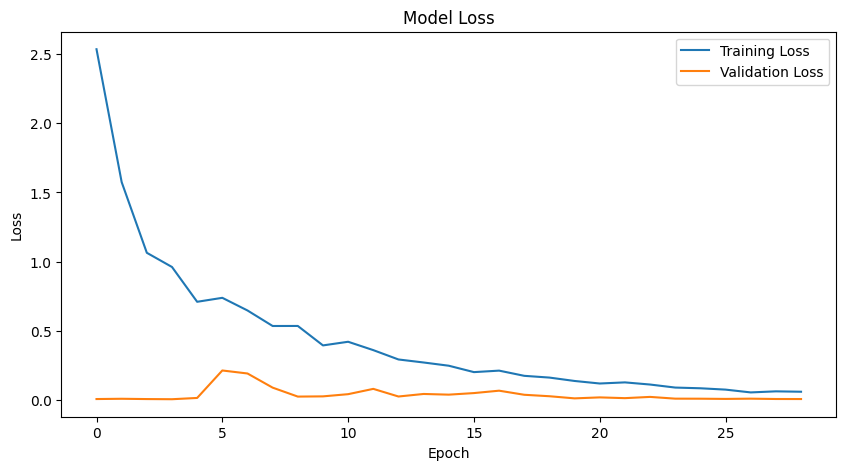

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Accuracy: 0.4549
Precision: 0.4273
Recall: 0.4017
F1-Score: 0.4141
RMSE: 0.036730


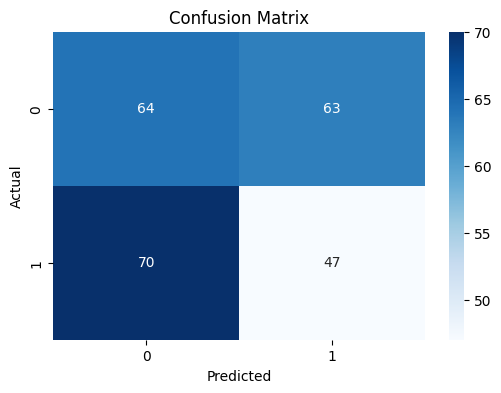

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[89/101] Training ISRG ...
/--------------------------------------------------------------------/
ISRG
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 2.2460 - mae: 1.1826 - val_loss: 0.0083 - val_mae: 0.0427 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2963 - mae: 0.8869 - val_loss: 0.0066 - val_mae: 0.0160 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9180 - mae: 0.7408 - val_loss: 0.0076 - val_mae: 0.0336 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7746 - mae: 0.6655 - val_loss: 0.1598 - val_mae: 0.3874 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6530 - mae: 0.6153 - val_loss: 0.4765 - val_mae: 0.6705 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6732 - mae: 0.6220 - 

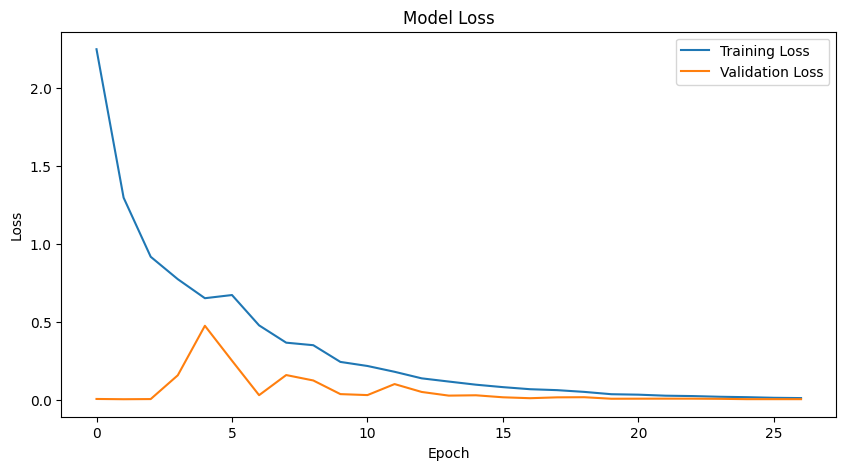

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Accuracy: 0.5000
Precision: 0.5041
Recall: 0.4959
F1-Score: 0.5000
RMSE: 0.021754


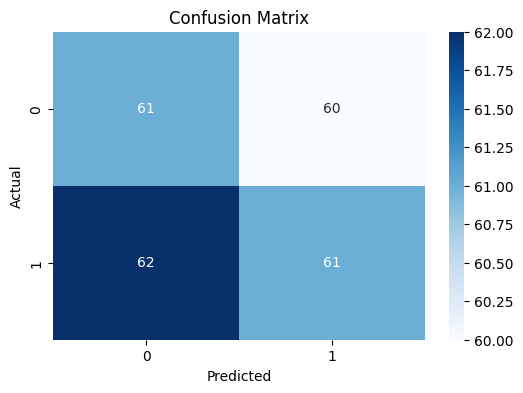

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[90/101] Training PLTR ...
/--------------------------------------------------------------------/
PLTR
/--------------------------------------------------------------------/
Epoch 1/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 2.3638 - mae: 1.2113 - val_loss: 0.0228 - val_mae: 0.1230 - learning_rate: 0.0010
Epoch 2/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5921 - mae: 0.9761 - val_loss: 0.0227 - val_mae: 0.1217 - learning_rate: 0.0010
Epoch 3/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2031 - mae: 0.8705 - val_loss: 0.0081 - val_mae: 0.0313 - learning_rate: 0.0010
Epoch 4/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9292 - mae: 0.7566 - val_loss: 0.0378 - val_mae: 0.1714 - learning_rate: 0.0010
Epoch 5/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7986 - mae: 0.6728 - val_loss: 0.0657 - val_mae: 0.2225 - learning_rate: 0.0010
Epoch 6/200
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7356 - mae: 0.6616

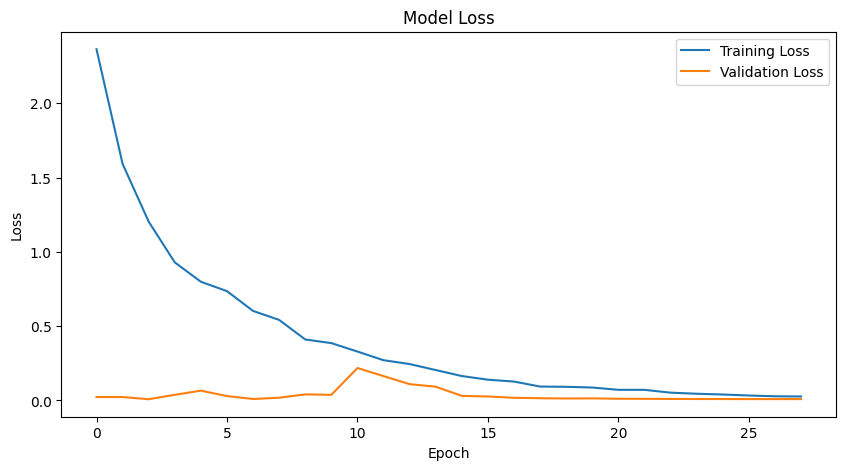

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Accuracy: 0.4959
Precision: 0.4661
Recall: 0.4783
F1-Score: 0.4721
RMSE: 0.045629


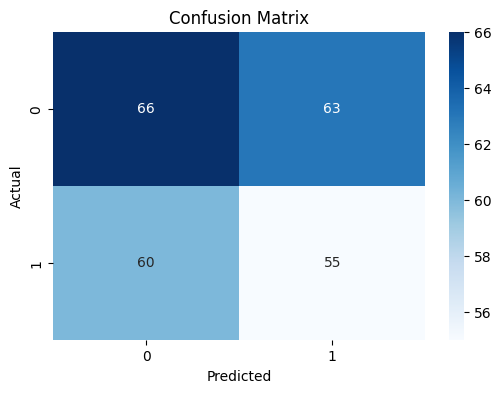

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[91/101] Training ADSK ...
/--------------------------------------------------------------------/
ADSK
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1.7296 - mae: 1.0117 - val_loss: 0.0152 - val_mae: 0.0933 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1434 - mae: 0.8415 - val_loss: 0.0079 - val_mae: 0.0362 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8357 - mae: 0.7053 - val_loss: 0.0343 - val_mae: 0.1640 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6593 - mae: 0.6347 - val_loss: 0.0174 - val_mae: 0.0917 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5099 - mae: 0.5504 - val_loss: 0.0487 - val_mae: 0.1849 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4144 - mae: 0.4852 - 

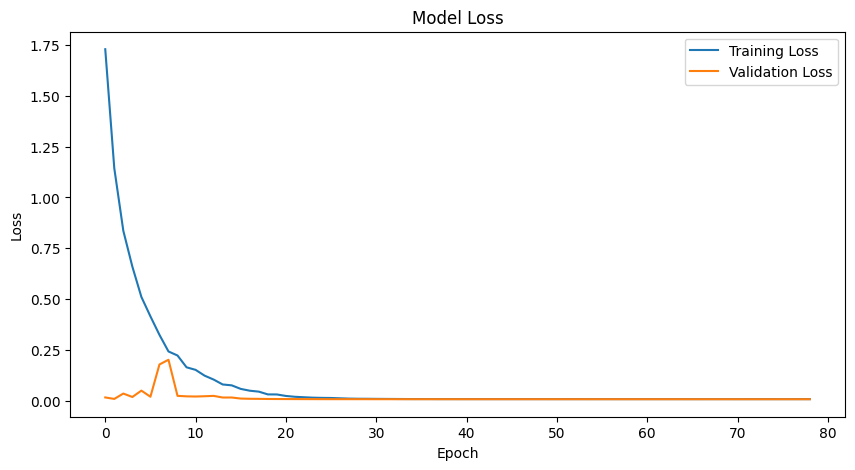

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Accuracy: 0.4590
Precision: 0.4174
Recall: 0.4248
F1-Score: 0.4211
RMSE: 0.018926


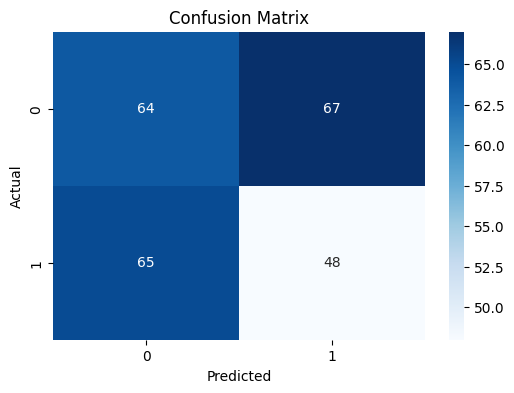

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[92/101] Training CPRT ...
/--------------------------------------------------------------------/
CPRT
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 2.4835 - mae: 1.2050 - val_loss: 0.0110 - val_mae: 0.0680 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2096 - mae: 0.8505 - val_loss: 0.0131 - val_mae: 0.0798 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8921 - mae: 0.7492 - val_loss: 0.1033 - val_mae: 0.3112 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7554 - mae: 0.6691 - val_loss: 0.0119 - val_mae: 0.0581 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6307 - mae: 0.6211 - val_loss: 0.0121 - val_mae: 0.0602 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5693 - mae: 0.5952 - 

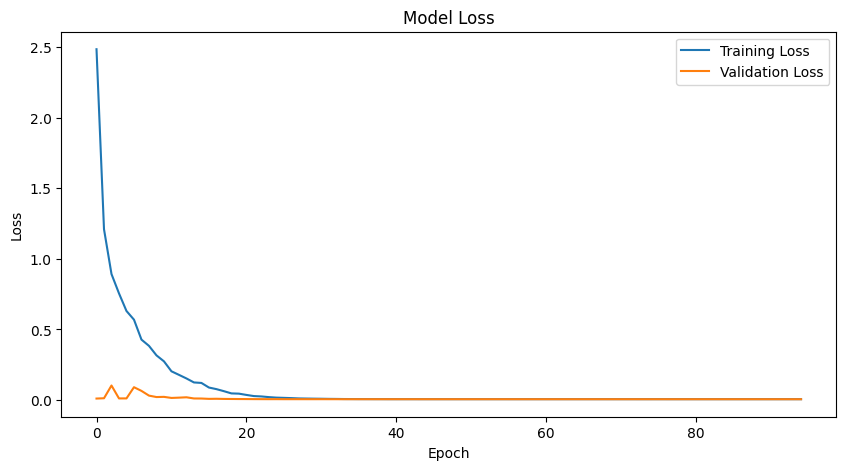

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Accuracy: 0.5451
Precision: 0.5344
Recall: 0.5833
F1-Score: 0.5578
RMSE: 0.014467


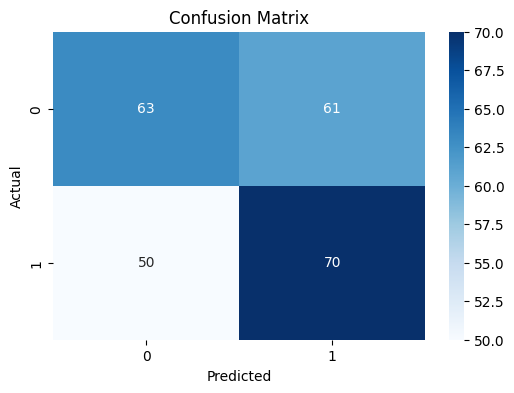

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[93/101] Training AMGN ...
/--------------------------------------------------------------------/
AMGN
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 1.9283 - mae: 1.0919 - val_loss: 0.0081 - val_mae: 0.0426 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3939 - mae: 0.9205 - val_loss: 0.0111 - val_mae: 0.0686 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9751 - mae: 0.7681 - val_loss: 0.0074 - val_mae: 0.0301 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8254 - mae: 0.7227 - val_loss: 0.0070 - val_mae: 0.0211 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7001 - mae: 0.6543 - val_loss: 0.0122 - val_mae: 0.0661 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5023 - mae: 0.5548 - 

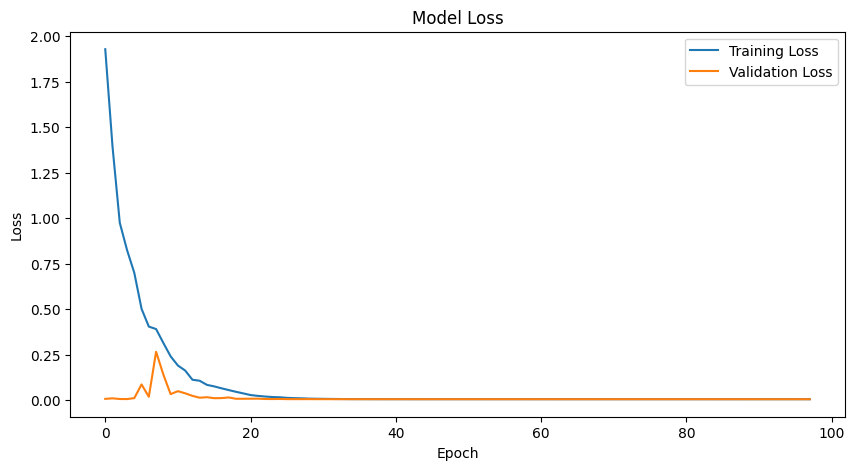

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Accuracy: 0.4959
Precision: 0.4878
Recall: 0.5000
F1-Score: 0.4938
RMSE: 0.016730


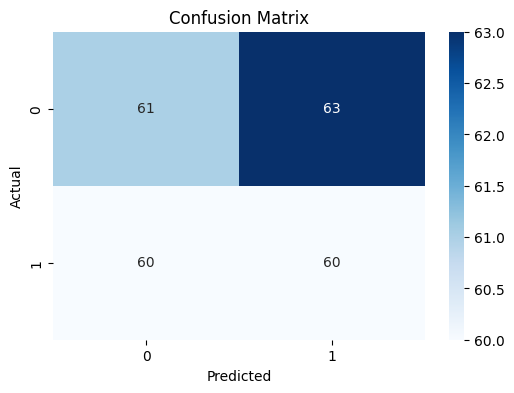

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[94/101] Training EXC ...
/--------------------------------------------------------------------/
EXC
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 1.8129 - mae: 1.0699 - val_loss: 0.0099 - val_mae: 0.0594 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2903 - mae: 0.8713 - val_loss: 0.0754 - val_mae: 0.2625 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9639 - mae: 0.7581 - val_loss: 0.0076 - val_mae: 0.0341 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7260 - mae: 0.6501 - val_loss: 0.0351 - val_mae: 0.1615 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6769 - mae: 0.6274 - val_loss: 0.0137 - val_mae: 0.0674 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5118 - mae: 0.5453 - val

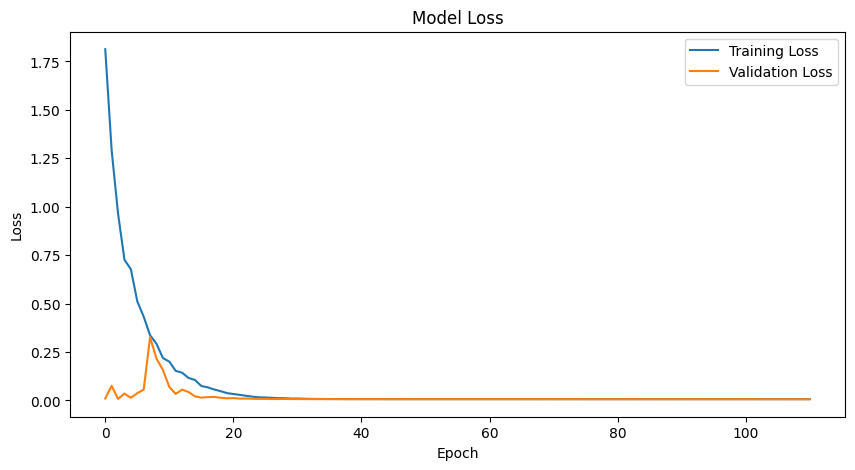

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
Accuracy: 0.5000
Precision: 0.4800
Recall: 0.5128
F1-Score: 0.4959
RMSE: 0.011706


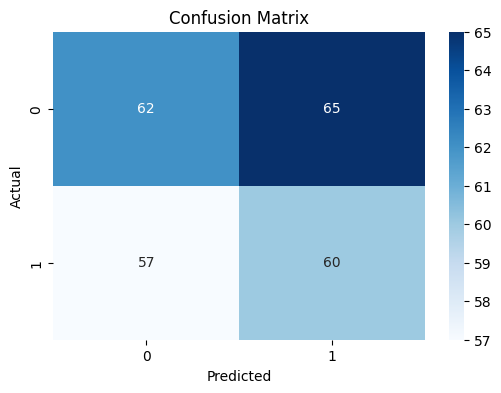

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[95/101] Training DDOG ...
/--------------------------------------------------------------------/
DDOG
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 2.2295 - mae: 1.1595 - val_loss: 0.0103 - val_mae: 0.0566 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3562 - mae: 0.9148 - val_loss: 0.0091 - val_mae: 0.0447 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.1193 - mae: 0.8371 - val_loss: 0.1283 - val_mae: 0.3473 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8495 - mae: 0.7041 - val_loss: 0.0230 - val_mae: 0.1098 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6295 - mae: 0.6142 - val_loss: 0.0306 - val_mae: 0.1397 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5106 - mae: 0.565

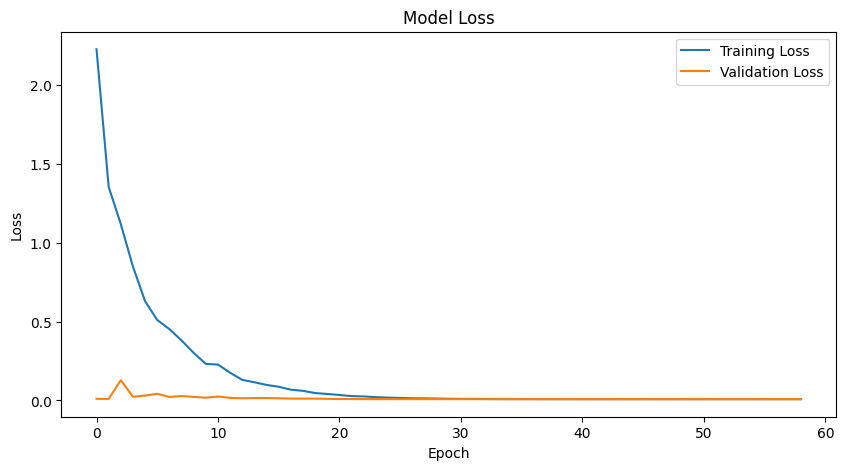

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Accuracy: 0.5492
Precision: 0.5620
Recall: 0.5440
F1-Score: 0.5528
RMSE: 0.023888


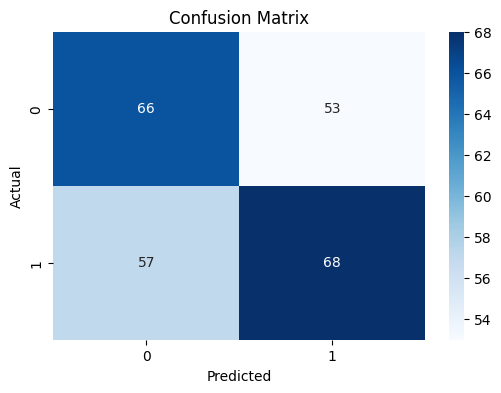

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[96/101] Training AEP ...
/--------------------------------------------------------------------/
AEP
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 1.4228 - mae: 0.9361 - val_loss: 0.0226 - val_mae: 0.1276 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7893 - mae: 0.6951 - val_loss: 0.0119 - val_mae: 0.0747 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5915 - mae: 0.5992 - val_loss: 0.0477 - val_mae: 0.2032 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4847 - mae: 0.5340 - val_loss: 0.0416 - val_mae: 0.1877 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3809 - mae: 0.4776 - val_loss: 0.0117 - val_mae: 0.0707 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3144 - mae: 0.4293 - 

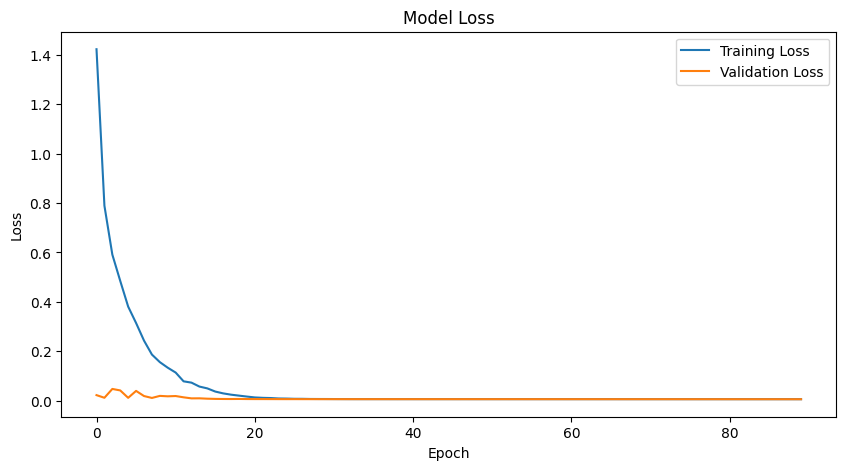

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Accuracy: 0.5369
Precision: 0.5227
Recall: 0.5798
F1-Score: 0.5498
RMSE: 0.012113


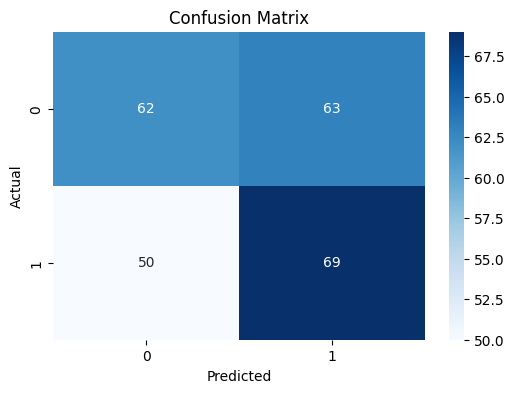

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[97/101] Training PCAR ...
/--------------------------------------------------------------------/
PCAR
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 2.4014 - mae: 1.1954 - val_loss: 0.0842 - val_mae: 0.2787 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2856 - mae: 0.8937 - val_loss: 0.1151 - val_mae: 0.3297 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0061 - mae: 0.7882 - val_loss: 0.1933 - val_mae: 0.4309 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7709 - mae: 0.6676 - val_loss: 0.0463 - val_mae: 0.1969 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6337 - mae: 0.6087 - val_loss: 0.0985 - val_mae: 0.2980 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5111 - mae: 0.5361 - 

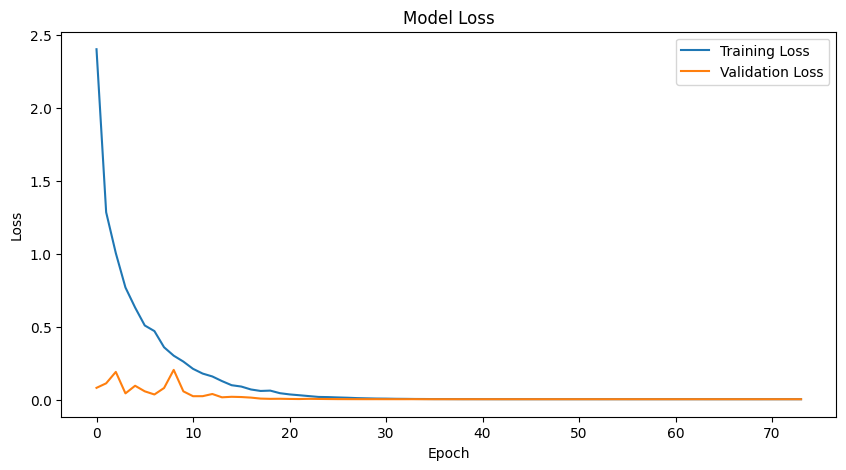

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step
Accuracy: 0.4795
Precision: 0.4622
Recall: 0.4661
F1-Score: 0.4641
RMSE: 0.016588


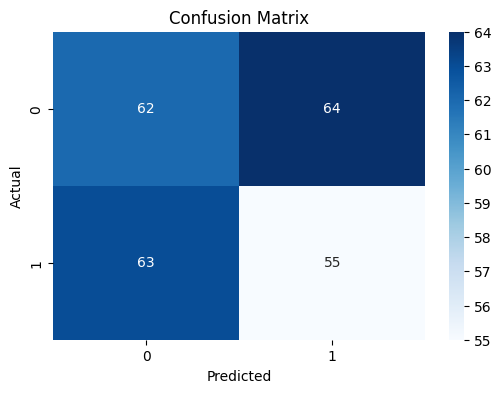

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[98/101] Training TMUS ...
/--------------------------------------------------------------------/
TMUS
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1.6053 - mae: 1.0062 - val_loss: 0.0093 - val_mae: 0.0546 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9692 - mae: 0.7907 - val_loss: 0.0484 - val_mae: 0.2046 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7329 - mae: 0.6633 - val_loss: 0.0557 - val_mae: 0.2219 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4940 - mae: 0.5358 - val_loss: 0.0723 - val_mae: 0.2554 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4149 - mae: 0.5028 - val_loss: 0.0135 - val_mae: 0.0793 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3308 - mae: 0.4463 -

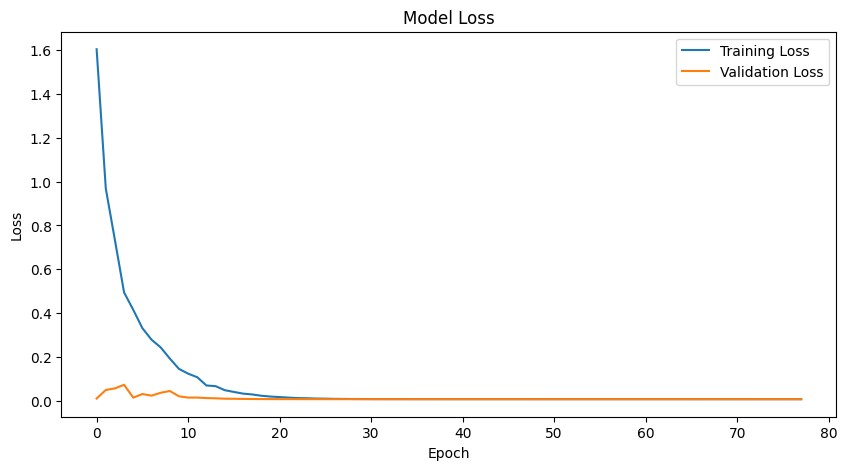

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
Accuracy: 0.5000
Precision: 0.5039
Recall: 0.5203
F1-Score: 0.5120
RMSE: 0.011137


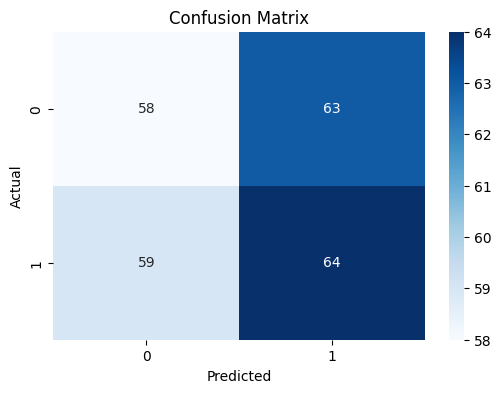

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[99/101] Training COST ...
/--------------------------------------------------------------------/
COST
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1.6316 - mae: 1.0056 - val_loss: 0.0064 - val_mae: 0.0113 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9055 - mae: 0.7561 - val_loss: 0.0507 - val_mae: 0.2105 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8079 - mae: 0.6953 - val_loss: 0.0075 - val_mae: 0.0312 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5998 - mae: 0.5993 - val_loss: 0.0838 - val_mae: 0.2755 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4264 - mae: 0.5030 - val_loss: 0.0327 - val_mae: 0.1223 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3121 - mae: 0.4318 -

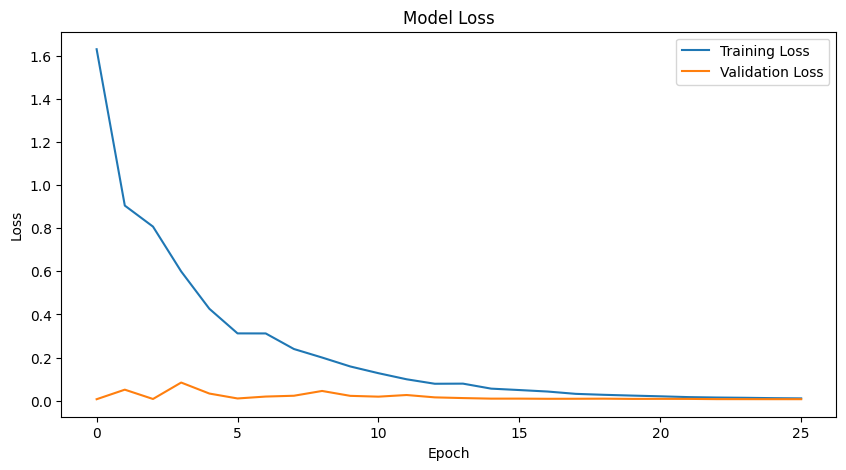

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Accuracy: 0.4877
Precision: 0.4800
Recall: 0.5000
F1-Score: 0.4898
RMSE: 0.014667


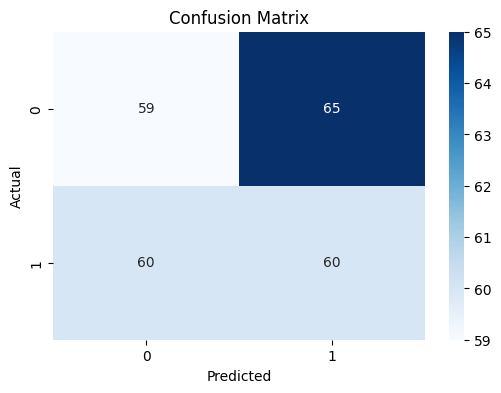

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
[100/101] Training INTU ...
/--------------------------------------------------------------------/
INTU
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1.7957 - mae: 1.0416 - val_loss: 0.0948 - val_mae: 0.2973 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9867 - mae: 0.7801 - val_loss: 0.0204 - val_mae: 0.1181 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8561 - mae: 0.7365 - val_loss: 0.0374 - val_mae: 0.1750 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5748 - mae: 0.6001 - val_loss: 0.0274 - val_mae: 0.1298 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4612 - mae: 0.5293 - val_loss: 0.0150 - val_mae: 0.0774 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3895 - mae: 0.4754 

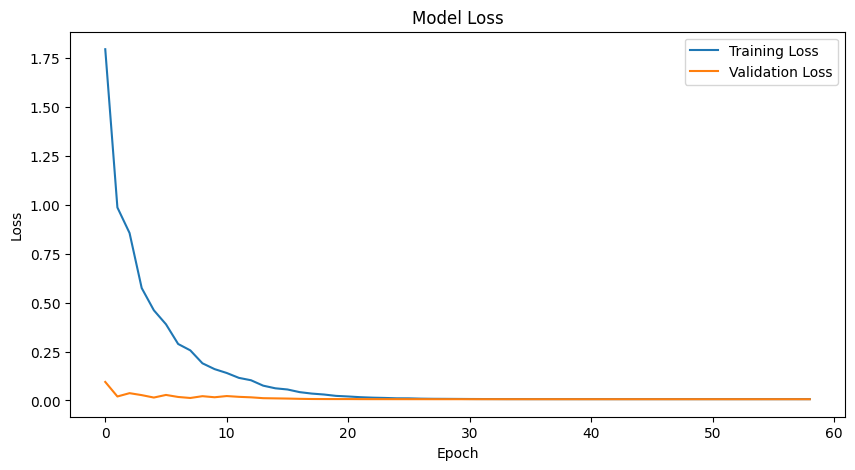

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Accuracy: 0.5287
Precision: 0.5203
Recall: 0.5333
F1-Score: 0.5267
RMSE: 0.018417


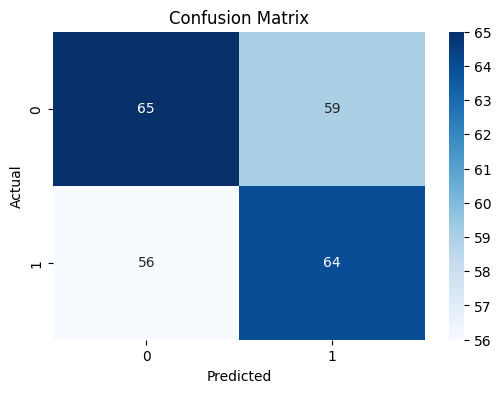

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[101/101] Training ASML ...
/--------------------------------------------------------------------/
ASML
/--------------------------------------------------------------------/
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1.8590 - mae: 1.0770 - val_loss: 0.0130 - val_mae: 0.0804 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0243 - mae: 0.7932 - val_loss: 0.0276 - val_mae: 0.1450 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8856 - mae: 0.7269 - val_loss: 0.0464 - val_mae: 0.1993 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6728 - mae: 0.6381 - val_loss: 0.0380 - val_mae: 0.1730 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5792 - mae: 0.5752 - val_loss: 0.3309 - val_mae: 0.5626 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4098 - mae: 0.483

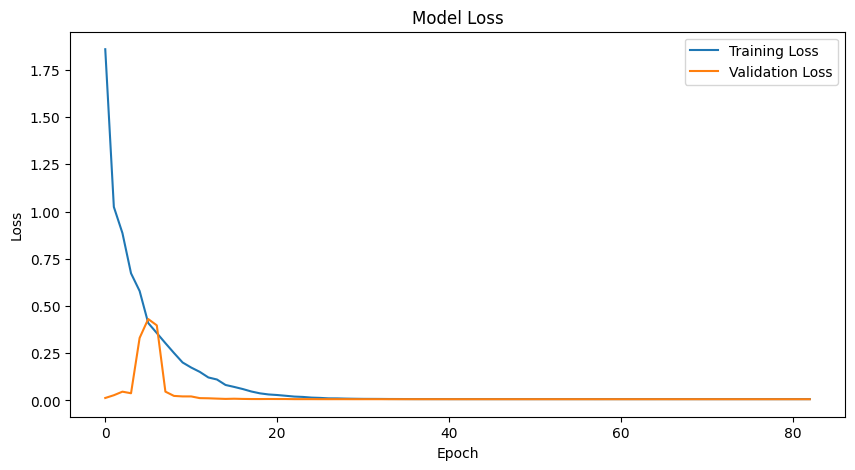

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
Accuracy: 0.4672
Precision: 0.5085
Recall: 0.4545
F1-Score: 0.4800
RMSE: 0.029109


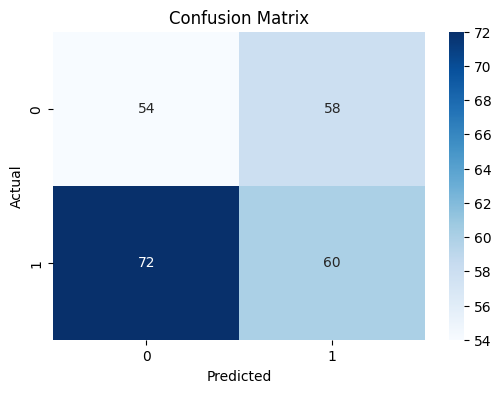

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
    Ticker  Accuracy  Precision    Recall  F1-Score      RMSE
0     FANG  0.422131   0.426357  0.450820  0.438247  0.018188
1      BKR  0.446721   0.429752  0.440678  0.435146  0.018060
2     CDNS  0.540984   0.530769  0.575000  0.552000  0.022079
3     CSCO  0.491803   0.470085  0.470085  0.470085  0.011839
4     MSTR  0.500000   0.469027  0.460870  0.464912  0.068998
..     ...       ...        ...       ...       ...       ...
96    PCAR  0.479508   0.462185  0.466102  0.464135  0.016588
97    TMUS  0.500000   0.503937  0.520325  0.512000  0.011137
98    COST  0.487705   0.480000  0.500000  0.489796  0.014667
99    INTU  0.528689   0.520325  0.533333  0.526749  0.018417
100   ASML  0.467213   0.508475  0.454545  0.480000  0.029109

[101 rows x 6 columns]


In [13]:
# Load and preprocess data
file_path = 'nasdaq100_stock_data.csv'
sequence_length = 5
df = load_data(file_path)
accuracies = []
precisions = []
recalls = []
f1_scores = []
RMSES = []

# Get the first level of the MultiIndex
tickers = df.columns.get_level_values(0).unique()
# Exclude 'Date'
tickers = tickers[tickers != 'Date'].tolist()
total = len(tickers)

for i, ticker in enumerate(tickers, start=1):
    print(f"[{i}/{total}] Training {ticker} ...")
    result_list = execute_training_tickers(ticker, sequence_length)
    accuracies.append(result_list[0])
    precisions.append(result_list[1])
    recalls.append(result_list[2])
    f1_scores.append(result_list[3])
    RMSES.append(result_list[4])

# Save accuracies, precisions, recalls, f1_scores and RMSES into a dataframe and save as .csv
# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Ticker': tickers,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1_scores,
    'RMSE': RMSES
})

# Show the dataframe
print(results_df)

# Save to CSV
results_df.to_csv('gru_evaluation_results.csv', index=False)

In [15]:
# Save to CSV
results_df.to_csv('gru_evaluation_results.csv', index=False)